In [232]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [298]:
def load_operator_data(dataset_path='dataset'):
    IMG_SIZE = (28, 28)
    CLASSES = ['add', 'sub', 'mul', 'div']
    data = []
    labels = []
    
    for label, category in enumerate(CLASSES):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory {category_path} not found!")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # retain RGB channels
                img = img.resize(IMG_SIZE)
                img_array = np.array(img)
                # flatten image to 1D array
                data.append(img_array.flatten())
                labels.append(label)
                
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, CLASSES

def load_mnist_from_csv(train_path, test_path):
    train_data = pd.read_csv(train_path)
    if train_data.isna().any().any():
        train_data = train_data.fillna(0)
    
    X_train = train_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_train = train_data.iloc[:, 0].values.astype(int)
    
    test_data = pd.read_csv(test_path)
    if test_data.isna().any().any():
        test_data = test_data.fillna(0)
    
    X_test = test_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_test = test_data.iloc[:, 0].values.astype(int)
    
    return X_train, y_train, X_test, y_test

In [300]:
def visualize_digits(images, labels, num_samples=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [260]:
def train_evaluate_rfc(X_train, y_train, X_test, y_test):
    """
    Trains a Random Forest Classifier
    """
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    predict_time = time.time() - start_time
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Model training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"Accuracy: {acc * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, y_pred

--- Operator Model Training ---
Model training time: 0.72 seconds
Prediction time: 0.01 seconds
Accuracy: 94.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       122
           1       0.95      0.98      0.97       132
           2       0.94      0.97      0.96       122
           3       0.93      0.93      0.93       114

    accuracy                           0.95       490
   macro avg       0.95      0.95      0.95       490
weighted avg       0.95      0.95      0.95       490



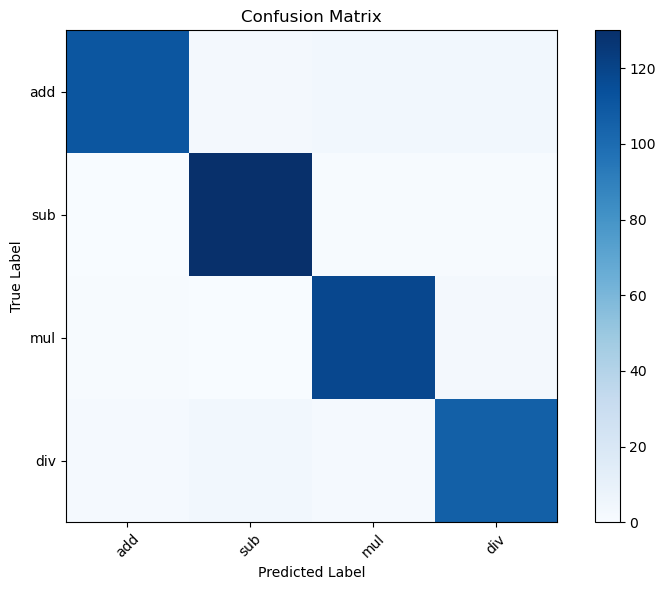

--- MNIST Digit Model Training ---
Displaying sample digits from MNIST:


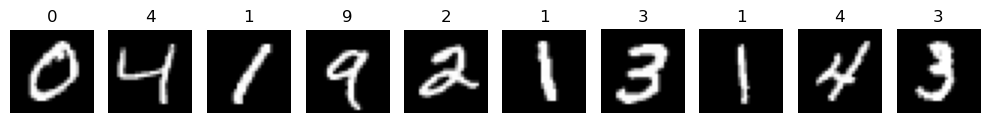

Model training time: 26.43 seconds
Prediction time: 0.16 seconds
Accuracy: 96.87%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.96      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



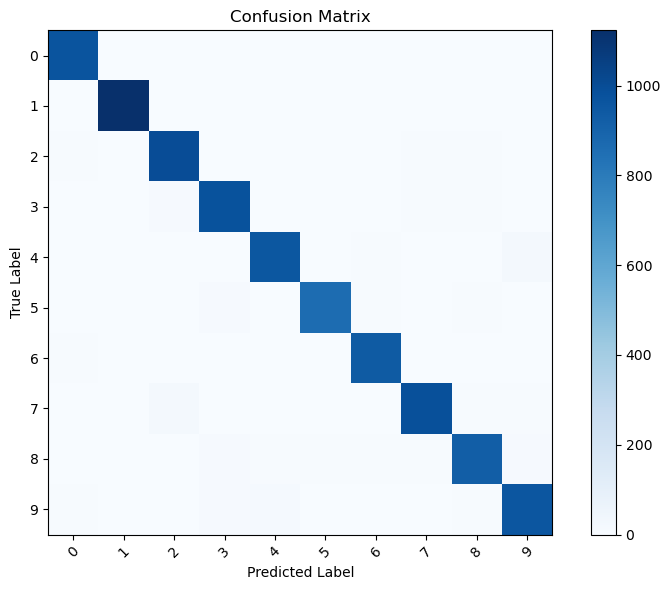

['digit_model.joblib']

In [302]:
print("--- Operator Model Training ---")
op_data, op_labels, op_classes = load_operator_data(dataset_path='dataset')
X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(
    op_data, op_labels, test_size=0.2, random_state=42)

operator_clf, op_y_pred = train_evaluate_rfc(X_train_op, y_train_op, X_test_op, y_test_op)
plot_confusion_matrix(y_test_op, op_y_pred, classes=op_classes)

# Save operator model to avoid retraining every time
joblib.dump(operator_clf, 'operator_model.joblib')



print("--- MNIST Digit Model Training ---")
train_path = "mnist_train.csv"
test_path = "mnist_test.csv"

X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist = load_mnist_from_csv(train_path, test_path)

print("Displaying sample digits from MNIST:")
visualize_digits(X_train_mnist, y_train_mnist)

digit_clf, mnist_y_pred = train_evaluate_rfc(X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist)
plot_confusion_matrix(y_test_mnist, mnist_y_pred, classes=[str(i) for i in range(10)])

# Save MNIST model
joblib.dump(digit_clf, 'digit_model.joblib')

In [483]:
def segment_expression(image_path):
    """
    Segments a full expression image into individual characters using OpenCV,
    adding morphological dilation and bounding-box padding so they aren't too tight.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} cannot be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold and invert so digits/operators are white on black
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morphological dilation to enlarge the digits/operators slightly
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Then find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Filter out noise
        if w * h < 100:
            continue
        
        # --- Add some padding around the bounding box ---
        pad = 2
        x_start = max(0, x - pad)
        y_start = max(0, y - pad)
        x_end = min(gray.shape[1], x + w + pad)
        y_end = min(gray.shape[0], y + h + pad)
        
        w_pad = x_end - x_start
        h_pad = y_end - y_start
        
        boxes.append((x_start, y_start, w_pad, h_pad))

    # Sort by x-coordinate
    boxes.sort(key=lambda b: b[0])
    
    segments = []
    for box in boxes:
        x, y, w, h = box
        # Crop from original RGB image
        roi_color = image[y : y + h, x : x + w]
        segments.append((box, roi_color))
    
    return segments


In [414]:
def preprocess_segment_for_digit(roi_color):
    roi_gray = cv2.cvtColor(roi_color, cv2.COLOR_RGB2GRAY)
    roi_gray = 255 - roi_gray

    _, roi_bin = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    ys, xs = np.where(roi_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        return np.zeros((784,), dtype=np.float32)

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    roi_cropped = roi_gray[y_min:y_max+1, x_min:x_max+1]

    h, w = roi_cropped.shape
    if h > w:
        new_h = 20
        new_w = int(w * (20.0 / h))
    else:
        new_w = 20
        new_h = int(h * (20.0 / w))
    roi_resized = cv2.resize(roi_cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    canvas = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = roi_resized

    canvas = canvas.astype(np.float32) / 255.0
    return canvas.flatten()


def preprocess_segment_for_operator(roi_color):
    h, w, _ = roi_color.shape
    if h > w:
        pad = (h - w) // 2
        roi_padded = cv2.copyMakeBorder(roi_color, 0, 0, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    elif w > h:
        pad = (w - h) // 2
        roi_padded = cv2.copyMakeBorder(roi_color, pad, pad, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        roi_padded = roi_color

    roi_resized = cv2.resize(roi_padded, (28, 28))
    roi_flat = roi_resized.flatten()
    return roi_flat


In [432]:
def compare_mnist_and_segmented(mnist_X, mnist_y, segmented_rois, num_samples=5):
    mnist_indices = random.sample(range(len(mnist_X)), num_samples)
    plt.figure(figsize=(10, 4))
    print("--- MNIST Samples ---")
    for i, idx in enumerate(mnist_indices):
        img = mnist_X[idx].reshape(28, 28)
        label = mnist_y[idx]
        aspect = 1.0  # Already square
        white_px = np.sum(img > 0.1)
        print(f"MNIST #{i} — Label: {label}, Shape: {img.shape}, White pixels: {white_px}, Range: [{img.min():.2f}, {img.max():.2f}]")
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"MNIST: {label}")
        plt.axis("off")

    print("--- Segmented Samples ---")
    for i in range(num_samples):
        if i >= len(segmented_rois):
            break
        roi = segmented_rois[i]
        processed = preprocess_segment_for_digit(roi).reshape(28, 28)
        h, w = roi.shape[:2]
        aspect = w / h
        white_px = np.sum(processed > 0.1)
        print(f"ROI #{i} — Original: {roi.shape}, Preprocessed: {processed.shape}, Aspect: {aspect:.2f}, White pixels: {white_px}, Range: [{processed.min():.2f}, {processed.max():.2f}]")
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(processed, cmap="gray")
        plt.title(f"Segmented #{i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def classify_segment(idx, roi_color, digit_model, operator_model):
    digit_input = preprocess_segment_for_digit(roi_color)
    operator_input = preprocess_segment_for_operator(roi_color)

    digit_probs = digit_model.predict_proba([digit_input])[0]
    operator_probs = operator_model.predict_proba([operator_input])[0]
    max_digit_prob = np.max(digit_probs)
    max_operator_prob = np.max(operator_probs)

    h, w, _ = roi_color.shape
    aspect_ratio = w / h if h != 0 else 1

    if idx % 2 == 0:
        prediction = digit_model.predict([digit_input])[0]
        symbol = str(prediction)
        clf_used = 'digit'
    else:
        prediction = operator_model.predict([operator_input])[0]
        # assumed order: [add, sub, mul, div]
        op_mapping = {0: '+', 1: '-', 2: '*', 3: '/'}
        symbol = op_mapping.get(prediction, '?')
        clf_used = 'operator'
    
    return symbol, clf_used

In [410]:
def process_expression(image_path, digit_model, operator_model, debug=False):
    segments = segment_expression(image_path)
    rois = [roi for box, roi in segments]

    compare_mnist_and_segmented(X_train_mnist, y_train_mnist, rois, num_samples=5)
    expression = ""
    
    if debug:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for box, _ in segments:
            x, y, w, h = box
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 1)
        plt.imshow(image)
        plt.title("Merged Segmentation Results")
        plt.axis('off')
        plt.show()

    idx = 0
    for box, roi in segments:
        symbol, clf_used = classify_segment(idx, roi, digit_model, operator_model)
        idx += 1
        print(f"Box {box}: Classified as {symbol} using {clf_used} model")
        expression += symbol
    return expression

In [315]:
def safe_eval(expression):
    try:
        result = eval(expression)
    except Exception as e:
        raise ValueError(f"Error evaluating expression: {e}")
    return result


Processing image: expression_dataset/expr_083.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 95, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 129, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 154, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 16, 3), Preprocessed: (28, 28), Aspect: 0.64, White pixels: 102, Range: [0.00, 1.00]
ROI #1 — Original: (13, 25, 3), Preprocessed: (28, 28), Aspect: 1.92, White pixels: 86, Range: [0.00, 1.00]
ROI #2 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels: 117, Range: [0.00, 1.00]


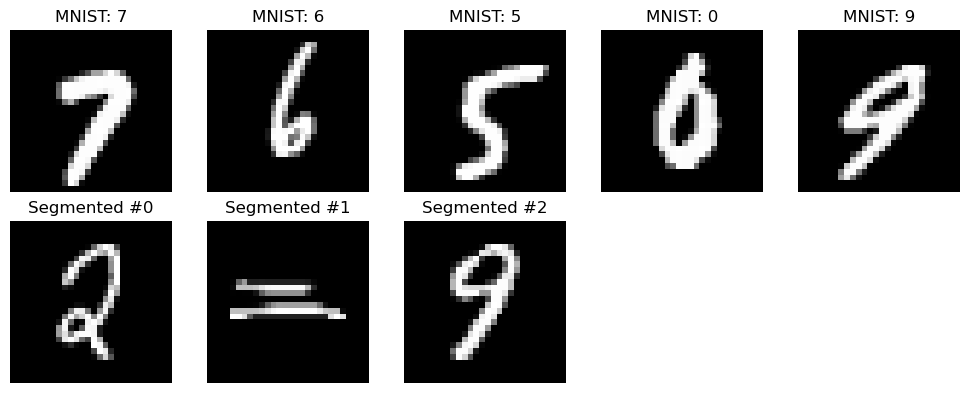

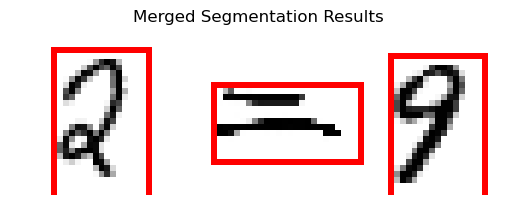

Box (7, 3, 16, 25): Classified as 2 using digit model
Box (34, 9, 25, 13): Classified as / using operator model
Box (64, 4, 16, 24): Classified as 8 using digit model
Reconstructed Expression: 2/8
Evaluation Result: 0.25

Processing image: expression_dataset/expr_097.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 150, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 167, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 69, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 156, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 154, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 175, Range: [0.00, 1.00]
ROI #1 — Original: (15, 23, 3), Preprocessed: (28, 28), Aspect: 1.53, White pixels: 68, Range: [0.00, 1.00]
ROI #2 — Original: (21, 25, 3), Preprocessed: (28, 28), Aspect: 1.19, White pix

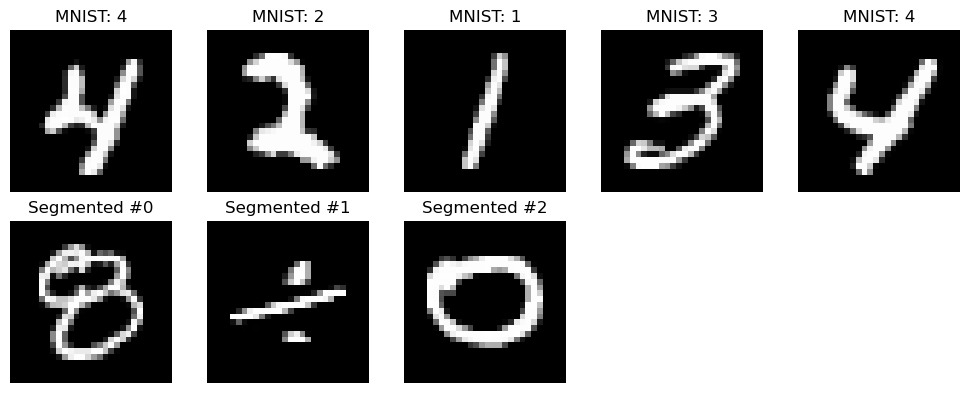

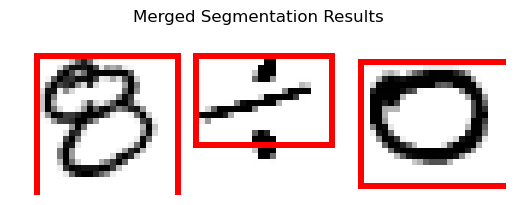

Box (4, 4, 24, 24): Classified as 3 using digit model
Box (31, 4, 23, 15): Classified as / using operator model
Box (59, 5, 25, 21): Classified as 0 using digit model
Reconstructed Expression: 3/0
Evaluation Error: Error evaluating expression: division by zero

Processing image: expression_dataset/expr_068.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 205, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 228, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 13, 3), Preprocessed: (28, 28), Aspect: 0.54, White pixels: 92, Range: [0.00, 1.00]
ROI #1 — Original: (22, 22, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 96, Range: [0.00, 1.00]
ROI #2 — Original: (23, 22, 3), Preproc

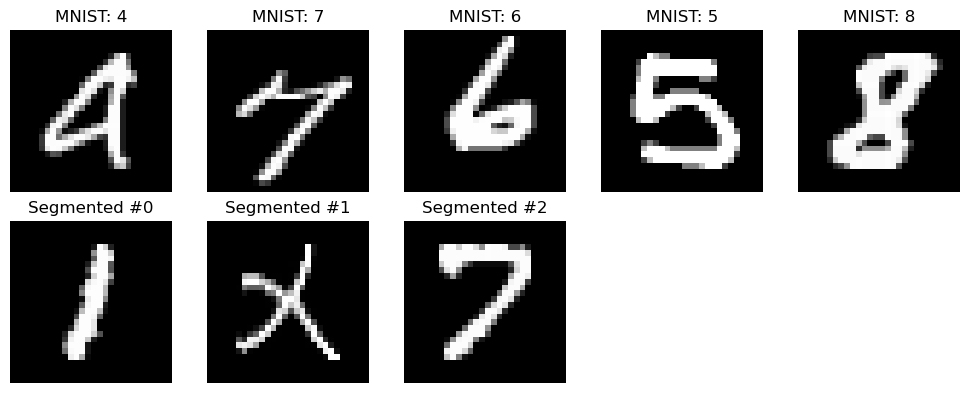

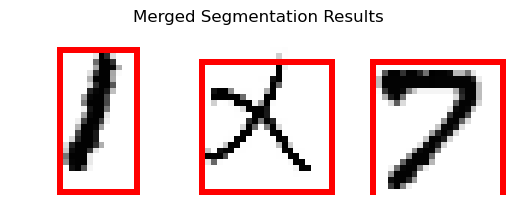

Box (8, 3, 13, 24): Classified as 1 using digit model
Box (32, 5, 22, 22): Classified as * using operator model
Box (61, 5, 22, 23): Classified as 2 using digit model
Reconstructed Expression: 1*2
Evaluation Result: 2

Processing image: expression_dataset/expr_040.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 80, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 123, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 9, 3), Preprocessed: (28, 28), Aspect: 0.38, White pixels: 71, Range: [0.00, 1.00]
ROI #1 — Original: (26, 24, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 89, Range: [0.00, 1.00]
ROI #2 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 

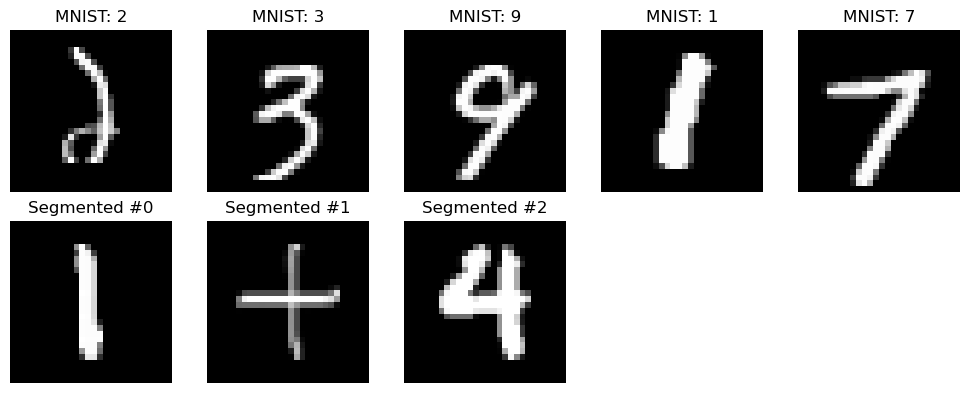

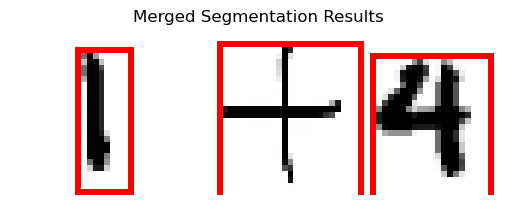

Box (11, 3, 9, 24): Classified as 1 using digit model
Box (35, 2, 24, 26): Classified as + using operator model
Box (61, 4, 20, 24): Classified as 4 using digit model
Reconstructed Expression: 1+4
Evaluation Result: 5

Processing image: expression_dataset/expr_054.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 166, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 109, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (26, 24, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 208, Range: [0.00, 1.00]
ROI #1 — Original: (23, 28, 3), Preprocessed: (28, 28), Aspect: 1.22, White pixels: 89, Range: [0.00, 1.00]
ROI #2 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixel

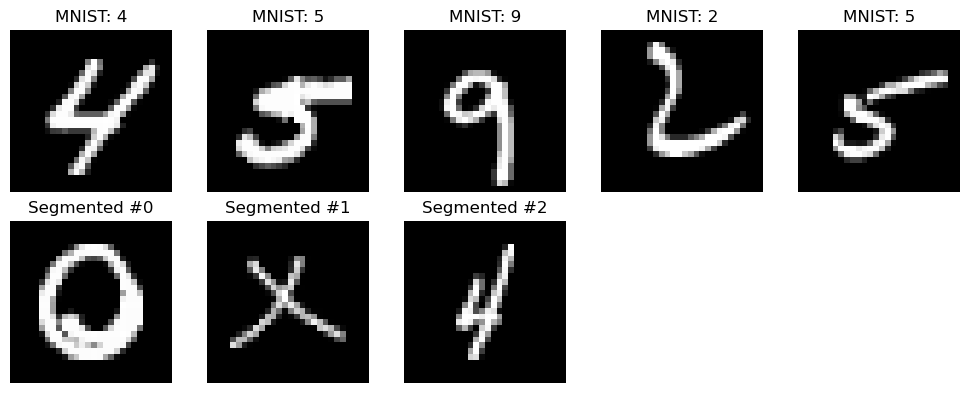

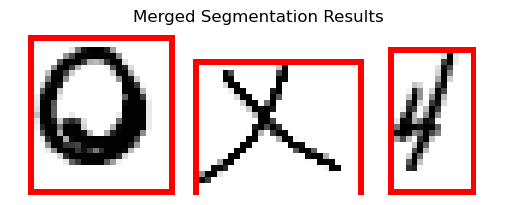

Box (3, 1, 24, 26): Classified as 0 using digit model
Box (31, 5, 28, 23): Classified as * using operator model
Box (64, 3, 14, 24): Classified as 4 using digit model
Reconstructed Expression: 0*4
Evaluation Result: 0

Processing image: expression_dataset/expr_055.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 148, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 192, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 208, Range: [0.00, 1.00]
ROI #1 — Original: (24, 27, 3), Preprocessed: (28, 28), Aspect: 1.12, White pixels: 96, Range: [0.00, 1.00]
ROI #2 — Original: (20, 24, 3), Preprocessed: (28, 28), Aspect: 1.20, White pixels

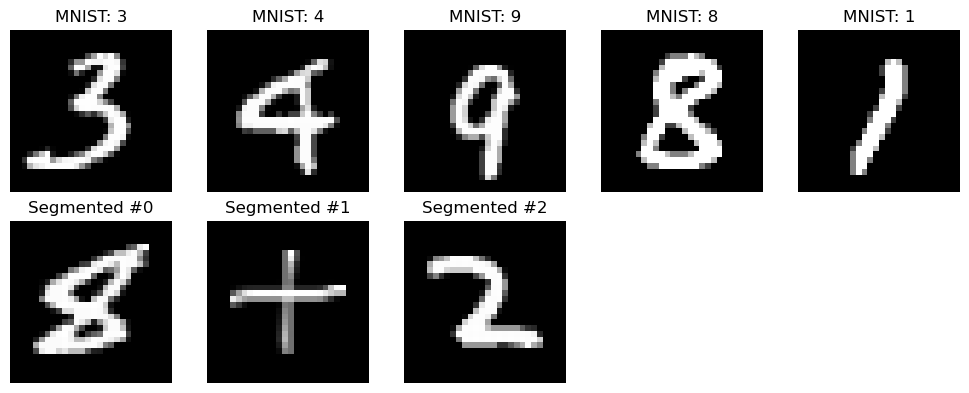

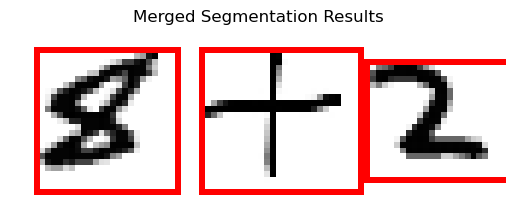

Box (4, 3, 24, 24): Classified as 8 using digit model
Box (32, 3, 27, 24): Classified as + using operator model
Box (60, 5, 24, 20): Classified as 2 using digit model
Reconstructed Expression: 8+2
Evaluation Result: 10

Processing image: expression_dataset/expr_041.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 183, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 121, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 167, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 257, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 151, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (26, 25, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 178, Range: [0.00, 1.00]
ROI #1 — Original: (13, 22, 3), Preprocessed: (28, 28), Aspect: 1.69, White pixels: 51, Range: [0.00, 1.00]
ROI #2 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixe

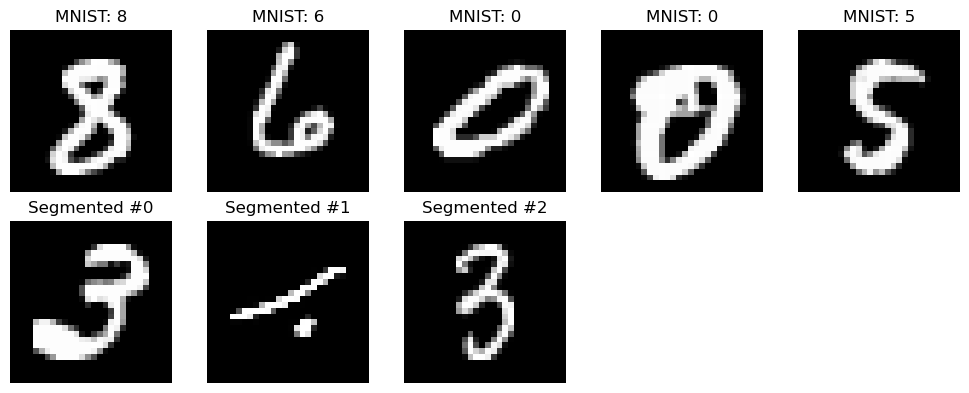

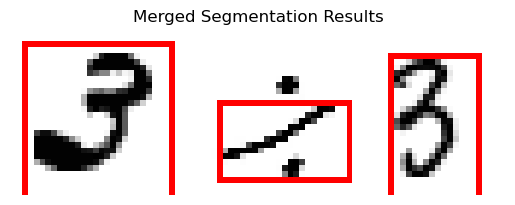

Box (2, 2, 25, 26): Classified as 3 using digit model
Box (35, 12, 22, 13): Classified as / using operator model
Box (64, 4, 15, 24): Classified as 3 using digit model
Reconstructed Expression: 3/3
Evaluation Result: 1.0

Processing image: expression_dataset/expr_069.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 175, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 230, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 50, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 20, 3), Preprocessed: (28, 28), Aspect: 0.80, White pixels: 138, Range: [0.00, 1.00]
ROI #1 — Original: (24, 12, 3), Preprocessed: (28, 28), Aspect: 0.50, White pixels: 68, Range: [0.00, 1.00]


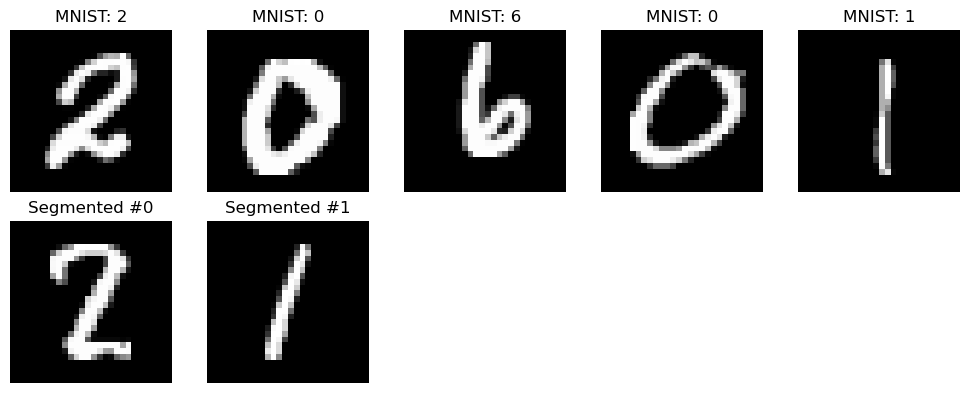

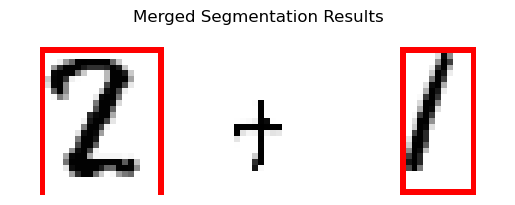

Box (5, 3, 20, 25): Classified as 2 using digit model
Box (66, 3, 12, 24): Classified as + using operator model
Reconstructed Expression: 2+
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_096.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 151, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 170, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 24, 3), Preprocessed: (28, 28), Aspect: 1.04, White pixels: 71, Range: [0.00, 1.00]
ROI #1 — Original: (23, 25, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 128, Range: [0.00, 1.00]
ROI #2 — Original: (24, 9, 3), Preprocessed: (28, 28), Aspect: 0.38, White pi

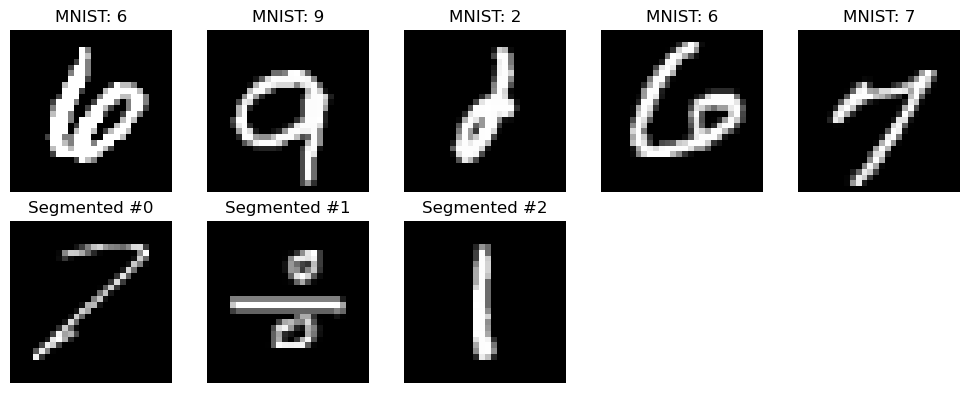

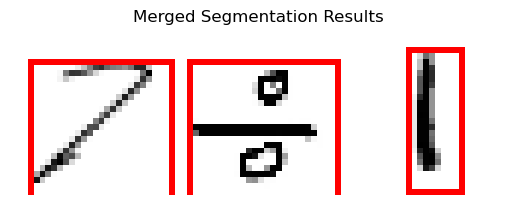

Box (3, 5, 24, 23): Classified as 2 using digit model
Box (30, 5, 25, 23): Classified as / using operator model
Box (67, 3, 9, 24): Classified as 1 using digit model
Reconstructed Expression: 2/1
Evaluation Result: 2.0

Processing image: expression_dataset/expr_082.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 180, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 71, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 137, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 19, 3), Preprocessed: (28, 28), Aspect: 0.79, White pixels: 155, Range: [0.00, 1.00]


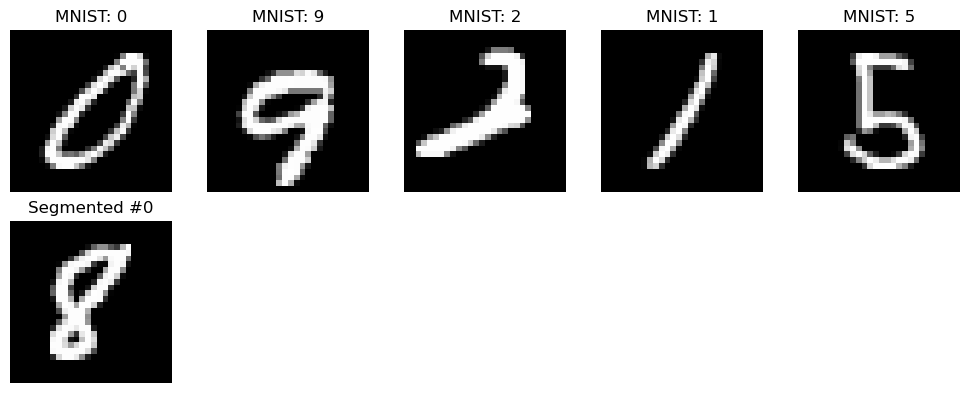

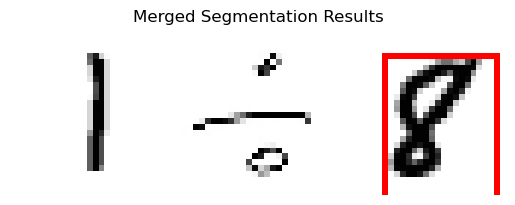

Box (63, 4, 19, 24): Classified as 2 using digit model
Reconstructed Expression: 2
Evaluation Result: 2

Processing image: expression_dataset/expr_094.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 77, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 177, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 175, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 135, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 165, Range: [0.00, 1.00]
ROI #1 — Original: (16, 13, 3), Preprocessed: (28, 28), Aspect: 0.81, White pixels: 120, Range: [0.00, 1.00]
ROI #2 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White pixels: 111, Range: [0.00, 1.00]


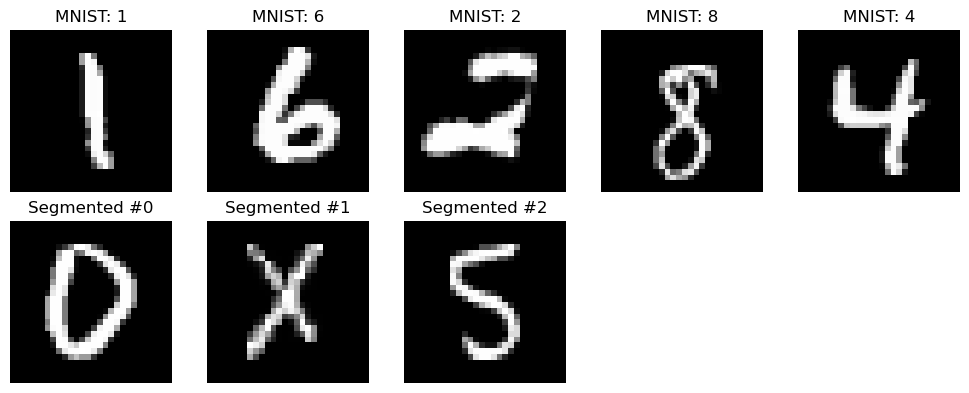

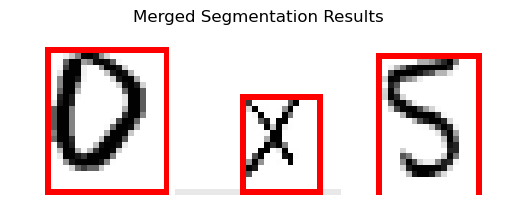

Box (6, 3, 20, 24): Classified as 0 using digit model
Box (39, 11, 13, 16): Classified as * using operator model
Box (62, 4, 17, 24): Classified as 5 using digit model
Reconstructed Expression: 0*5
Evaluation Result: 0

Processing image: expression_dataset/expr_080.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 159, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 157, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 104, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 220, Range: [0.00, 1.00]
ROI #1 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 122, Range: [0.00, 1.00]


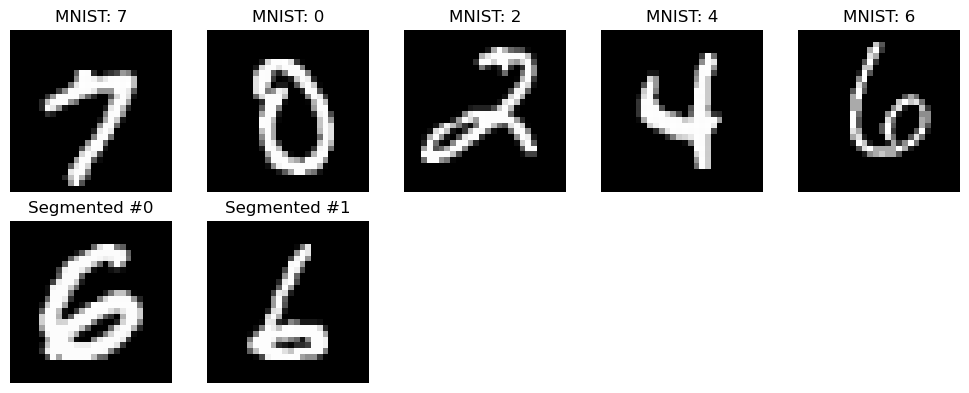

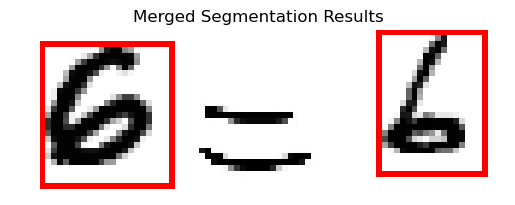

Box (5, 2, 22, 24): Classified as 6 using digit model
Box (62, 0, 18, 24): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_057.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 83, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 96, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 85, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 15, 3), Preprocessed: (28, 28), Aspect: 0.65, White pixels: 96, Range: [0.00, 1.00]
ROI #1 — Original: (23, 22, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 174, Range: [0.00, 1.00]


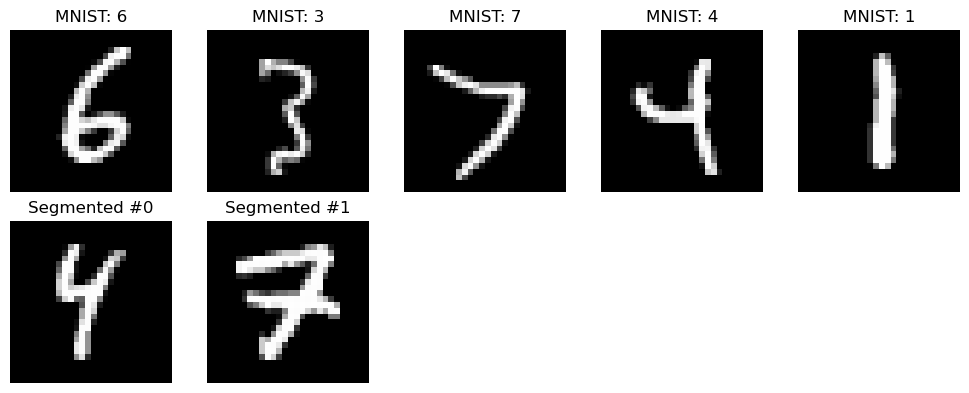

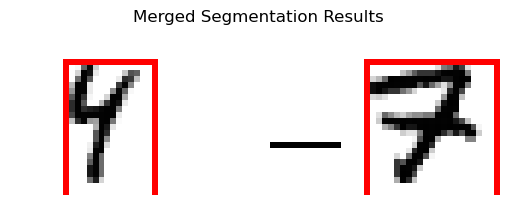

Box (9, 5, 15, 23): Classified as 8 using digit model
Box (60, 5, 22, 23): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_043.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 66, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 114, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 156, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 88, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 233, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixels: 76, Range: [0.00, 1.00]
ROI #1 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 182, Range: [0.00, 1.00]


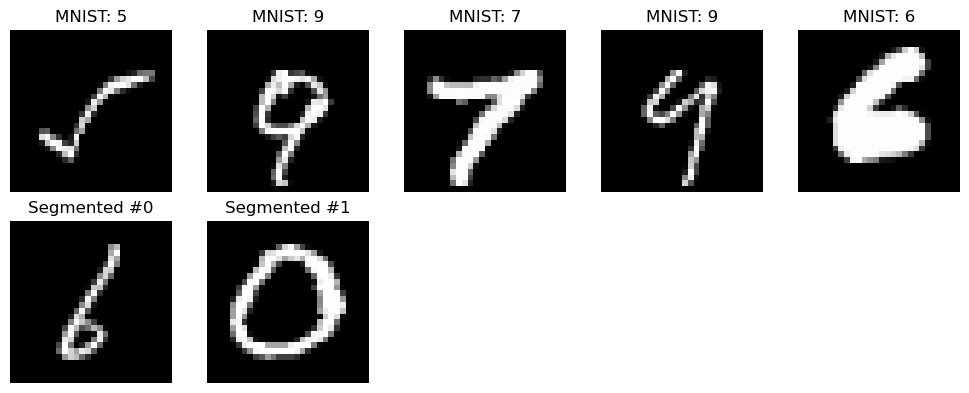

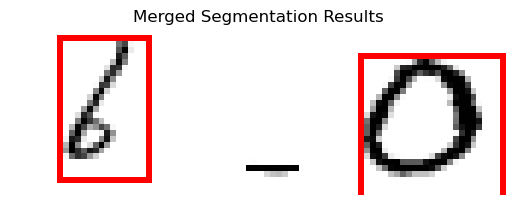

Box (8, 1, 15, 24): Classified as 1 using digit model
Box (59, 4, 24, 24): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_042.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 110, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 104, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 191, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixels: 110, Range: [0.00, 1.00]
ROI #1 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 150, Range: [0.00, 1.00]


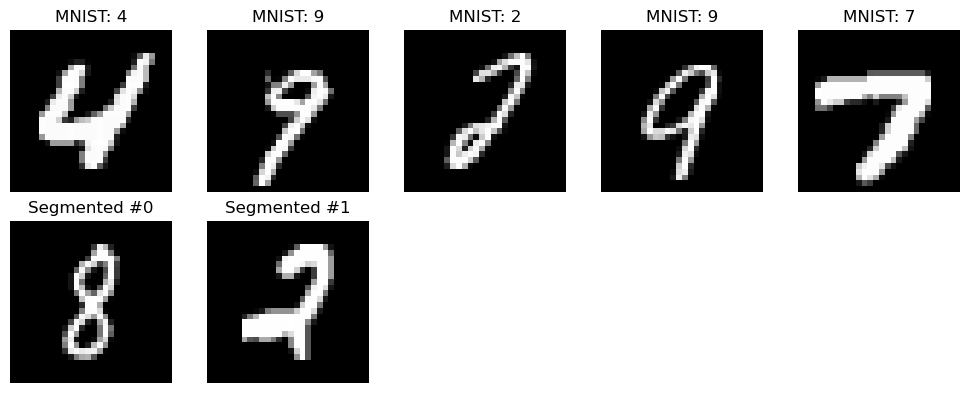

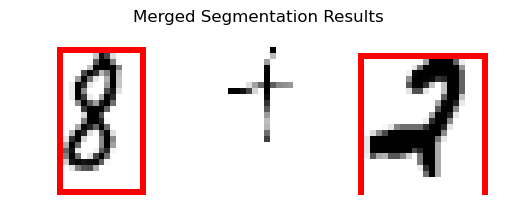

Box (8, 3, 14, 24): Classified as 8 using digit model
Box (59, 4, 21, 24): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_056.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 151, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 123, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 81, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 74, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 121, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 243, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 160, Range: [0.00, 1.00]


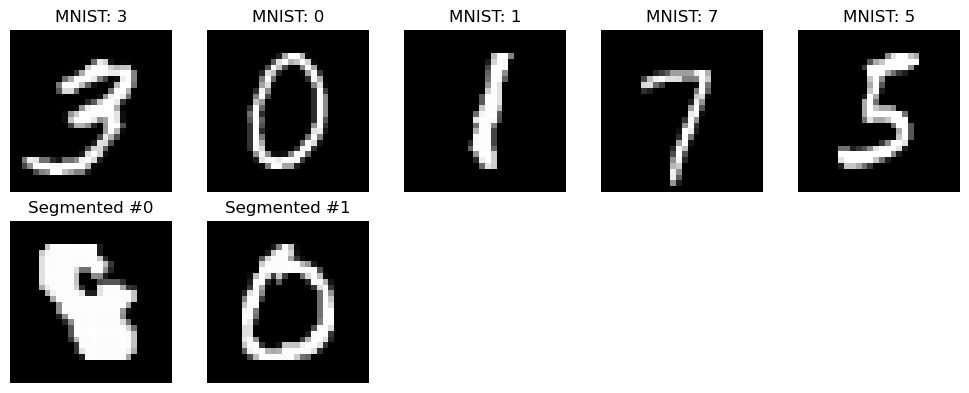

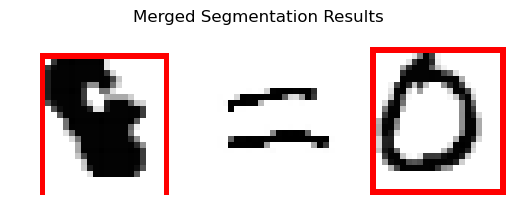

Box (5, 4, 21, 24): Classified as 8 using digit model
Box (61, 3, 22, 24): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_081.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 80, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 109, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 173, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 164, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 18, 3), Preprocessed: (28, 28), Aspect: 0.82, White pixels: 121, Range: [0.00, 1.00]
ROI #1 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 96, Range: [0.00, 0.99]
ROI #2 — Original: (22, 20, 3), Preprocessed: (28, 28), Aspect: 0.91, White pi

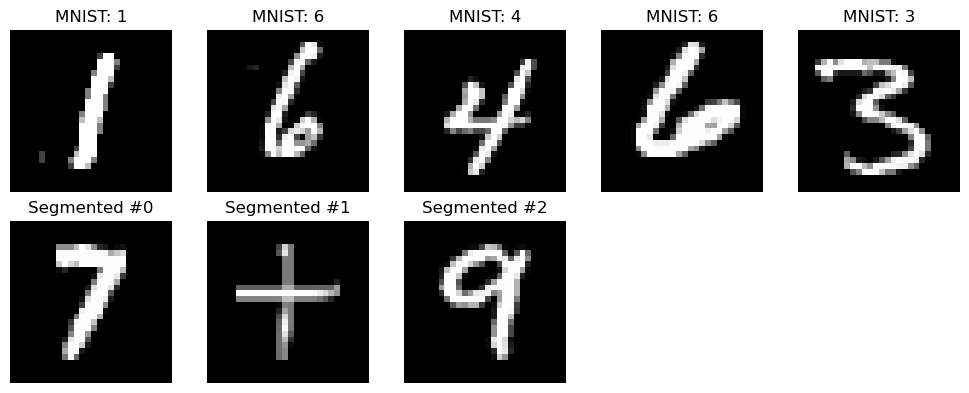

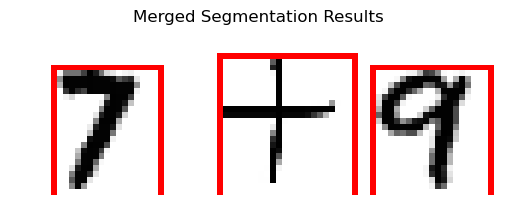

Box (7, 6, 18, 22): Classified as 2 using digit model
Box (35, 4, 23, 24): Classified as + using operator model
Box (61, 6, 20, 22): Classified as 9 using digit model
Reconstructed Expression: 2+9
Evaluation Result: 11

Processing image: expression_dataset/expr_095.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
MNIST #1 — Label: 8, Shape: (28, 28), White pixels: 195, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 166, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 138, Range: [0.00, 1.00]
ROI #1 — Original: (11, 27, 3), Preprocessed: (28, 28), Aspect: 2.45, White pixels: 73, Range: [0.00, 1.00]
ROI #2 — Original: (25, 17, 3), Preprocessed: (28, 28), Aspect: 0.68, White pixe

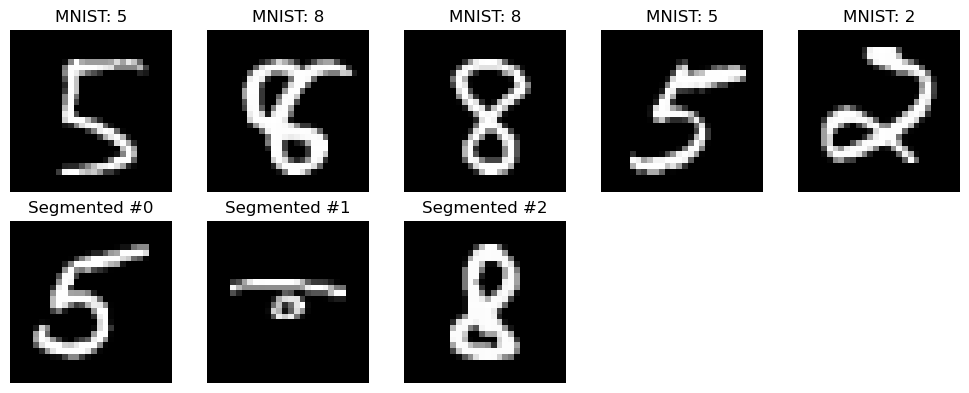

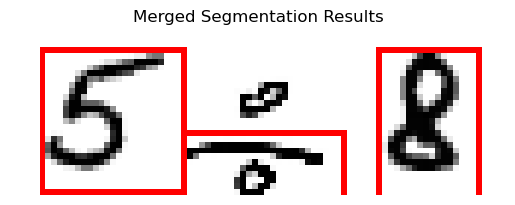

Box (5, 3, 24, 24): Classified as 5 using digit model
Box (29, 17, 27, 11): Classified as / using operator model
Box (62, 3, 17, 25): Classified as 8 using digit model
Reconstructed Expression: 5/8
Evaluation Result: 0.625

Processing image: expression_dataset/expr_091.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 61, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 175, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 79, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 131, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 17, 3), Preprocessed: (28, 28), Aspect: 0.68, White pixels: 116, Range: [0.00, 1.00]
ROI #1 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 176, Range: [0.00, 1.00]


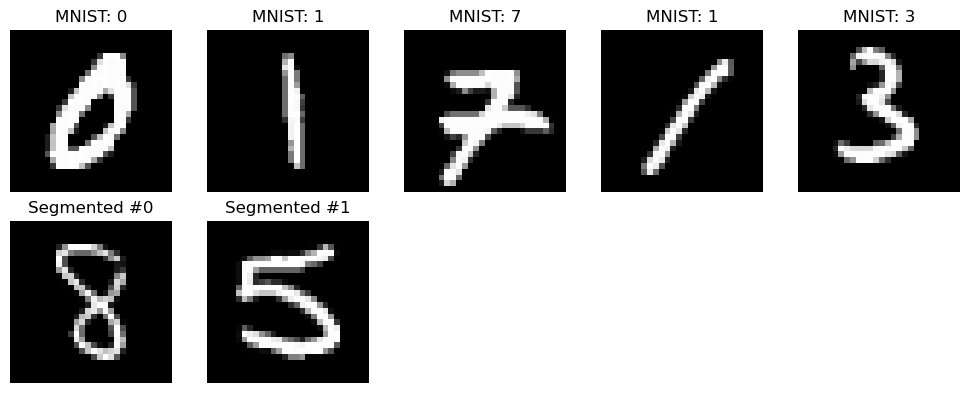

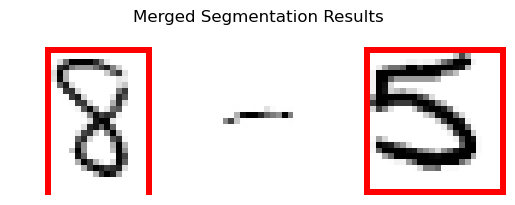

Box (6, 3, 17, 25): Classified as 8 using digit model
Box (60, 3, 23, 24): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_085.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 164, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 113, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 96, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 162, Range: [0.00, 1.00]
ROI #1 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixels: 118, Range: [0.00, 1.00]


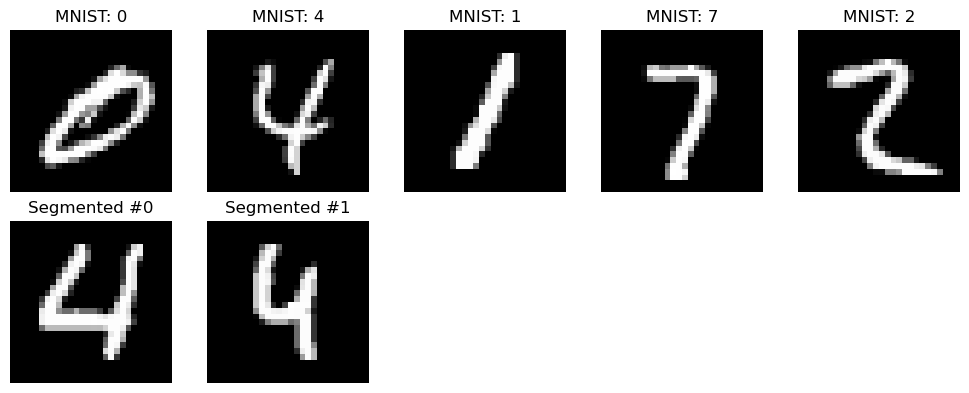

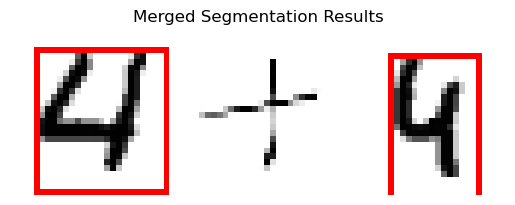

Box (4, 3, 22, 24): Classified as 4 using digit model
Box (64, 4, 15, 24): Classified as / using operator model
Reconstructed Expression: 4/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_052.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 160, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 95, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 157, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 178, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 19, 3), Preprocessed: (28, 28), Aspect: 0.79, White pixels: 127, Range: [0.00, 1.00]
ROI #1 — Original: (23, 18, 3), Preprocessed: (28, 28), Aspect: 0.78, White pixels: 103, Range: [0.00, 1.00]


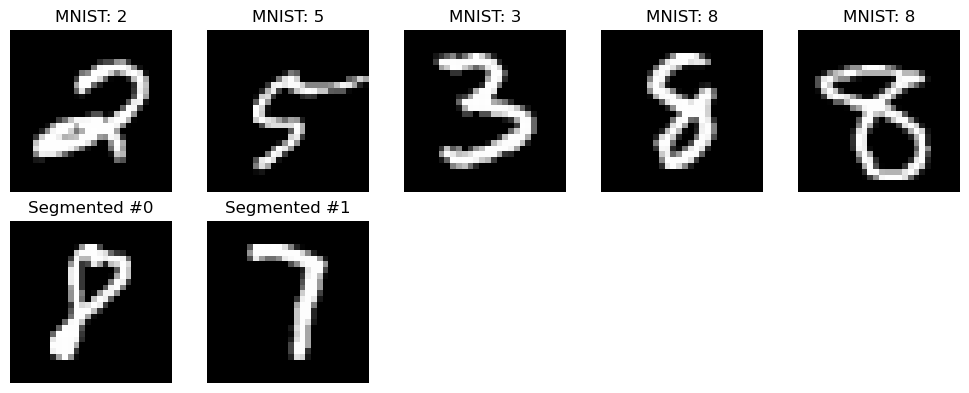

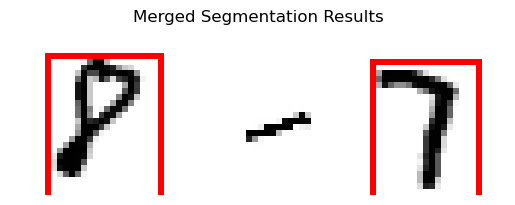

Box (6, 4, 19, 24): Classified as 8 using digit model
Box (61, 5, 18, 23): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_046.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 102, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 113, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 196, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 23, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 137, Range: [0.00, 1.00]
ROI #1 — Original: (13, 25, 3), Preprocessed: (28, 28), Aspect: 1.92, White pixels: 82, Range: [0.00, 1.00]
ROI #2 — Original: (23, 18, 3), Preprocessed: (28, 28), Aspect: 0.78, White p

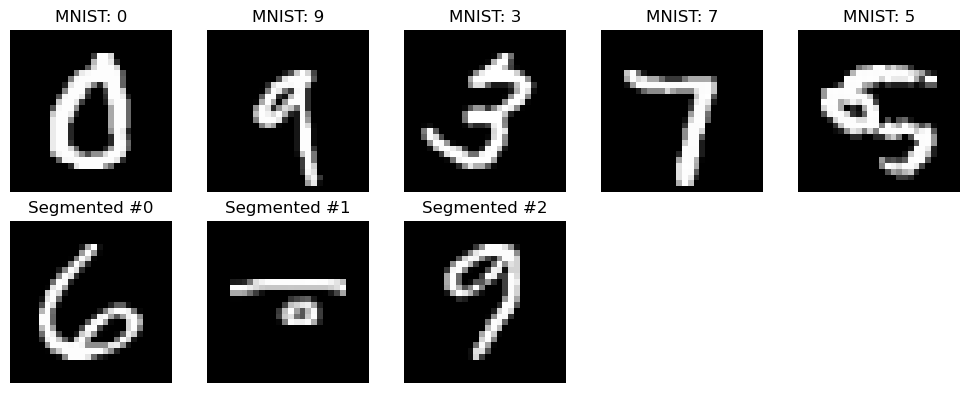

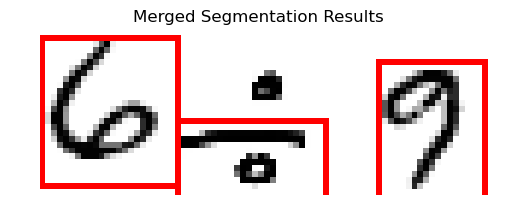

Box (5, 1, 23, 25): Classified as 6 using digit model
Box (28, 15, 25, 13): Classified as / using operator model
Box (62, 5, 18, 23): Classified as 2 using digit model
Reconstructed Expression: 6/2
Evaluation Result: 3.0

Processing image: expression_dataset/expr_047.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 164, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 125, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 103, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 283, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 196, Range: [0.00, 1.00]


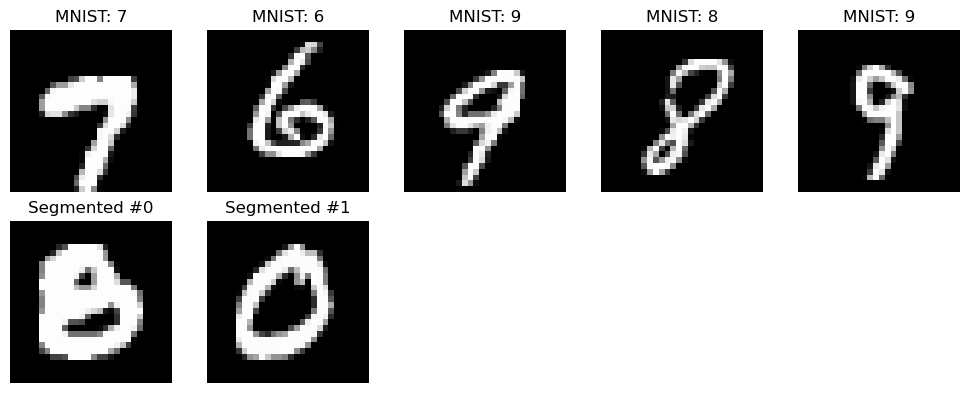

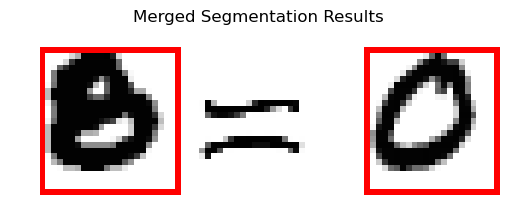

Box (5, 3, 23, 24): Classified as 8 using digit model
Box (60, 3, 22, 24): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_053.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 175, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 135, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 139, Range: [0.00, 1.00]
ROI #1 — Original: (22, 20, 3), Preprocessed: (28, 28), Aspect: 0.91, White pixels: 140, Range: [0.00, 1.00]


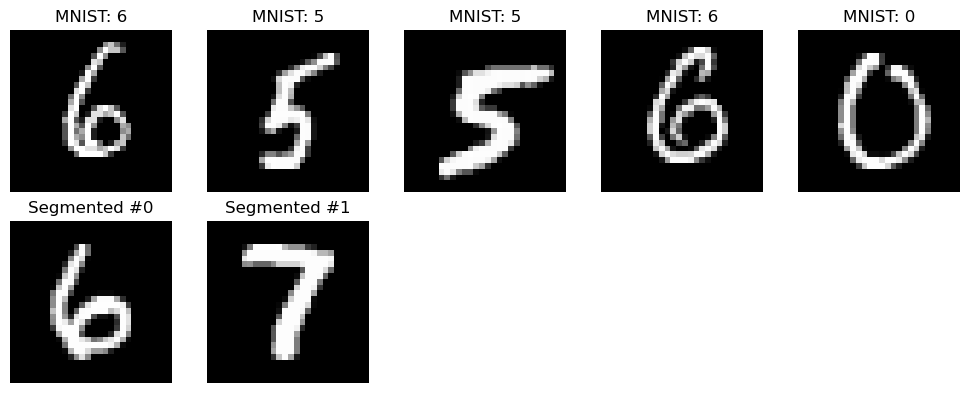

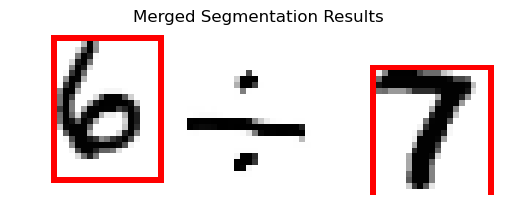

Box (7, 1, 18, 24): Classified as 6 using digit model
Box (61, 6, 20, 22): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_084.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 114, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 83, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 100, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 134, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (21, 24, 3), Preprocessed: (28, 28), Aspect: 1.14, White pixels: 126, Range: [0.00, 1.00]
ROI #1 — Original: (23, 24, 3), Preprocessed: (28, 28), Aspect: 1.04, White pixels: 195, Range: [0.00, 1.00]


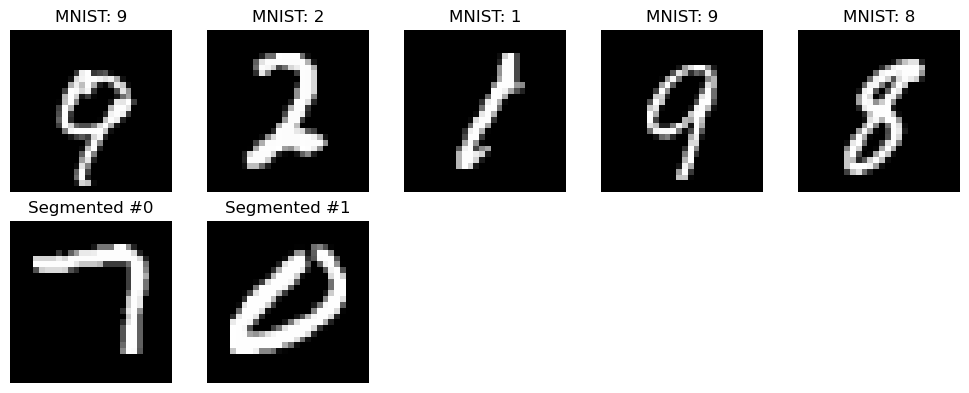

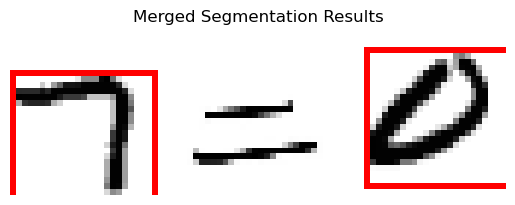

Box (0, 7, 24, 21): Classified as 0 using digit model
Box (60, 3, 24, 23): Classified as / using operator model
Reconstructed Expression: 0/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_090.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 158, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 148, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixels: 71, Range: [0.00, 1.00]
ROI #1 — Original: (22, 23, 3), Preprocessed: (28, 28), Aspect: 1.05, White pixels: 109, Range: [0.00, 1.00]
ROI #2 — Original: (26, 24, 3), Preprocessed: (28, 28), Aspect: 0.92, White p

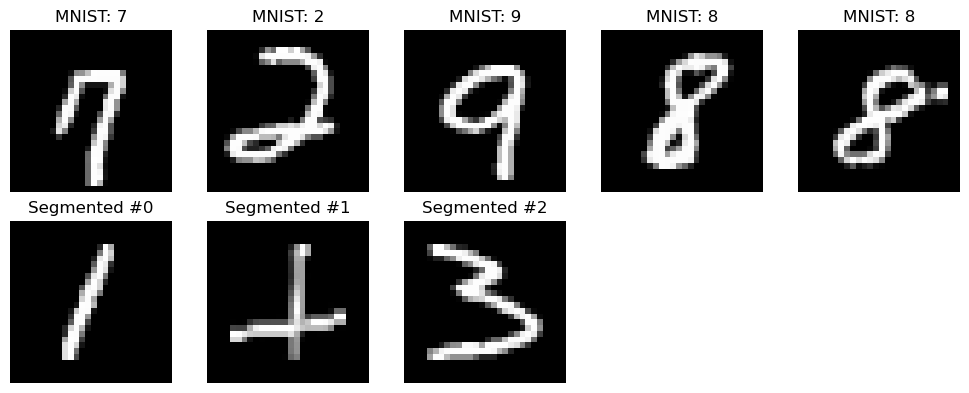

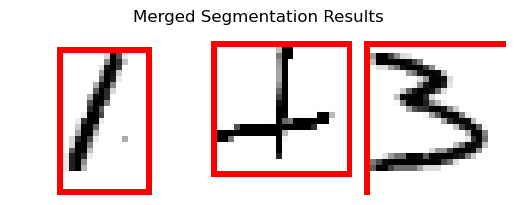

Box (8, 3, 15, 24): Classified as 1 using digit model
Box (34, 2, 23, 22): Classified as + using operator model
Box (60, 2, 24, 26): Classified as 3 using digit model
Reconstructed Expression: 1+3
Evaluation Result: 4

Processing image: expression_dataset/expr_086.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 211, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (20, 26, 3), Preprocessed: (28, 28), Aspect: 1.30, White pixels: 132, Range: [0.00, 1.00]
ROI #1 — Original: (23, 20, 3), Preprocessed: (28, 28), Aspect: 0.87, White pixels: 133, Range: [0.00, 1.00]


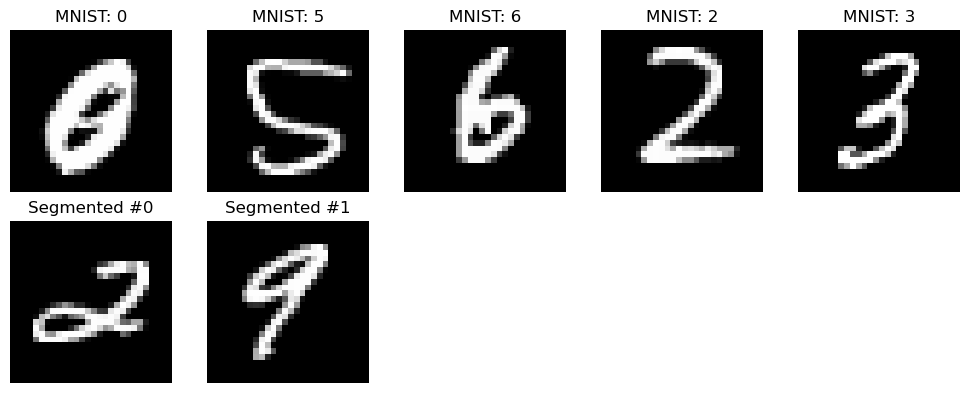

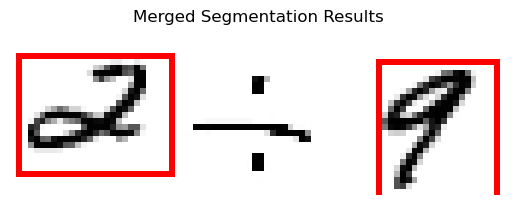

Box (1, 4, 26, 20): Classified as 2 using digit model
Box (62, 5, 20, 23): Classified as * using operator model
Reconstructed Expression: 2*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_092.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 77, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 137, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 102, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 154, Range: [0.00, 1.00]
ROI #1 — Original: (17, 16, 3), Preprocessed: (28, 28), Aspect: 0.94, White pixels: 123, Range: [0.00, 1.00]
ROI #2 — Original: (23, 21, 3), Preprocessed: (28, 28), Aspect: 0.91, White p

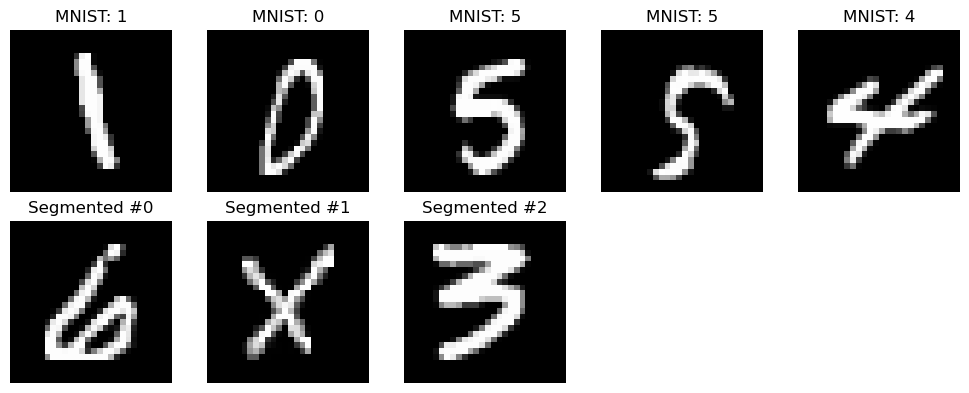

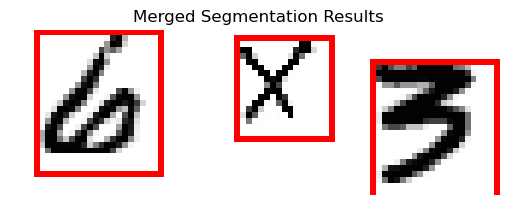

Box (4, 0, 21, 24): Classified as 6 using digit model
Box (38, 1, 16, 17): Classified as * using operator model
Box (61, 5, 21, 23): Classified as 3 using digit model
Reconstructed Expression: 6*3
Evaluation Result: 18

Processing image: expression_dataset/expr_045.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 147, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 183, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 165, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 187, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 67, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 191, Range: [0.00, 1.00]


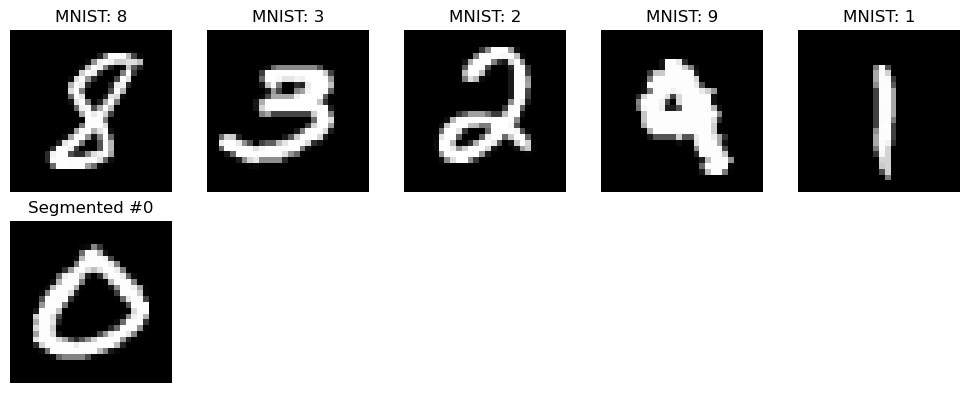

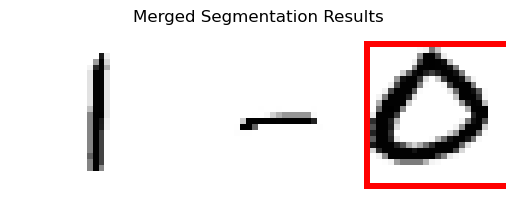

Box (60, 2, 24, 24): Classified as 0 using digit model
Reconstructed Expression: 0
Evaluation Result: 0

Processing image: expression_dataset/expr_051.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 201, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 114, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 98, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 21, 3), Preprocessed: (28, 28), Aspect: 0.95, White pixels: 163, Range: [0.00, 1.00]
ROI #1 — Original: (22, 19, 3), Preprocessed: (28, 28), Aspect: 0.86, White pixels: 94, Range: [0.00, 1.00]
ROI #2 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 205, Range: [0.00, 1.00]


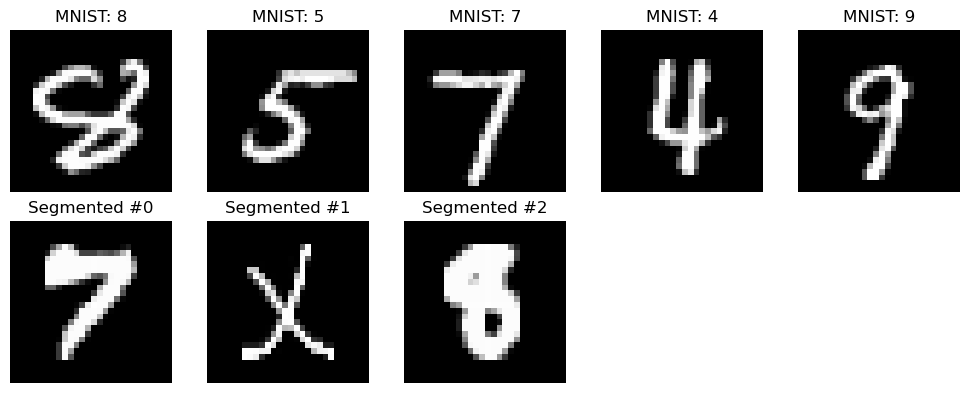

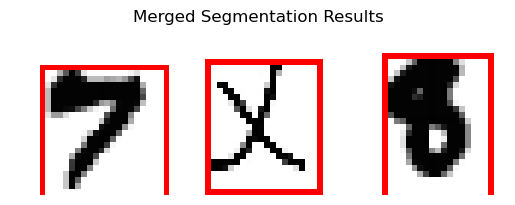

Box (5, 6, 21, 22): Classified as 2 using digit model
Box (33, 5, 19, 22): Classified as * using operator model
Box (63, 4, 18, 24): Classified as 8 using digit model
Reconstructed Expression: 2*8
Evaluation Result: 16

Processing image: expression_dataset/expr_079.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 105, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 59, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 210, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 146, Range: [0.00, 1.00]
ROI #1 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 117, Range: [0.00, 1.00]


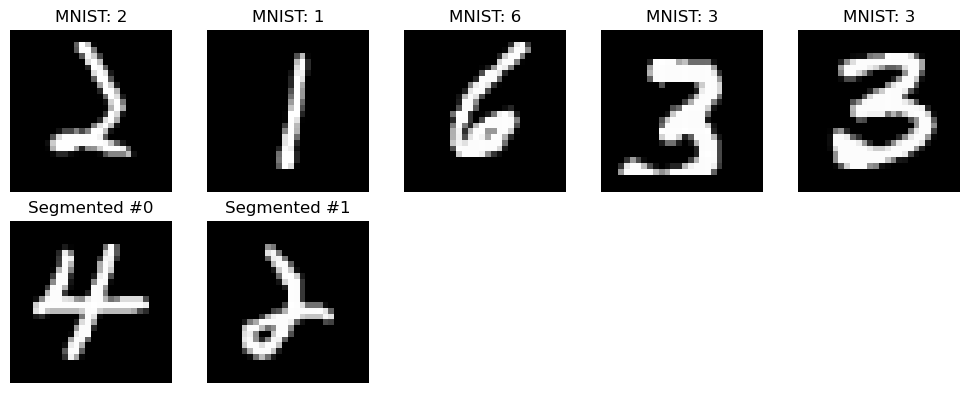

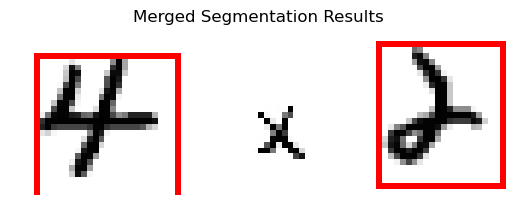

Box (4, 4, 24, 24): Classified as 4 using digit model
Box (62, 2, 21, 24): Classified as / using operator model
Reconstructed Expression: 4/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_078.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 90, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 155, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 249, Range: [0.00, 1.00]
ROI #1 — Original: (21, 21, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 135, Range: [0.00, 1.00]
ROI #2 — Original: (22, 16, 3), Preprocessed: (28, 28), Aspect: 0.73, White p

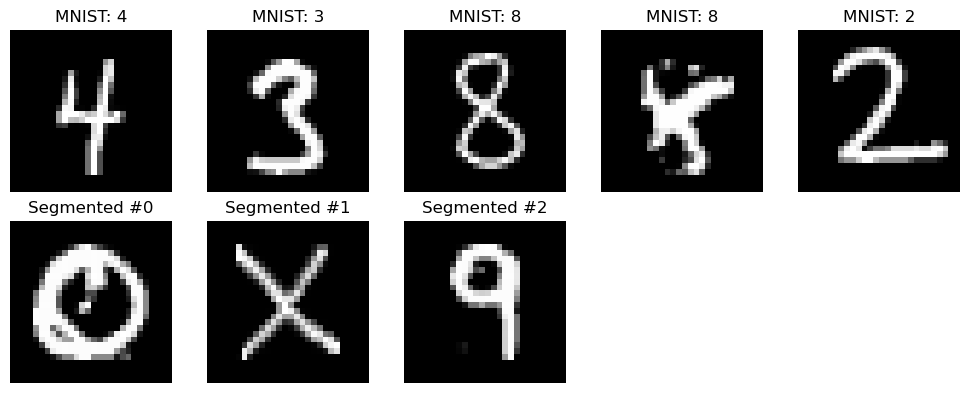

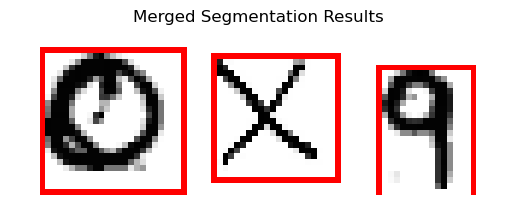

Box (5, 3, 24, 24): Classified as 0 using digit model
Box (34, 4, 21, 21): Classified as * using operator model
Box (62, 6, 16, 22): Classified as 9 using digit model
Reconstructed Expression: 0*9
Evaluation Result: 0

Processing image: expression_dataset/expr_050.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 180, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 119, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 22, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 111, Range: [0.00, 1.00]
ROI #1 — Original: (26, 22, 3), Preprocessed: (28, 28), Aspect: 0.85, White pixels: 70, Range: [0.00, 1.00]
ROI #2 — Original: (24, 10, 3), Preprocessed: (28, 28), Aspect: 0.42, White pixels

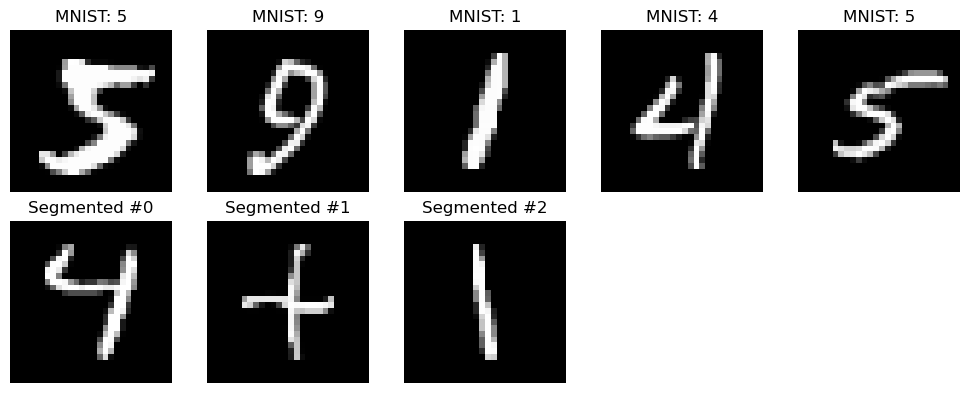

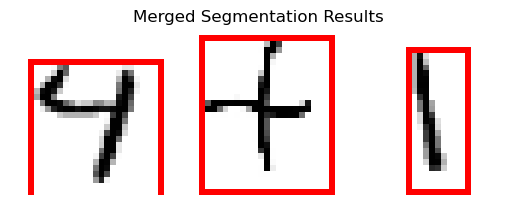

Box (3, 5, 22, 23): Classified as 7 using digit model
Box (32, 1, 22, 26): Classified as + using operator model
Box (67, 3, 10, 24): Classified as 1 using digit model
Reconstructed Expression: 7+1
Evaluation Result: 8

Processing image: expression_dataset/expr_044.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 73, Range: [0.00, 1.00]
MNIST #1 — Label: 8, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 90, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 195, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 169, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 12, 3), Preprocessed: (28, 28), Aspect: 0.50, White pixels: 101, Range: [0.00, 1.00]
ROI #1 — Original: (19, 27, 3), Preprocessed: (28, 28), Aspect: 1.42, White pixels: 73, Range: [0.00, 1.00]
ROI #2 — Original: (21, 24, 3), Preprocessed: (28, 28), Aspect: 1.14, White pixels:

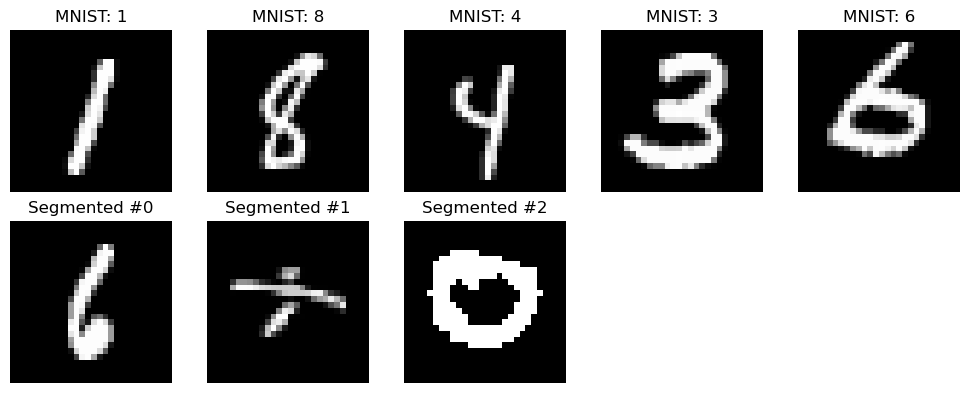

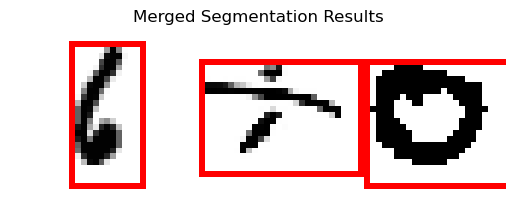

Box (10, 2, 12, 24): Classified as 6 using digit model
Box (32, 5, 27, 19): Classified as * using operator model
Box (60, 5, 24, 21): Classified as 0 using digit model
Reconstructed Expression: 6*0
Evaluation Result: 0

Processing image: expression_dataset/expr_093.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 116, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 138, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 18, 3), Preprocessed: (28, 28), Aspect: 0.72, White pixels: 103, Range: [0.00, 1.00]
ROI #1 — Original: (26, 24, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 65, Range: [0.00, 1.00]
ROI #2 — Original: (25, 16, 3), Preprocessed: (28, 28), Aspect: 0.64, White pixe

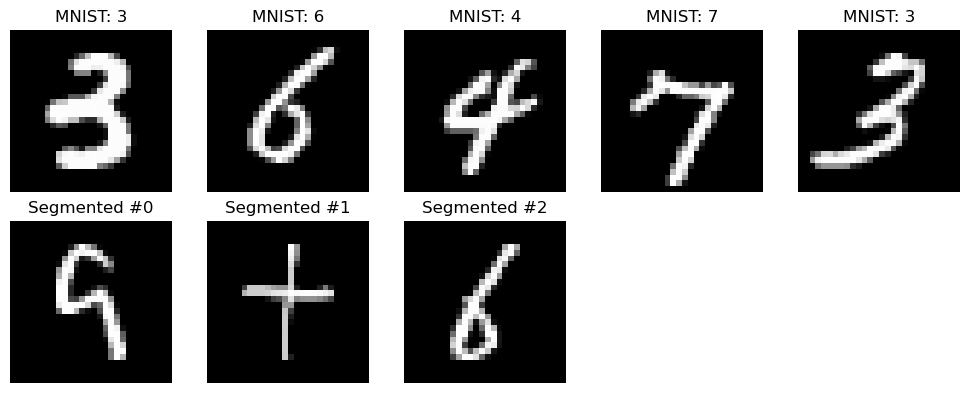

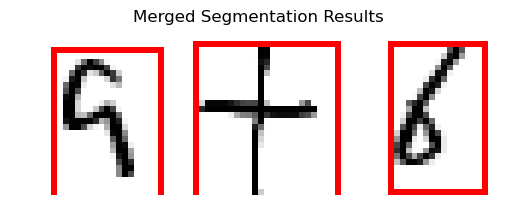

Box (7, 3, 18, 25): Classified as 5 using digit model
Box (31, 2, 24, 26): Classified as + using operator model
Box (64, 2, 16, 25): Classified as 6 using digit model
Reconstructed Expression: 5+6
Evaluation Result: 11

Processing image: expression_dataset/expr_087.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 155, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 22, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 122, Range: [0.00, 1.00]
ROI #1 — Original: (22, 23, 3), Preprocessed: (28, 28), Aspect: 1.05, White pixels: 67, Range: [0.00, 1.00]
ROI #2 — Original: (25, 20, 3), Preprocessed: (28, 28), Aspect: 0.80, White pixel

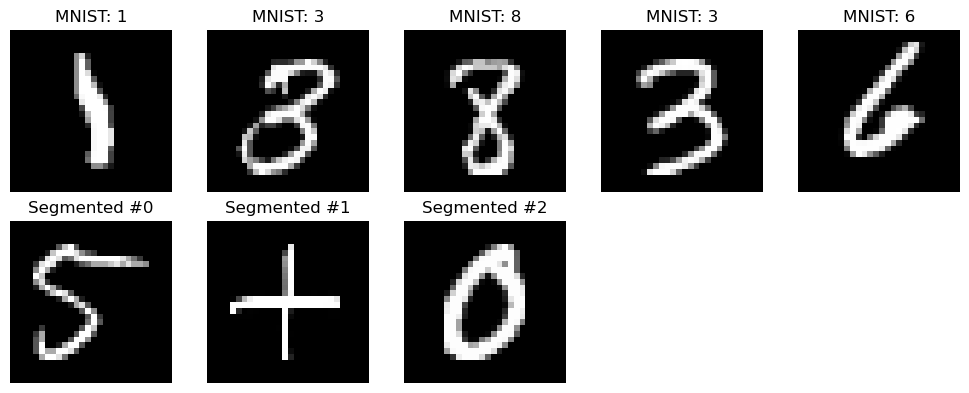

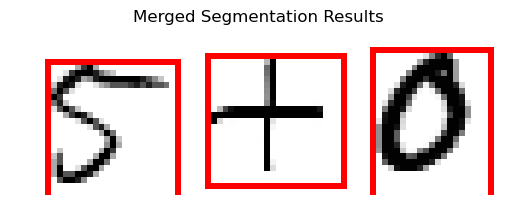

Box (6, 5, 22, 23): Classified as 5 using digit model
Box (33, 4, 23, 22): Classified as + using operator model
Box (61, 3, 20, 25): Classified as 0 using digit model
Reconstructed Expression: 5+0
Evaluation Result: 5

Processing image: expression_dataset/expr_023.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 125, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 92, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 103, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 11, 3), Preprocessed: (28, 28), Aspect: 0.46, White pixels: 82, Range: [0.00, 1.00]
ROI #1 — Original: (20, 24, 3), Preprocessed: (28, 28), Aspect: 1.20, White pixels: 126, Range: [0.00, 1.00]


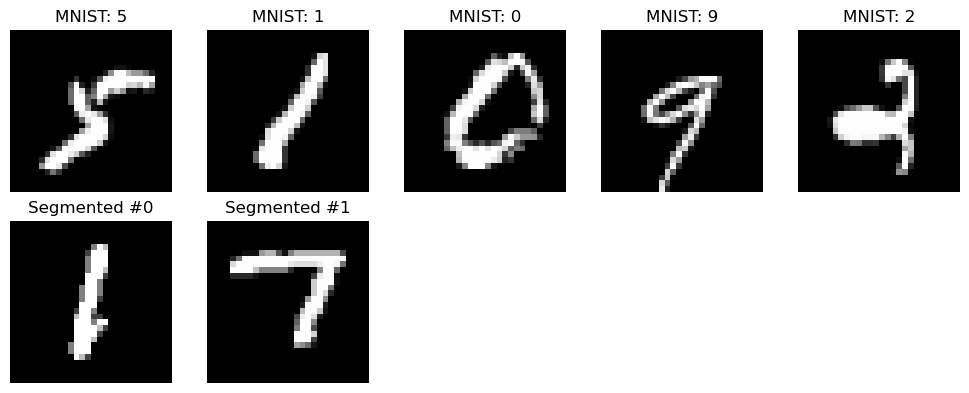

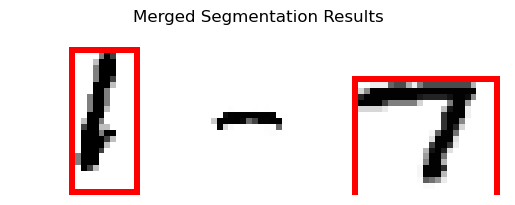

Box (10, 3, 11, 24): Classified as 1 using digit model
Box (58, 8, 24, 20): Classified as * using operator model
Reconstructed Expression: 1*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_037.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 157, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 80, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 165, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 129, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 12, 3), Preprocessed: (28, 28), Aspect: 0.52, White pixels: 106, Range: [0.00, 1.00]
ROI #1 — Original: (12, 27, 3), Preprocessed: (28, 28), Aspect: 2.25, White pixels: 88, Range: [0.00, 1.00]
ROI #2 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White p

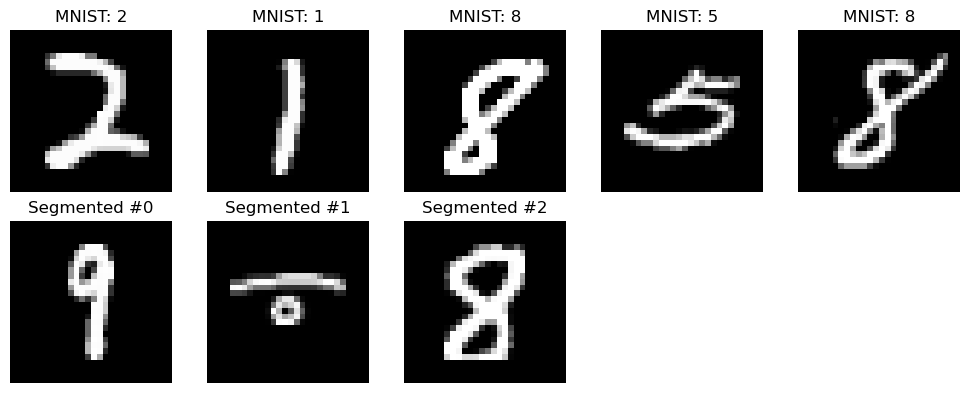

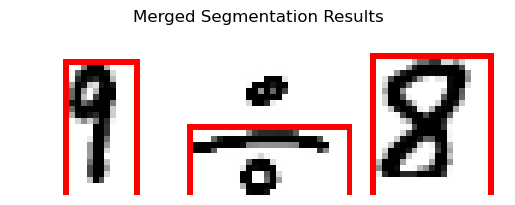

Box (9, 5, 12, 23): Classified as 1 using digit model
Box (30, 16, 27, 12): Classified as / using operator model
Box (61, 4, 20, 24): Classified as 8 using digit model
Reconstructed Expression: 1/8
Evaluation Result: 0.125

Processing image: expression_dataset/expr_036.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 93, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 105, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 11, 3), Preprocessed: (28, 28), Aspect: 0.44, White pixels: 63, Range: [0.00, 1.00]
ROI #1 — Original: (25, 19, 3), Preprocessed: (28, 28), Aspect: 0.76, White pixels: 116, Range: [0.00, 1.00]


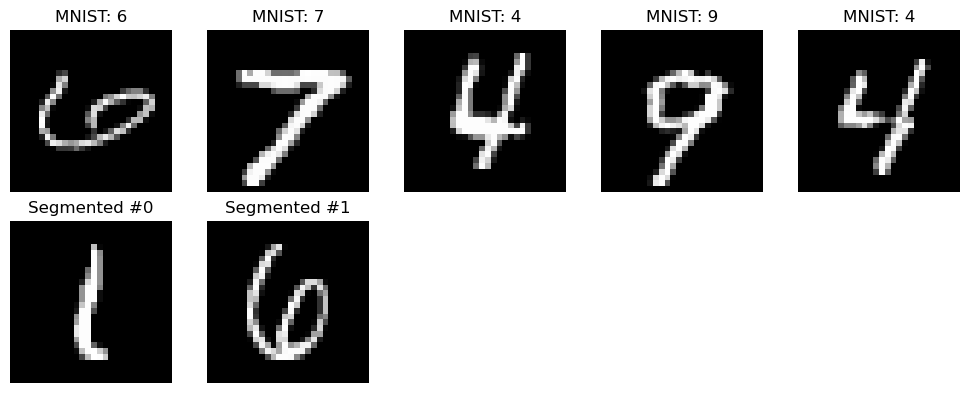

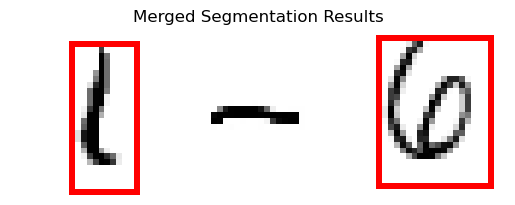

Box (10, 2, 11, 25): Classified as 1 using digit model
Box (62, 1, 19, 25): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_022.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 164, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixels: 62, Range: [0.00, 1.00]
ROI #1 — Original: (11, 22, 3), Preprocessed: (28, 28), Aspect: 2.00, White pixels: 44, Range: [0.00, 1.00]
ROI #2 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White p

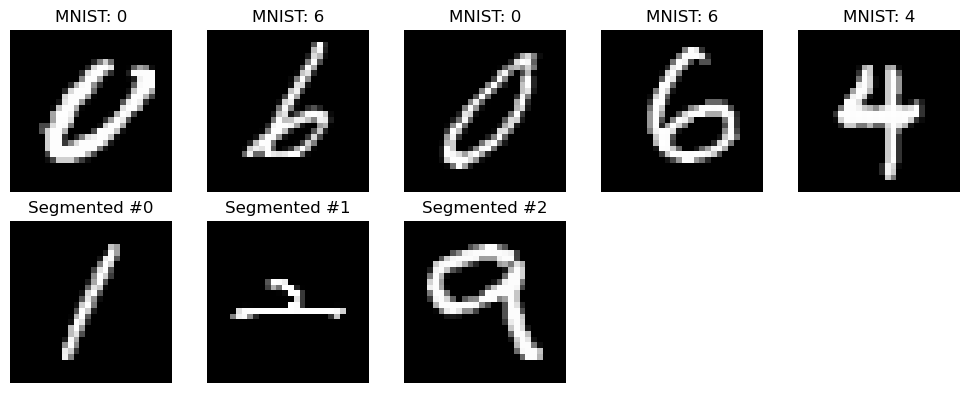

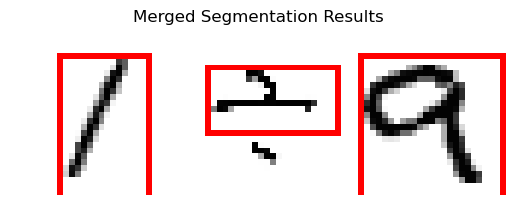

Box (8, 4, 15, 24): Classified as 1 using digit model
Box (33, 6, 22, 11): Classified as / using operator model
Box (59, 4, 24, 24): Classified as 3 using digit model
Reconstructed Expression: 1/3
Evaluation Result: 0.3333333333333333

Processing image: expression_dataset/expr_008.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 148, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 13, 3), Preprocessed: (28, 28), Aspect: 0.54, White pixels: 81, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 169, Range: [0.00, 1.00]


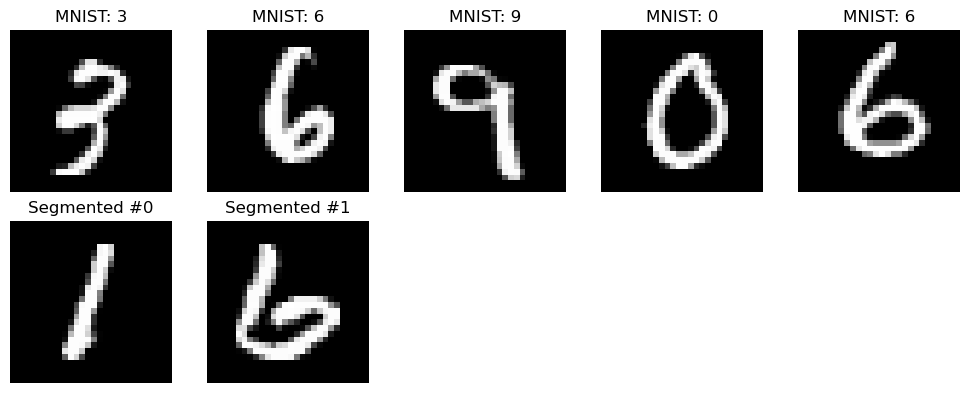

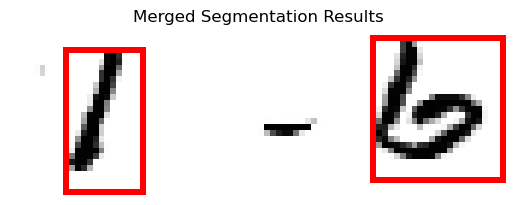

Box (9, 3, 13, 24): Classified as 1 using digit model
Box (61, 1, 22, 24): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_034.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 151, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 166, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 73, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels: 143, Range: [0.00, 1.00]
ROI #1 — Original: (14, 28, 3), Preprocessed: (28, 28), Aspect: 2.00, White pixels: 72, Range: [0.00, 1.00]
ROI #2 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pi

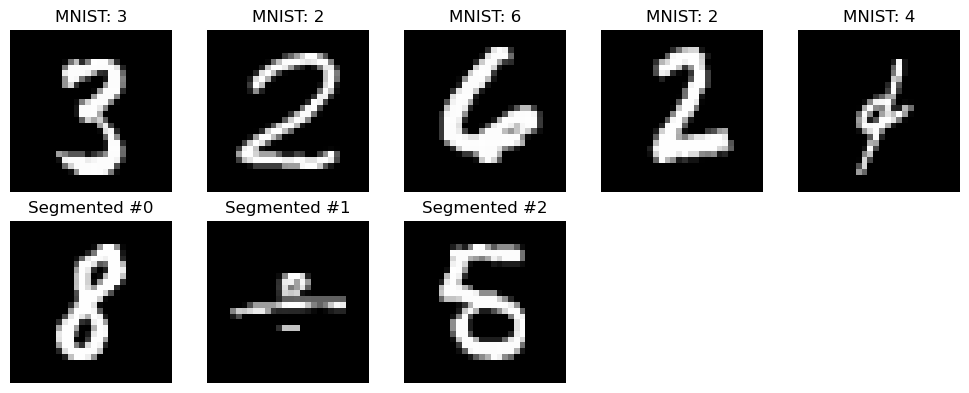

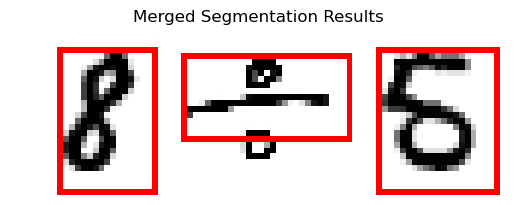

Box (8, 3, 16, 24): Classified as 8 using digit model
Box (29, 4, 28, 14): Classified as / using operator model
Box (62, 3, 20, 24): Classified as 5 using digit model
Reconstructed Expression: 8/5
Evaluation Result: 1.6

Processing image: expression_dataset/expr_020.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 173, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 209, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 197, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 163, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 85, Range: [0.00, 1.00]
ROI #1 — Original: (25, 20, 3), Preprocessed: (28, 28), Aspect: 0.80, White pixels: 67, Range: [0.00, 1.00]
ROI #2 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixe

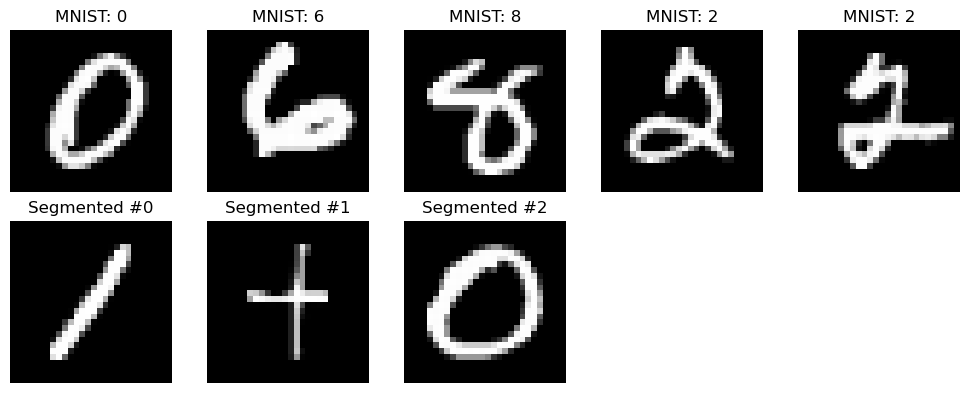

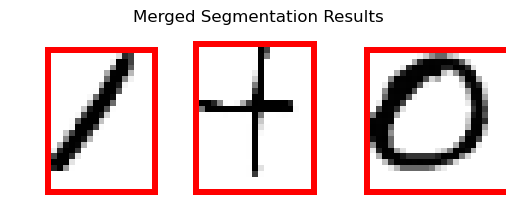

Box (6, 3, 18, 24): Classified as 1 using digit model
Box (31, 2, 20, 25): Classified as + using operator model
Box (60, 3, 24, 24): Classified as 0 using digit model
Reconstructed Expression: 1+0
Evaluation Result: 1

Processing image: expression_dataset/expr_021.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 185, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 135, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 125, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 193, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 20, 3), Preprocessed: (28, 28), Aspect: 0.87, White pixels: 164, Range: [0.00, 1.00]
ROI #1 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 158, Range: [0.00, 1.00]


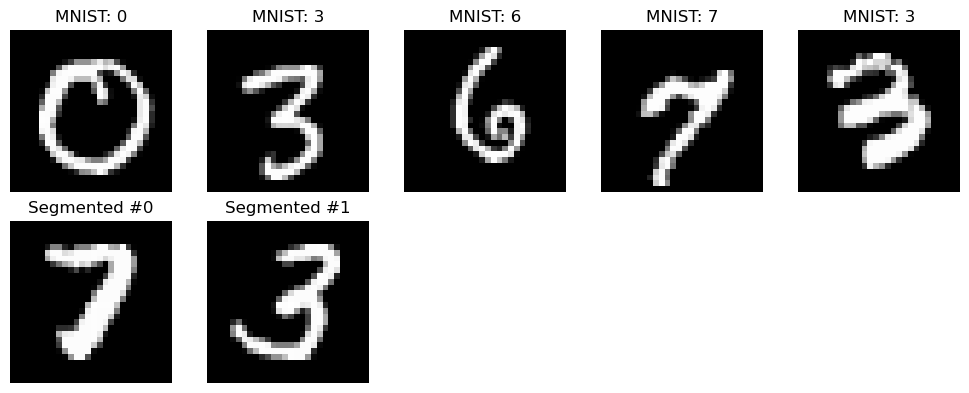

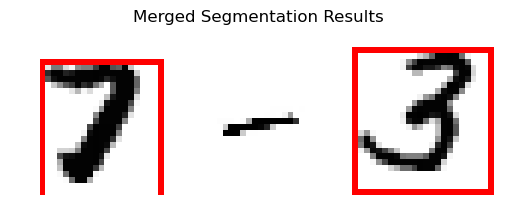

Box (5, 5, 20, 23): Classified as 2 using digit model
Box (58, 3, 23, 24): Classified as / using operator model
Reconstructed Expression: 2/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_035.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 93, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 93, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 158, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixels: 76, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 139, Range: [0.00, 1.00]


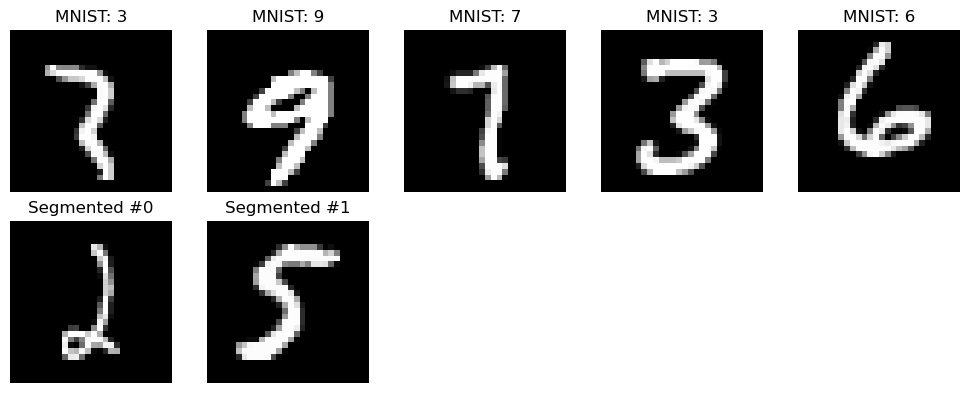

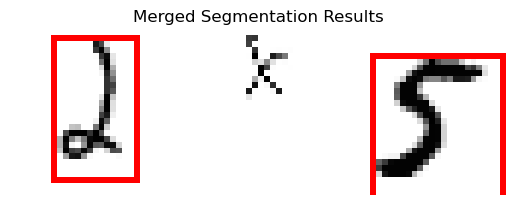

Box (7, 1, 14, 24): Classified as 2 using digit model
Box (61, 4, 22, 24): Classified as * using operator model
Reconstructed Expression: 2*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_009.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 197, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 17, 3), Preprocessed: (28, 28), Aspect: 0.74, White pixels: 108, Range: [0.00, 1.00]
ROI #1 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels: 102, Range: [0.00, 1.00]


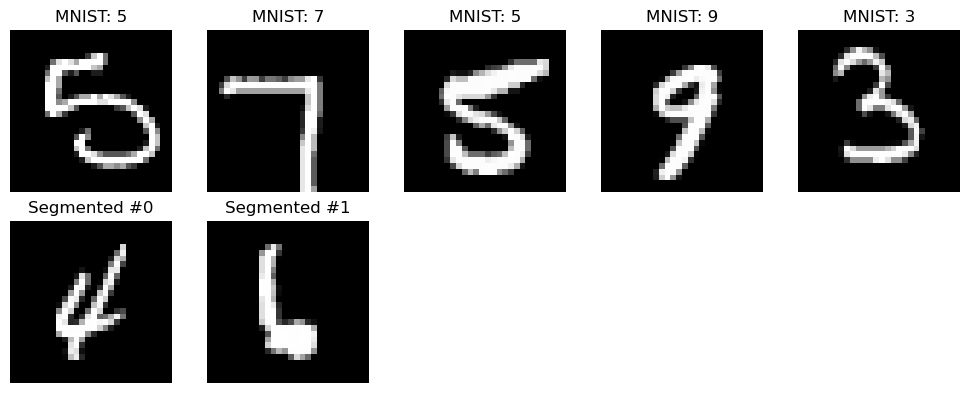

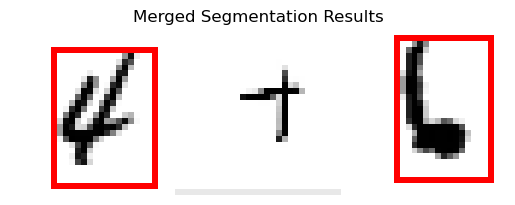

Box (7, 3, 17, 23): Classified as 4 using digit model
Box (65, 1, 16, 24): Classified as / using operator model
Reconstructed Expression: 4/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_031.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 82, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 14, 3), Preprocessed: (28, 28), Aspect: 0.64, White pixels: 80, Range: [0.00, 1.00]
ROI #1 — Original: (23, 20, 3), Preprocessed: (28, 28), Aspect: 0.87, White pixels: 128, Range: [0.00, 1.00]


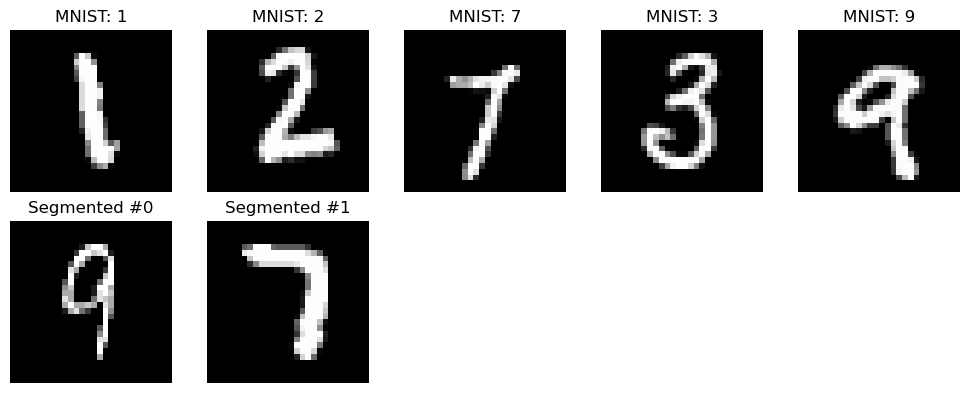

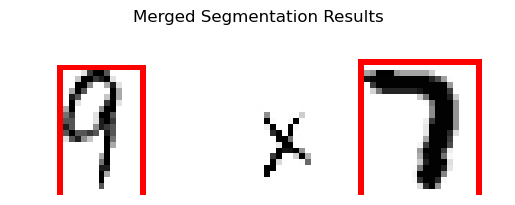

Box (8, 6, 14, 22): Classified as 9 using digit model
Box (59, 5, 20, 23): Classified as / using operator model
Reconstructed Expression: 9/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_025.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 216, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 69, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 188, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 154, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 121, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 15, 3), Preprocessed: (28, 28), Aspect: 0.60, White pixels: 93, Range: [0.00, 1.00]
ROI #1 — Original: (24, 10, 3), Preprocessed: (28, 28), Aspect: 0.42, White pixels: 55, Range: [0.00, 1.00]


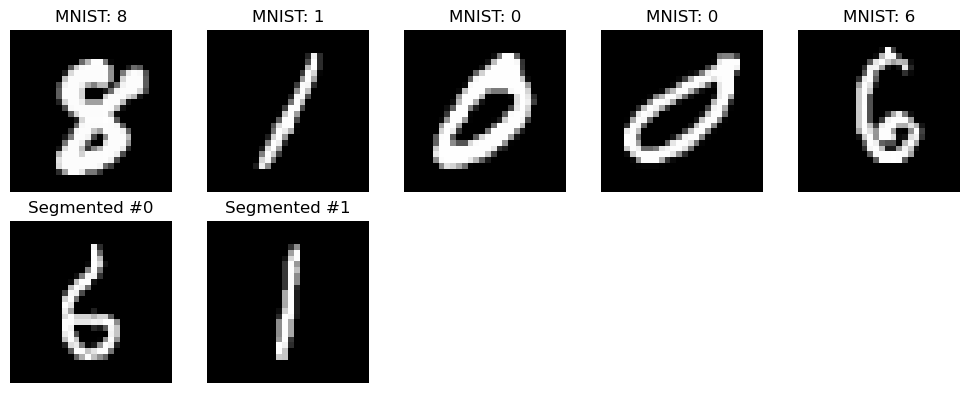

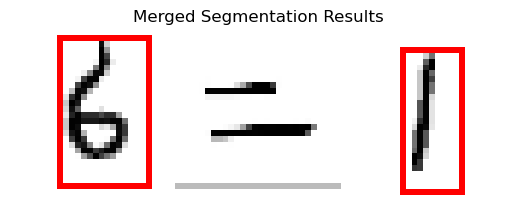

Box (8, 1, 15, 25): Classified as 6 using digit model
Box (66, 3, 10, 24): Classified as + using operator model
Reconstructed Expression: 6+
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_019.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 151, Range: [0.00, 1.00]
ROI #1 — Original: (20, 21, 3), Preprocessed: (28, 28), Aspect: 1.05, White pixels: 103, Range: [0.00, 1.00]
ROI #2 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White 

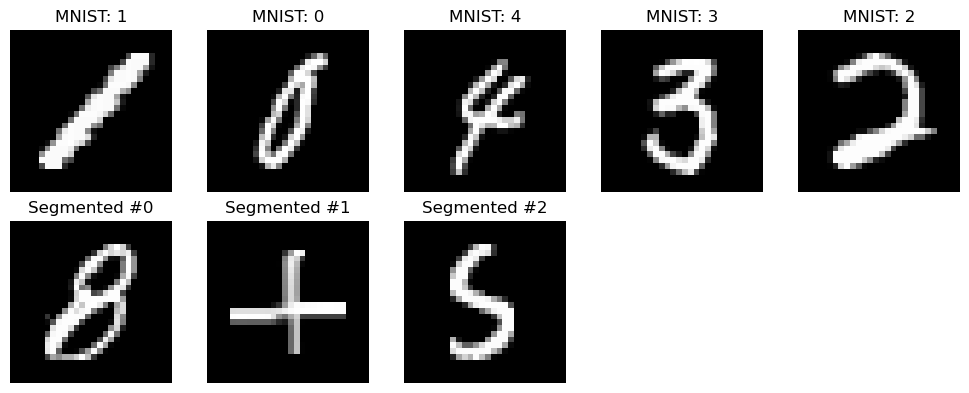

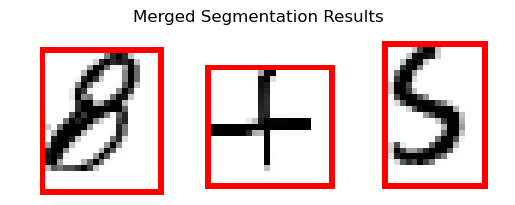

Box (5, 3, 20, 24): Classified as 8 using digit model
Box (33, 6, 21, 20): Classified as + using operator model
Box (63, 2, 17, 24): Classified as 5 using digit model
Reconstructed Expression: 8+5
Evaluation Result: 13

Processing image: expression_dataset/expr_018.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 138, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 159, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 21, 3), Preprocessed: (28, 28), Aspect: 0.91, White pixels: 139, Range: [0.00, 1.00]
ROI #1 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White pixels: 160, Range: [0.00, 1.00]


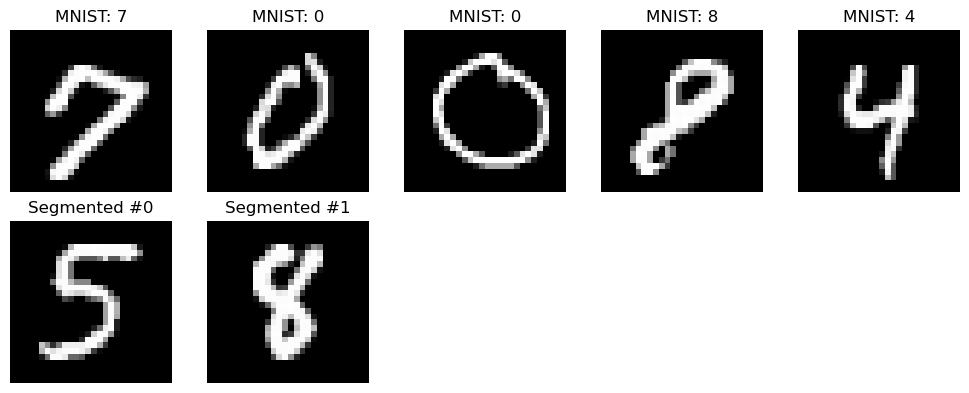

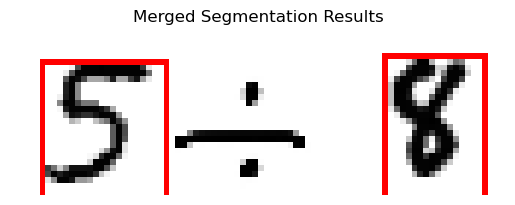

Box (5, 5, 21, 23): Classified as 5 using digit model
Box (63, 4, 17, 24): Classified as / using operator model
Reconstructed Expression: 5/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_024.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #1 — Label: 8, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 119, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 191, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 175, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White pixels: 98, Range: [0.00, 1.00]
ROI #1 — Original: (20, 20, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 126, Range: [0.00, 1.00]
ROI #2 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White p

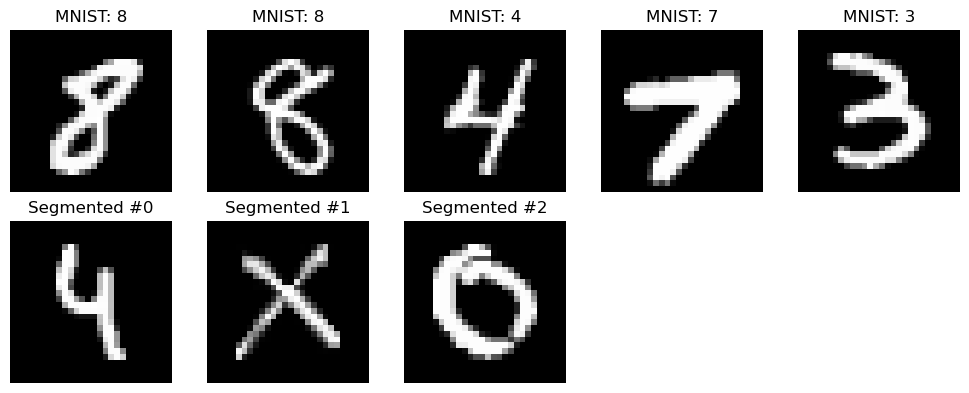

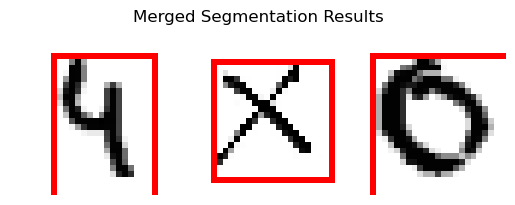

Box (7, 4, 17, 24): Classified as 4 using digit model
Box (34, 5, 20, 20): Classified as * using operator model
Box (61, 4, 23, 24): Classified as 0 using digit model
Reconstructed Expression: 4*0
Evaluation Result: 0

Processing image: expression_dataset/expr_030.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 91, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 84, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 81, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 45, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 142, Range: [0.00, 1.00]
ROI #1 — Original: (22, 21, 3), Preprocessed: (28, 28), Aspect: 0.95, White pixels: 110, Range: [0.00, 1.00]
ROI #2 — Original: (22, 25, 3), Preprocessed: (28, 28), Aspect: 1.14, White pixels: 

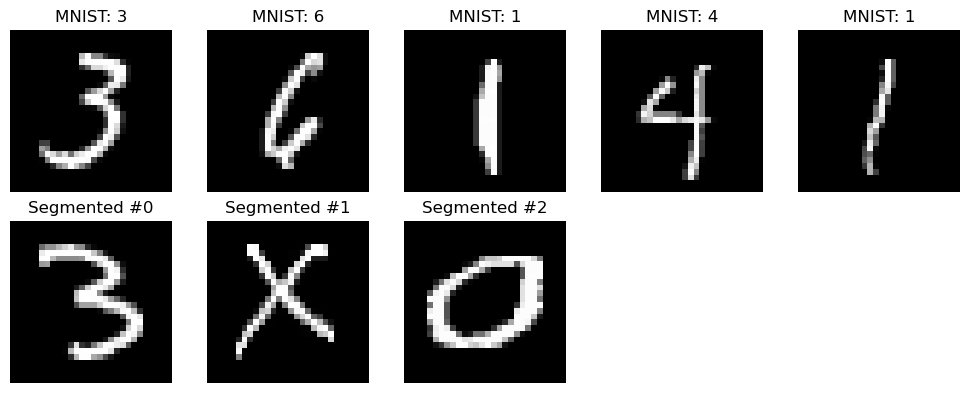

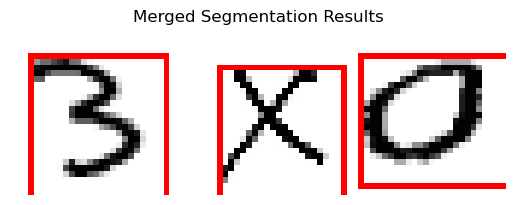

Box (3, 4, 23, 24): Classified as 3 using digit model
Box (35, 6, 21, 22): Classified as * using operator model
Box (59, 4, 25, 22): Classified as 0 using digit model
Reconstructed Expression: 3*0
Evaluation Result: 0

Processing image: expression_dataset/expr_026.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 190, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 200, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 147, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 160, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 139, Range: [0.00, 1.00]
ROI #1 — Original: (18, 20, 3), Preprocessed: (28, 28), Aspect: 1.11, White pixels: 87, Range: [0.00, 1.00]
ROI #2 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixel

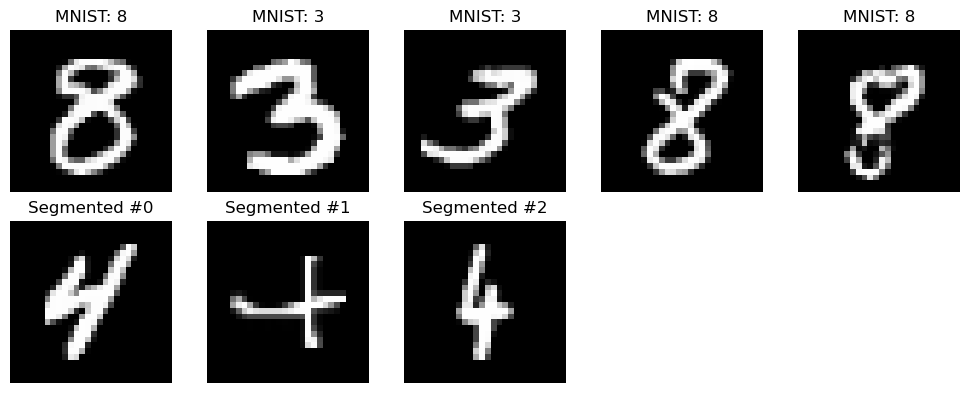

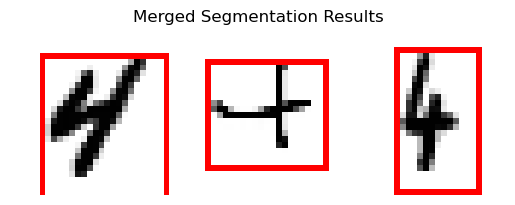

Box (5, 4, 21, 24): Classified as 4 using digit model
Box (33, 5, 20, 18): Classified as + using operator model
Box (65, 3, 14, 24): Classified as 4 using digit model
Reconstructed Expression: 4+4
Evaluation Result: 8

Processing image: expression_dataset/expr_032.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 180, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 89, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 102, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 66, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (18, 24, 3), Preprocessed: (28, 28), Aspect: 1.33, White pixels: 102, Range: [0.00, 1.00]
ROI #1 — Original: (20, 23, 3), Preprocessed: (28, 28), Aspect: 1.15, White pixels: 112, Range: [0.00, 1.00]


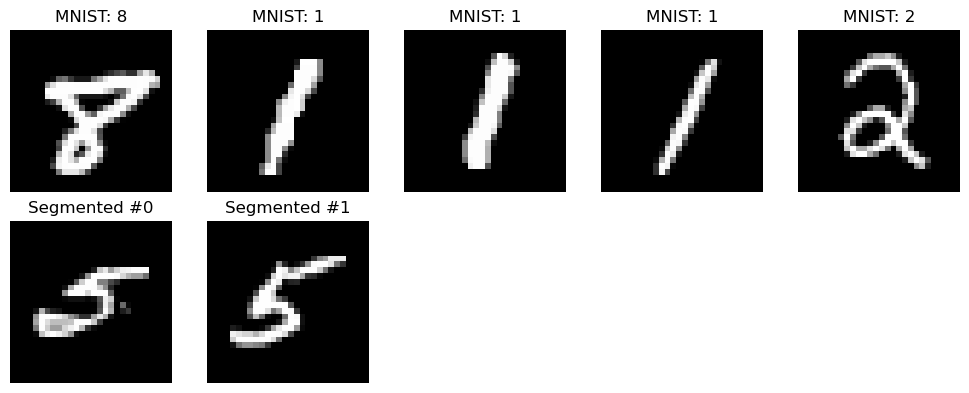

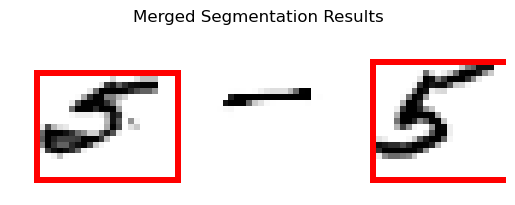

Box (4, 7, 24, 18): Classified as 5 using digit model
Box (61, 5, 23, 20): Classified as * using operator model
Reconstructed Expression: 5*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_033.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 163, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 116, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 129, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White pixels: 122, Range: [0.00, 1.00]
ROI #1 — Original: (17, 24, 3), Preprocessed: (28, 28), Aspect: 1.41, White pixels: 74, Range: [0.00, 1.00]
ROI #2 — Original: (23, 17, 3), Preprocessed: (28, 28), Aspect: 0.74, White pi

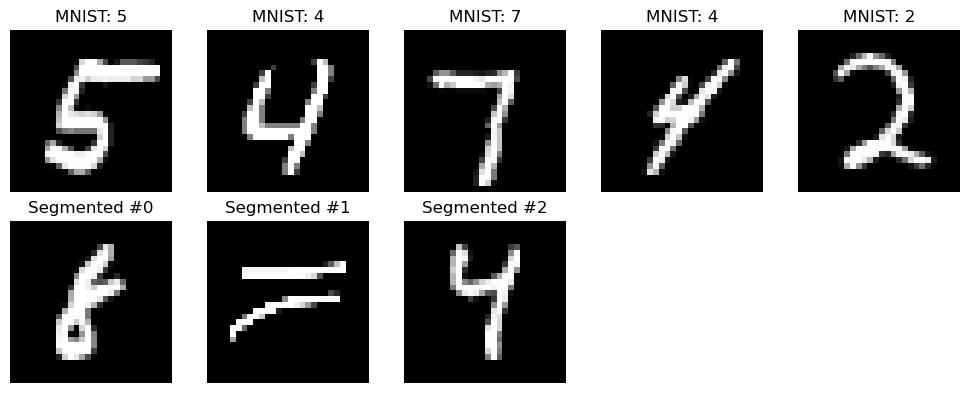

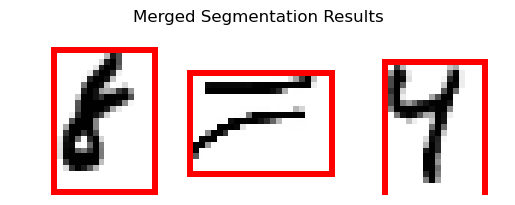

Box (7, 3, 17, 24): Classified as 8 using digit model
Box (30, 7, 24, 17): Classified as * using operator model
Box (63, 5, 17, 23): Classified as 7 using digit model
Reconstructed Expression: 8*7
Evaluation Result: 56

Processing image: expression_dataset/expr_027.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 172, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 116, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 101, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 227, Range: [0.00, 1.00]
ROI #1 — Original: (24, 12, 3), Preprocessed: (28, 28), Aspect: 0.50, White pixels: 79, Range: [0.00, 1.00]


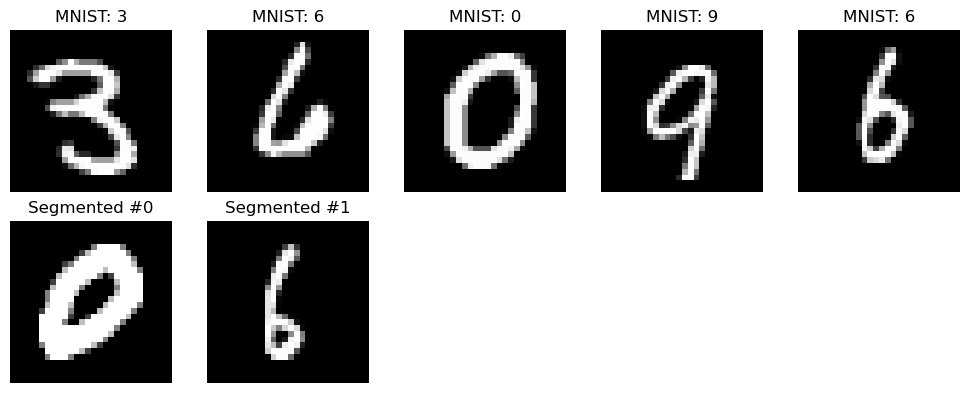

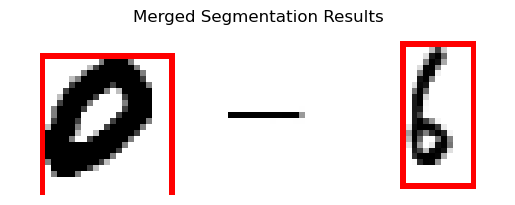

Box (5, 4, 22, 24): Classified as 0 using digit model
Box (66, 2, 12, 24): Classified as / using operator model
Reconstructed Expression: 0/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_002.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 62, Range: [0.00, 1.00]
MNIST #1 — Label: 8, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
MNIST #3 — Label: 9, Shape: (28, 28), White pixels: 127, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 204, Range: [0.00, 1.00]
ROI #1 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels: 104, Range: [0.00, 1.00]


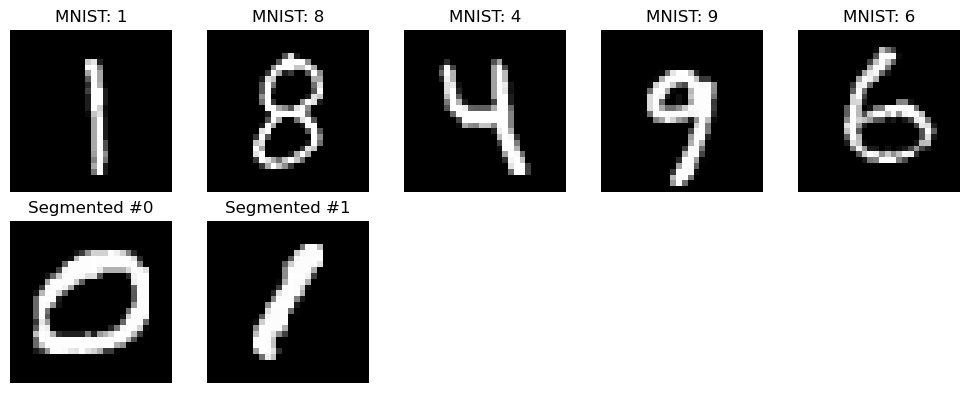

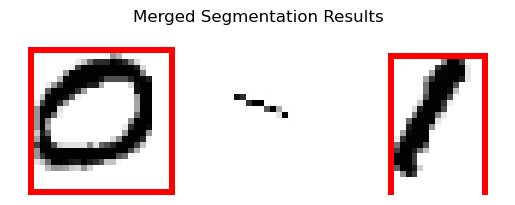

Box (3, 3, 24, 24): Classified as 0 using digit model
Box (64, 4, 16, 24): Classified as + using operator model
Reconstructed Expression: 0+
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_016.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 137, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 109, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 77, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels: 131, Range: [0.00, 1.00]
ROI #1 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 80, Range: [0.00, 1.00]
ROI #2 — Original: (25, 25, 3), Preprocessed: (28, 28), Aspect: 1.00, White pi

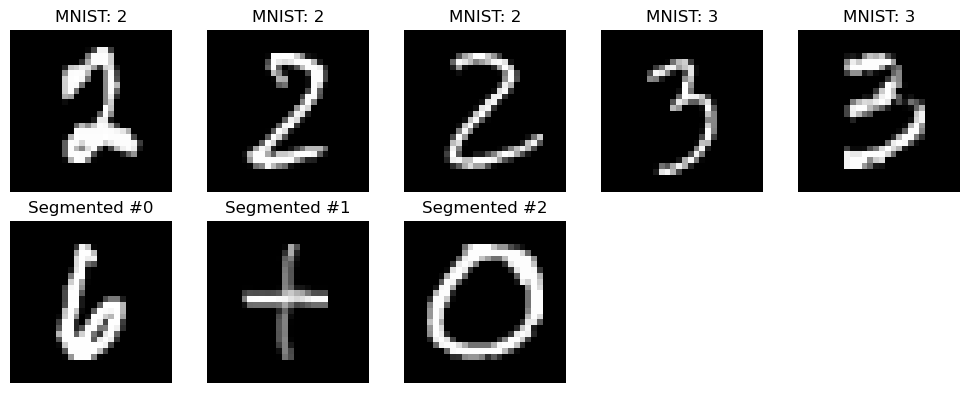

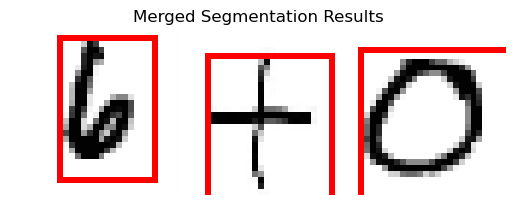

Box (8, 1, 16, 24): Classified as 6 using digit model
Box (33, 4, 21, 24): Classified as + using operator model
Box (59, 3, 25, 25): Classified as 0 using digit model
Reconstructed Expression: 6+0
Evaluation Result: 6

Processing image: expression_dataset/expr_017.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 105, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 160, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 205, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 138, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 59, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 24, 3), Preprocessed: (28, 28), Aspect: 1.04, White pixels: 234, Range: [0.00, 1.00]
ROI #1 — Original: (20, 18, 3), Preprocessed: (28, 28), Aspect: 0.90, White pixels: 123, Range: [0.00, 1.00]
ROI #2 — Original: (21, 23, 3), Preprocessed: (28, 28), Aspect: 1.10, White pixel

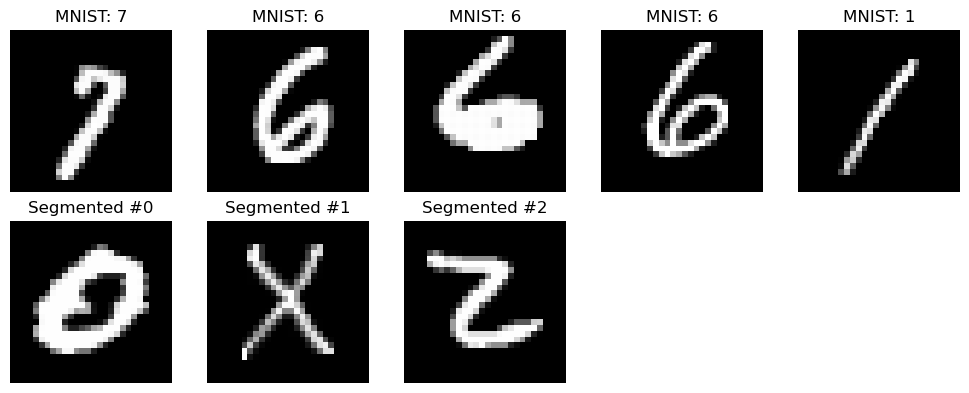

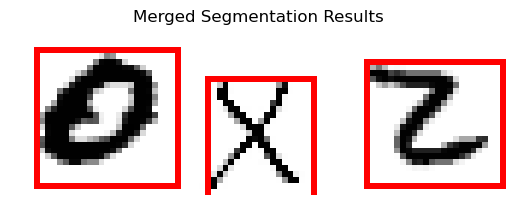

Box (4, 3, 24, 23): Classified as 0 using digit model
Box (33, 8, 18, 20): Classified as * using operator model
Box (60, 5, 23, 21): Classified as 2 using digit model
Reconstructed Expression: 0*2
Evaluation Result: 0

Processing image: expression_dataset/expr_003.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 155, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 142, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 169, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 173, Range: [0.00, 1.00]
ROI #1 — Original: (21, 22, 3), Preprocessed: (28, 28), Aspect: 1.05, White pixels: 104, Range: [0.00, 1.00]
ROI #2 — Original: (23, 18, 3), Preprocessed: (28, 28), Aspect: 0.78, White pixel

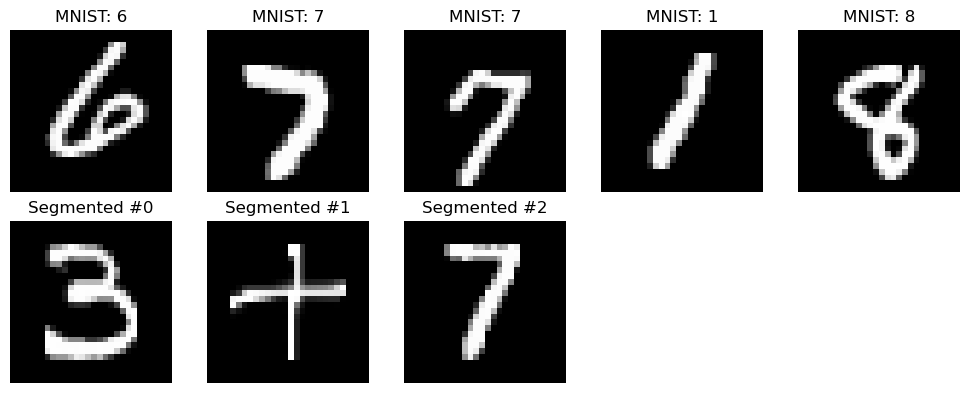

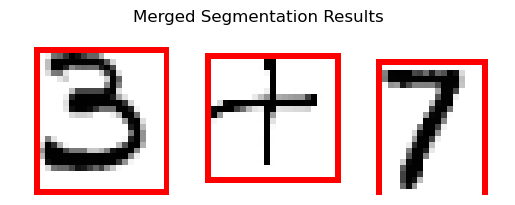

Box (4, 3, 22, 24): Classified as 3 using digit model
Box (33, 4, 22, 21): Classified as + using operator model
Box (62, 5, 18, 23): Classified as 2 using digit model
Reconstructed Expression: 3+2
Evaluation Result: 5

Processing image: expression_dataset/expr_029.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 134, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 131, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 137, Range: [0.00, 1.00]
ROI #1 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 106, Range: [0.00, 1.00]


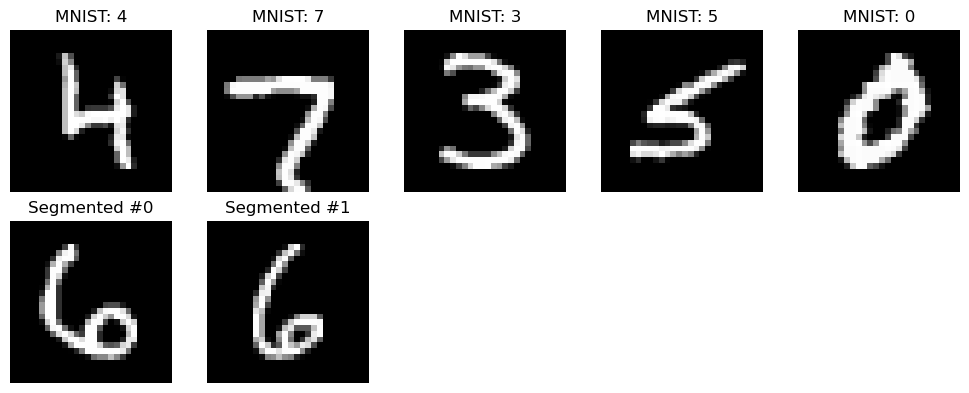

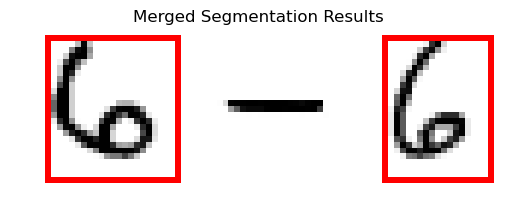

Box (6, 1, 22, 24): Classified as 6 using digit model
Box (63, 1, 18, 24): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_015.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 137, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 91, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 155, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 9, 3), Preprocessed: (28, 28), Aspect: 0.38, White pixels: 73, Range: [0.00, 1.00]
ROI #1 — Original: (24, 19, 3), Preprocessed: (28, 28), Aspect: 0.79, White pixels: 166, Range: [0.00, 1.00]


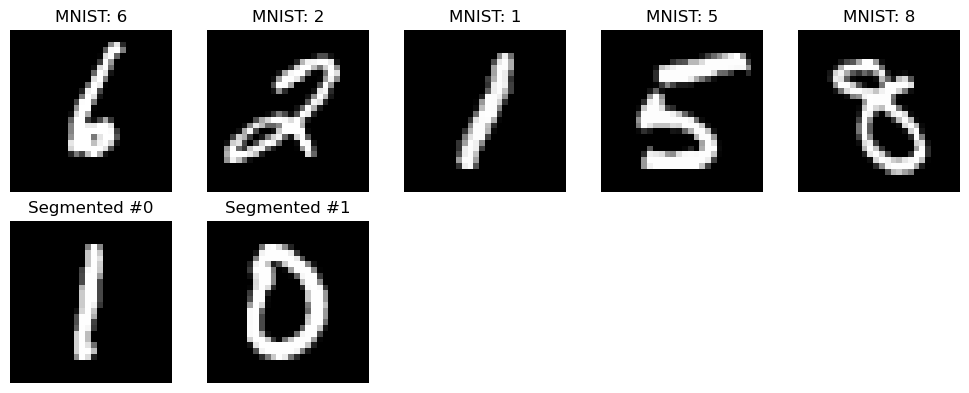

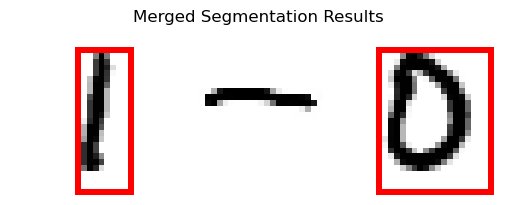

Box (11, 3, 9, 24): Classified as 1 using digit model
Box (62, 3, 19, 24): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_001.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 158, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 95, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 182, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 133, Range: [0.00, 1.00]
ROI #1 — Original: (23, 25, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 130, Range: [0.00, 1.00]
ROI #2 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White p

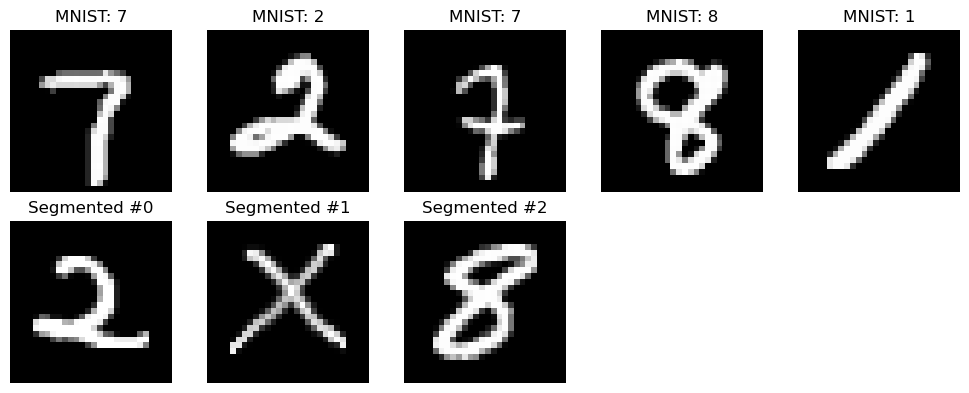

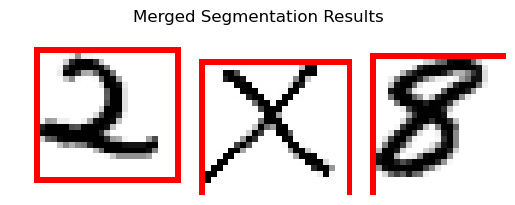

Box (4, 3, 24, 22): Classified as 2 using digit model
Box (32, 5, 25, 23): Classified as * using operator model
Box (61, 4, 23, 24): Classified as 8 using digit model
Reconstructed Expression: 2*8
Evaluation Result: 16

Processing image: expression_dataset/expr_000.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 72, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 166, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 104, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 181, Range: [0.00, 1.00]
ROI #1 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 92, Range: [0.00, 1.00]


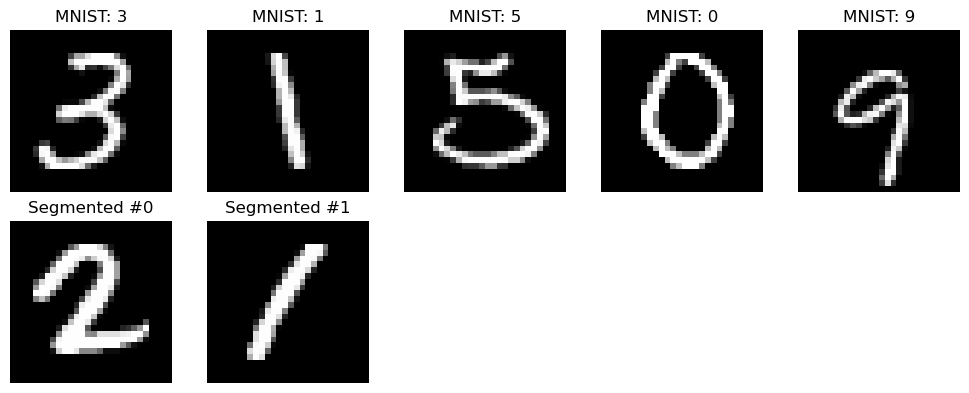

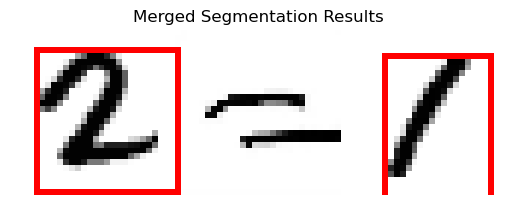

Box (4, 3, 24, 24): Classified as 2 using digit model
Box (63, 4, 18, 24): Classified as * using operator model
Reconstructed Expression: 2*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_014.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 108, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 166, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 187, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 22, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 175, Range: [0.00, 1.00]
ROI #1 — Original: (23, 20, 3), Preprocessed: (28, 28), Aspect: 0.87, White pixels: 77, Range: [0.00, 1.00]
ROI #2 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White p

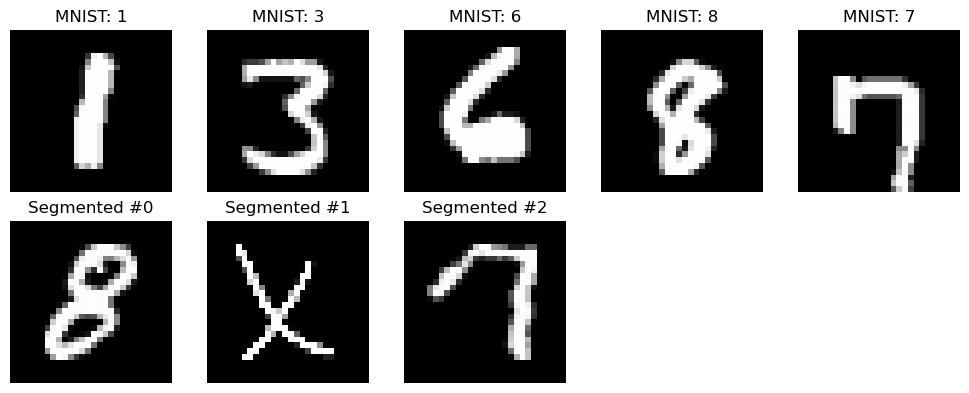

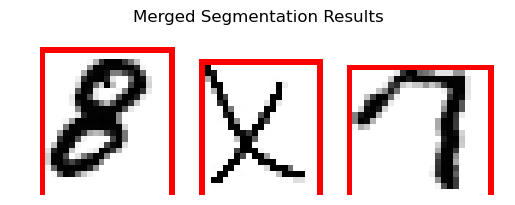

Box (5, 3, 22, 25): Classified as 8 using digit model
Box (32, 5, 20, 23): Classified as * using operator model
Box (57, 6, 24, 22): Classified as 0 using digit model
Reconstructed Expression: 8*0
Evaluation Result: 0

Processing image: expression_dataset/expr_028.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 162, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 66, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 126, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 127, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 121, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 16, 3), Preprocessed: (28, 28), Aspect: 0.70, White pixels: 133, Range: [0.00, 1.00]
ROI #1 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 64, Range: [0.00, 1.00]
ROI #2 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels

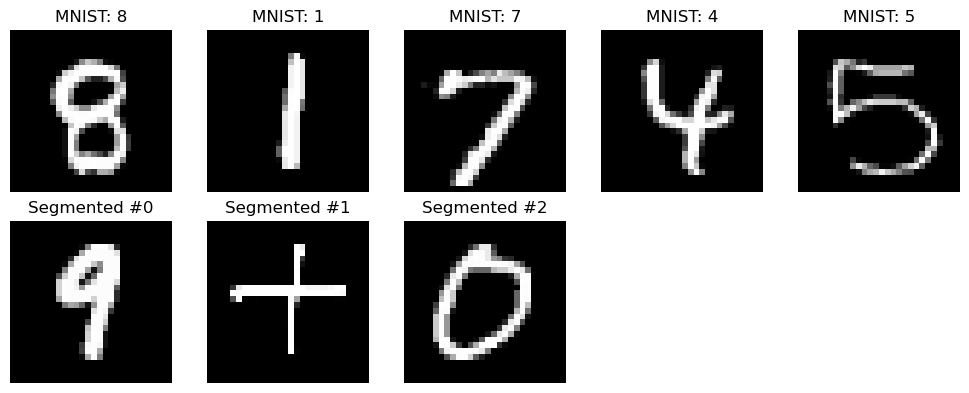

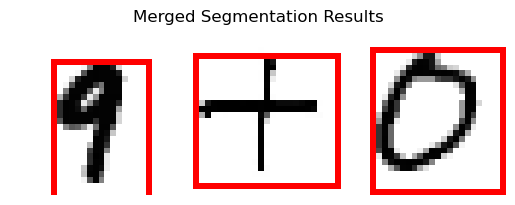

Box (7, 5, 16, 23): Classified as 9 using digit model
Box (31, 4, 24, 22): Classified as + using operator model
Box (61, 3, 22, 24): Classified as 0 using digit model
Reconstructed Expression: 9+0
Evaluation Result: 9

Processing image: expression_dataset/expr_010.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 68, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 213, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 179, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 169, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 16, 3), Preprocessed: (28, 28), Aspect: 0.70, White pixels: 116, Range: [0.00, 1.00]
ROI #1 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 231, Range: [0.00, 1.00]


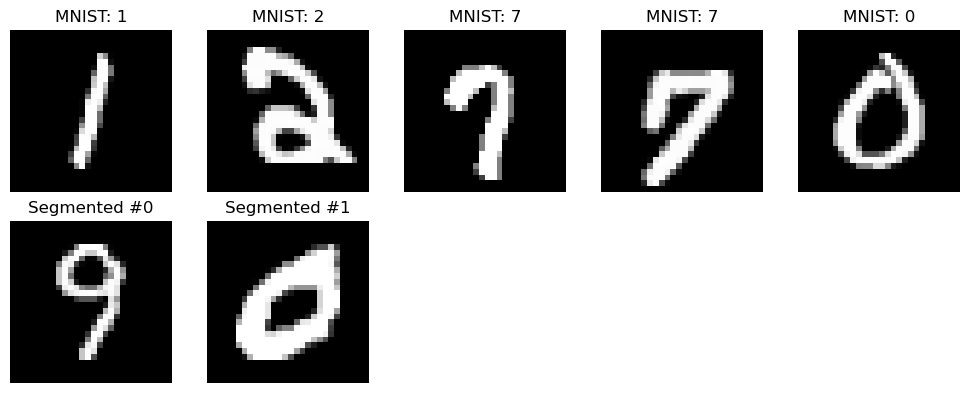

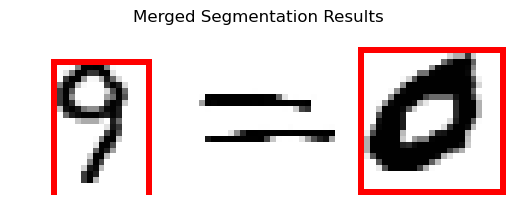

Box (7, 5, 16, 23): Classified as 9 using digit model
Box (59, 3, 24, 24): Classified as / using operator model
Reconstructed Expression: 9/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_004.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 113, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 179, Range: [0.00, 1.00]
MNIST #4 — Label: 4, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 192, Range: [0.00, 1.00]


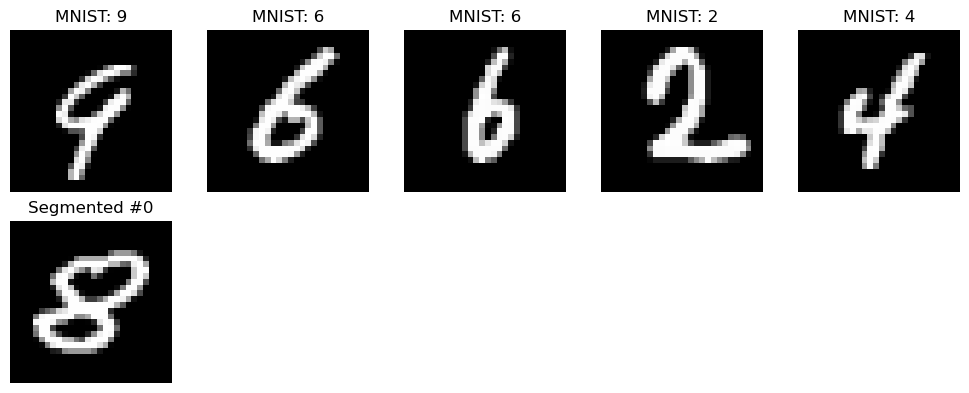

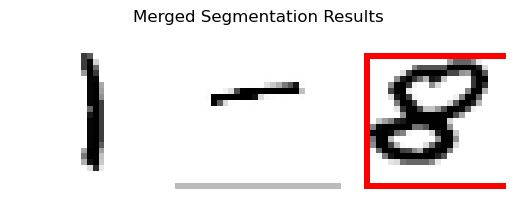

Box (60, 4, 24, 22): Classified as 8 using digit model
Reconstructed Expression: 8
Evaluation Result: 8

Processing image: expression_dataset/expr_038.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 96, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 67, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 101, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 24, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 213, Range: [0.00, 1.00]
ROI #1 — Original: (14, 25, 3), Preprocessed: (28, 28), Aspect: 1.79, White pixels: 79, Range: [0.00, 1.00]
ROI #2 — Original: (22, 15, 3), Preprocessed: (28, 28), Aspect: 0.68, White pixels: 98, Range: [0.00, 1.00]


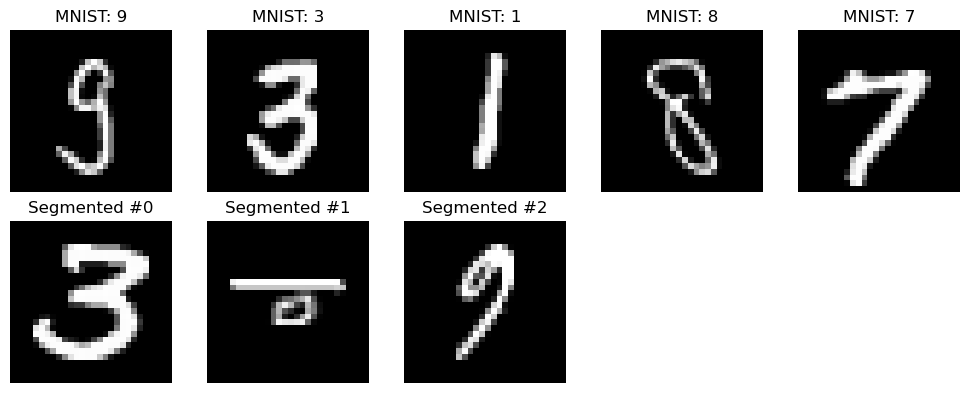

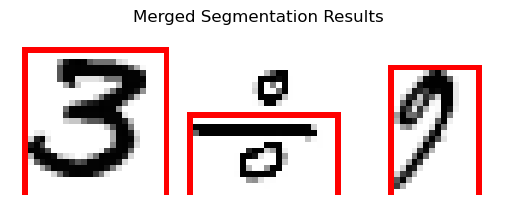

Box (2, 3, 24, 25): Classified as 3 using digit model
Box (30, 14, 25, 14): Classified as / using operator model
Box (64, 6, 15, 22): Classified as 8 using digit model
Reconstructed Expression: 3/8
Evaluation Result: 0.375

Processing image: expression_dataset/expr_039.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 111, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 22, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 159, Range: [0.00, 1.00]
ROI #1 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 80, Range: [0.00, 1.00]


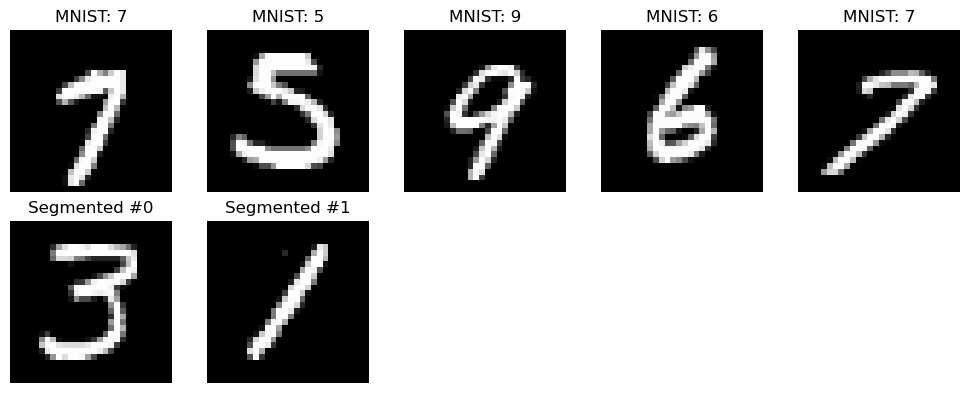

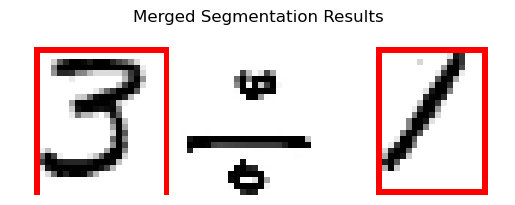

Box (4, 3, 22, 25): Classified as 3 using digit model
Box (62, 3, 18, 24): Classified as * using operator model
Reconstructed Expression: 3*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_005.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 90, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 165, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 52, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 18, 3), Preprocessed: (28, 28), Aspect: 0.82, White pixels: 107, Range: [0.00, 1.00]
ROI #1 — Original: (24, 9, 3), Preprocessed: (28, 28), Aspect: 0.38, White pixels: 60, Range: [0.00, 1.00]


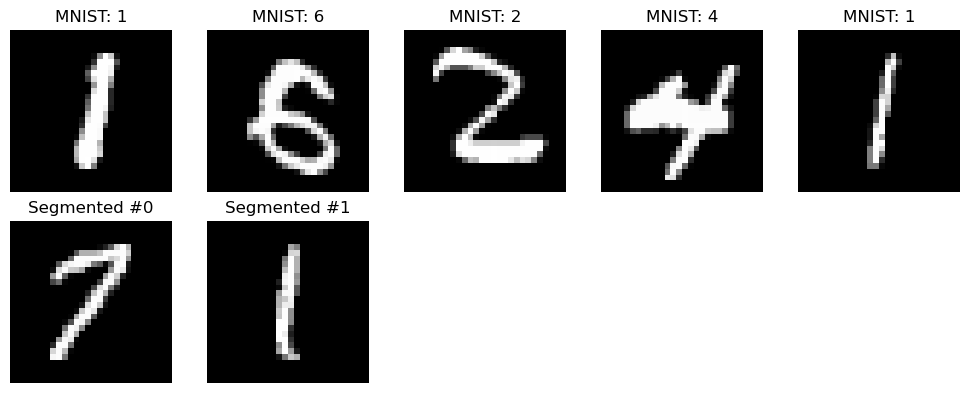

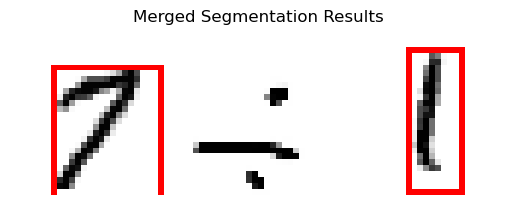

Box (7, 6, 18, 22): Classified as 2 using digit model
Box (67, 3, 9, 24): Classified as / using operator model
Reconstructed Expression: 2/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_011.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 91, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 127, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 177, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 181, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 168, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 180, Range: [0.00, 1.00]


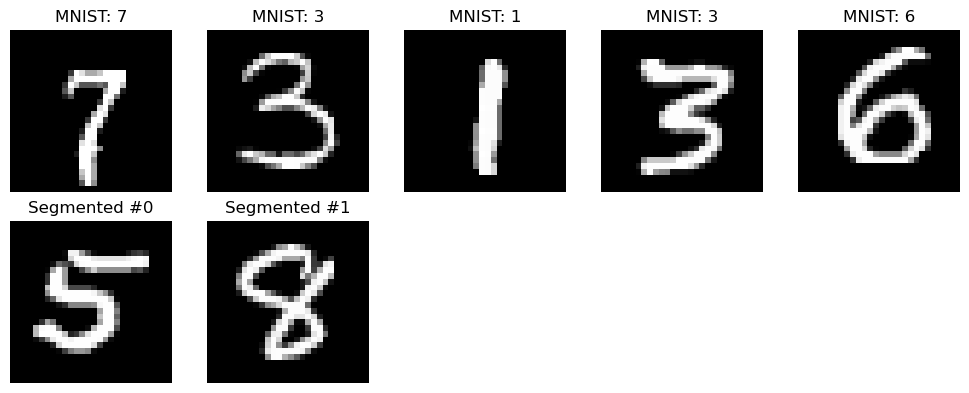

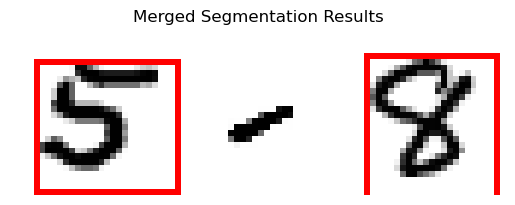

Box (4, 5, 24, 22): Classified as 5 using digit model
Box (60, 4, 22, 24): Classified as / using operator model
Reconstructed Expression: 5/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_007.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 66, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 97, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 88, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 188, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 160, Range: [0.00, 1.00]
ROI #1 — Original: (22, 18, 3), Preprocessed: (28, 28), Aspect: 0.82, White pixels: 124, Range: [0.00, 1.00]
ROI #2 — Original: (25, 18, 3), Preprocessed: (28, 28), Aspect: 0.72, White pixe

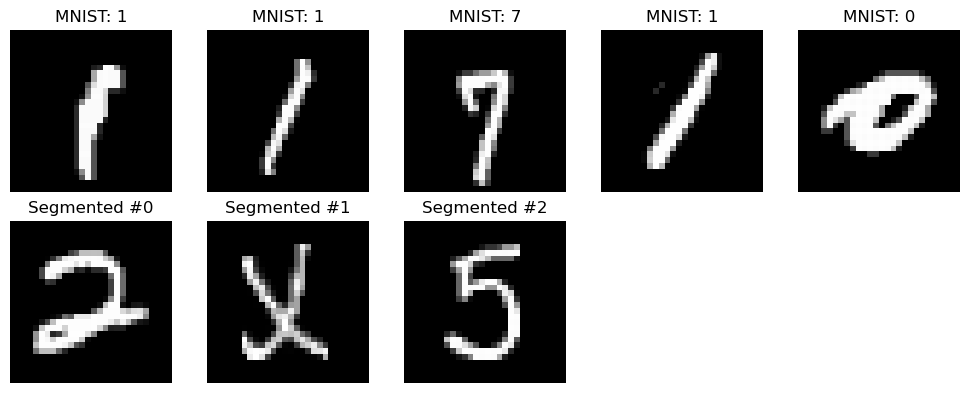

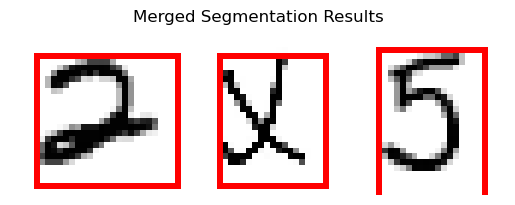

Box (4, 4, 24, 22): Classified as 2 using digit model
Box (35, 4, 18, 22): Classified as * using operator model
Box (62, 3, 18, 25): Classified as 5 using digit model
Reconstructed Expression: 2*5
Evaluation Result: 10

Processing image: expression_dataset/expr_013.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 148, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 56, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 92, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 187, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 19, 3), Preprocessed: (28, 28), Aspect: 0.79, White pixels: 152, Range: [0.00, 1.00]
ROI #1 — Original: (26, 29, 3), Preprocessed: (28, 28), Aspect: 1.12, White pixels: 74, Range: [0.00, 1.00]
ROI #2 — Original: (24, 16, 3), Preprocessed: (28, 28), Aspect: 0.67, White pixels

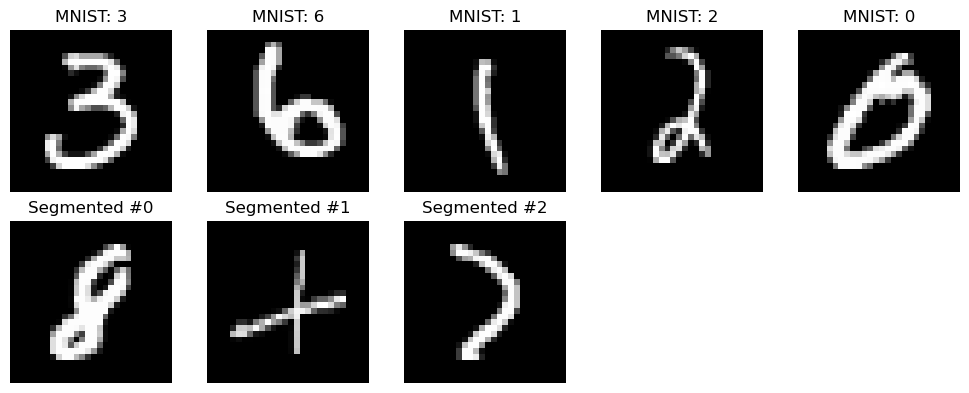

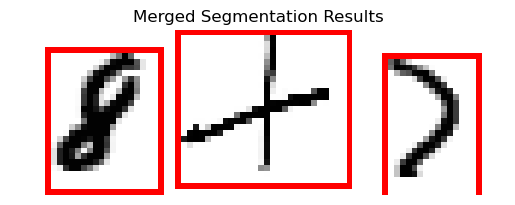

Box (6, 3, 19, 24): Classified as 8 using digit model
Box (28, 0, 29, 26): Classified as + using operator model
Box (63, 4, 16, 24): Classified as 2 using digit model
Reconstructed Expression: 8+2
Evaluation Result: 10

Processing image: expression_dataset/expr_012.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 128, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 116, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 157, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 233, Range: [0.00, 1.00]
ROI #1 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 176, Range: [0.00, 1.00]


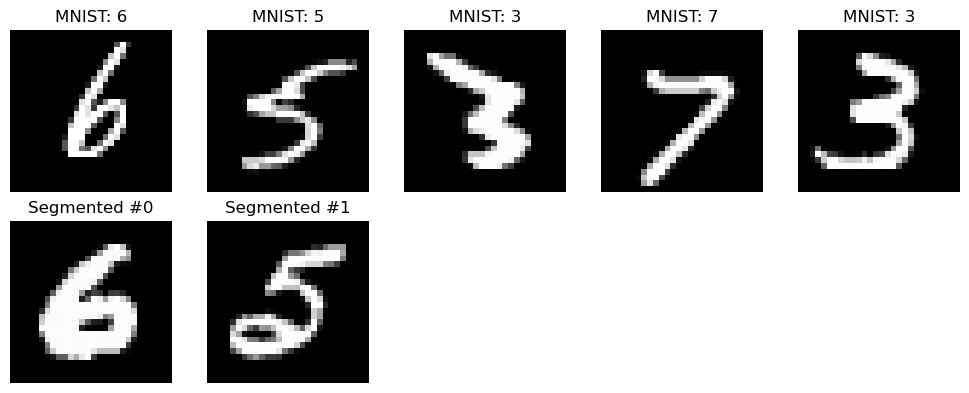

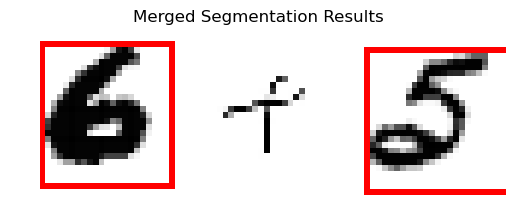

Box (5, 2, 22, 24): Classified as 6 using digit model
Box (60, 3, 24, 24): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_006.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 105, Range: [0.00, 1.00]
MNIST #1 — Label: 8, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 118, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 103, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 207, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixels: 114, Range: [0.00, 1.00]
ROI #1 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 208, Range: [0.00, 1.00]


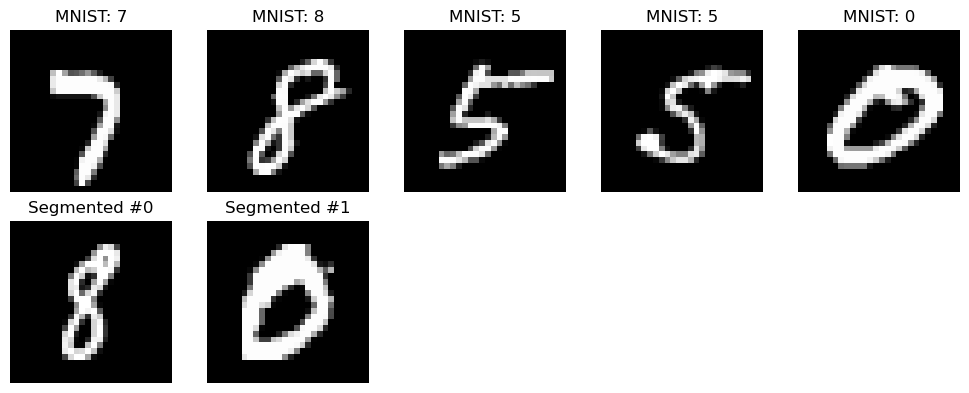

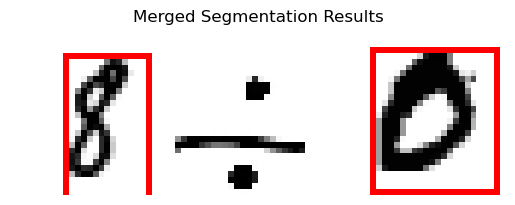

Box (9, 4, 14, 24): Classified as 8 using digit model
Box (61, 3, 21, 24): Classified as / using operator model
Reconstructed Expression: 8/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_049.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 93, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 109, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 111, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 200, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 18, 3), Preprocessed: (28, 28), Aspect: 0.72, White pixels: 127, Range: [0.00, 1.00]
ROI #1 — Original: (19, 19, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 107, Range: [0.00, 1.00]
ROI #2 — Original: (25, 17, 3), Preprocessed: (28, 28), Aspect: 0.68, White p

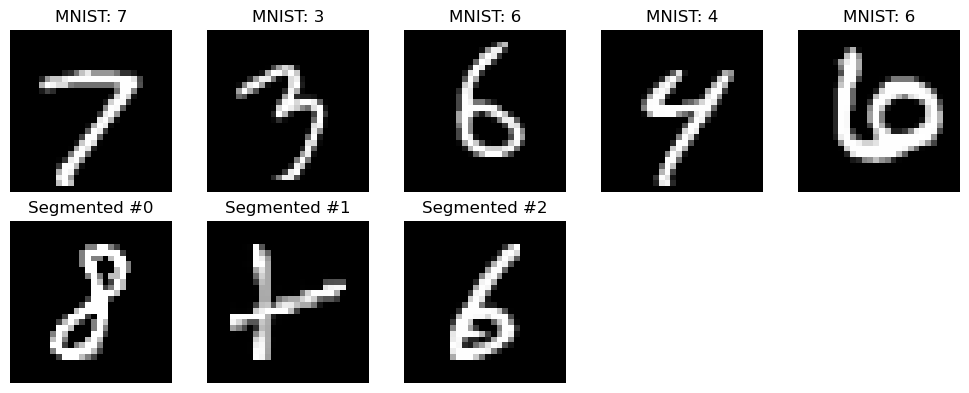

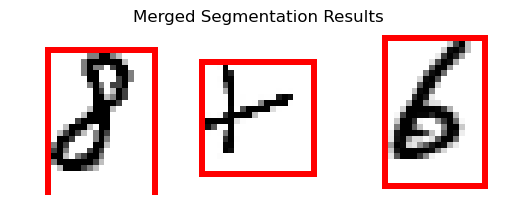

Box (6, 3, 18, 25): Classified as 8 using digit model
Box (32, 5, 19, 19): Classified as + using operator model
Box (63, 1, 17, 25): Classified as 6 using digit model
Reconstructed Expression: 8+6
Evaluation Result: 14

Processing image: expression_dataset/expr_061.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 103, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 110, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 127, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 79, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 144, Range: [0.00, 1.00]
ROI #1 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 159, Range: [0.00, 1.00]


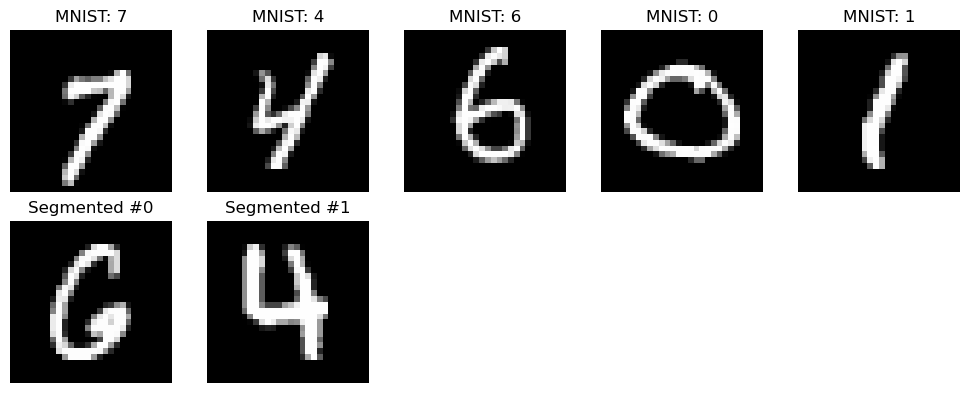

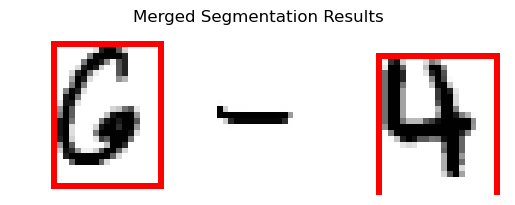

Box (7, 2, 18, 24): Classified as 0 using digit model
Box (62, 4, 20, 24): Classified as + using operator model
Reconstructed Expression: 0+
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_075.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 141, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 109, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 101, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 137, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 128, Range: [0.00, 1.00]
ROI #1 — Original: (25, 25, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 96, Range: [0.00, 1.00]
ROI #2 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White p

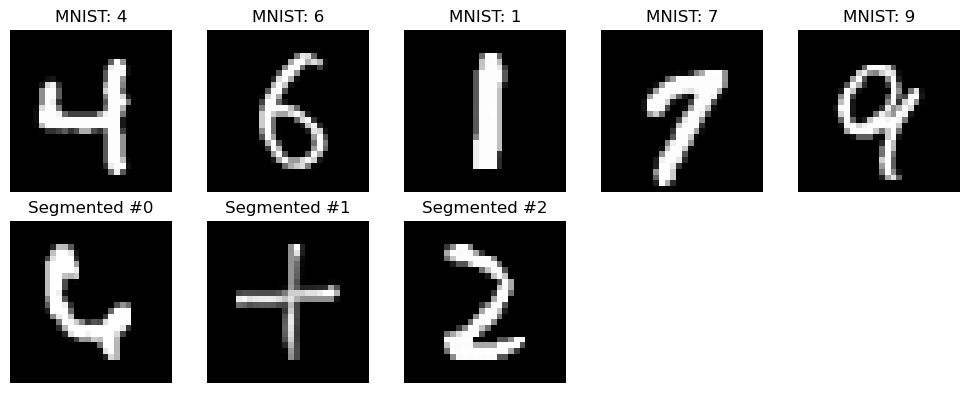

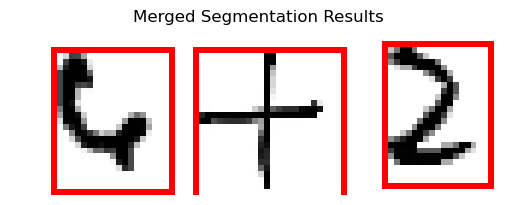

Box (7, 3, 20, 24): Classified as 6 using digit model
Box (31, 3, 25, 25): Classified as + using operator model
Box (63, 2, 18, 24): Classified as 2 using digit model
Reconstructed Expression: 6+2
Evaluation Result: 8

Processing image: expression_dataset/expr_074.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 151, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 104, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 158, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 165, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 22, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 127, Range: [0.00, 1.00]
ROI #1 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 228, Range: [0.00, 1.00]


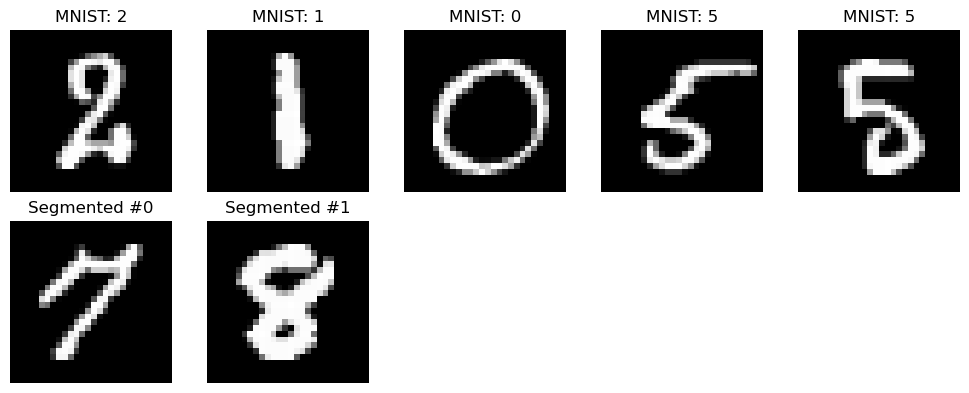

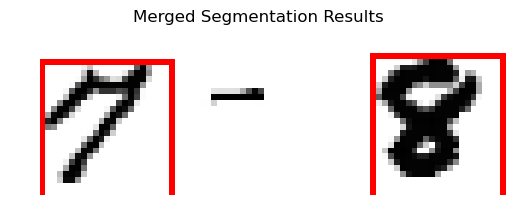

Box (5, 5, 22, 23): Classified as 7 using digit model
Box (61, 4, 22, 24): Classified as / using operator model
Reconstructed Expression: 7/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_060.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 167, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 66, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 101, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 134, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 14, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixels: 115, Range: [0.00, 1.00]
ROI #1 — Original: (24, 13, 3), Preprocessed: (28, 28), Aspect: 0.54, White pixels: 88, Range: [0.00, 1.00]


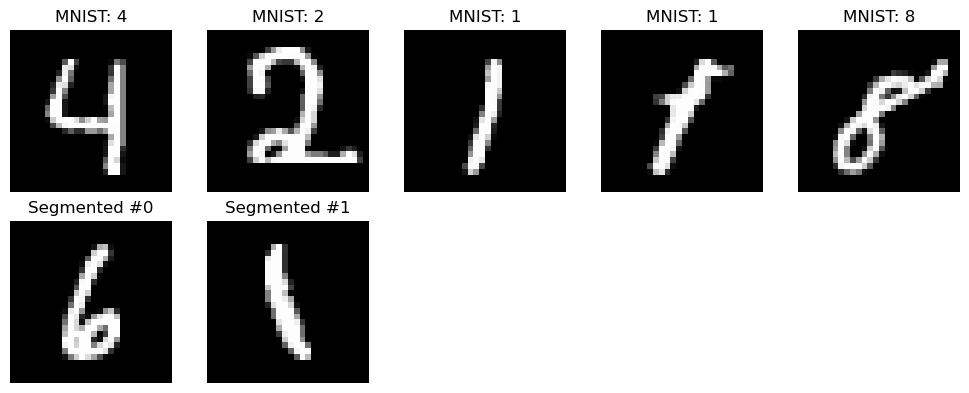

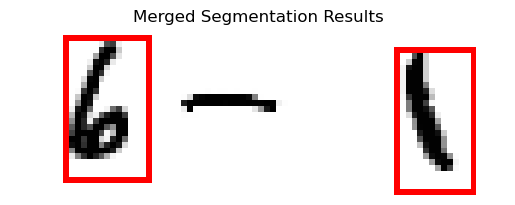

Box (9, 1, 14, 24): Classified as 6 using digit model
Box (65, 3, 13, 24): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_048.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 103, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 192, Range: [0.00, 1.00]
MNIST #2 — Label: 3, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 65, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 144, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 26, 3), Preprocessed: (28, 28), Aspect: 1.13, White pixels: 143, Range: [0.00, 1.00]
ROI #1 — Original: (21, 19, 3), Preprocessed: (28, 28), Aspect: 0.90, White pixels: 125, Range: [0.00, 1.00]
ROI #2 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White p

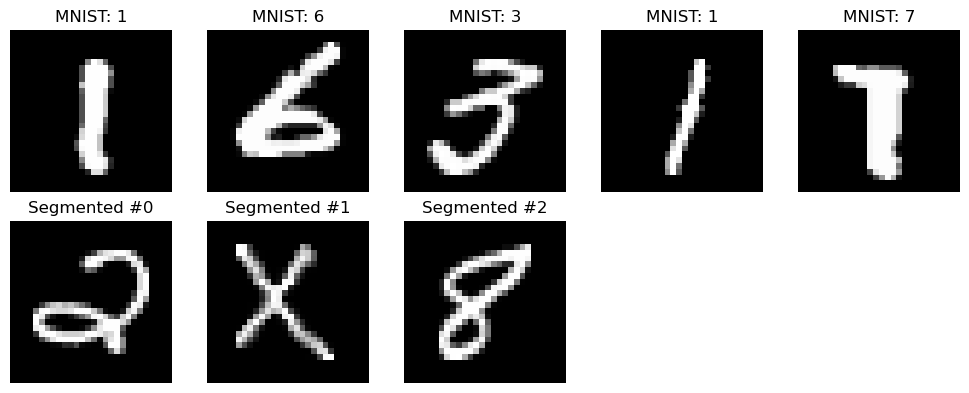

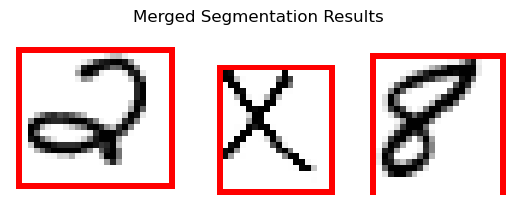

Box (1, 3, 26, 23): Classified as 2 using digit model
Box (35, 6, 19, 21): Classified as * using operator model
Box (61, 4, 22, 24): Classified as 8 using digit model
Reconstructed Expression: 2*8
Evaluation Result: 16

Processing image: expression_dataset/expr_089.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 165, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 72, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 214, Range: [0.00, 1.00]
MNIST #3 — Label: 6, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 177, Range: [0.00, 1.00]
ROI #1 — Original: (15, 14, 3), Preprocessed: (28, 28), Aspect: 0.93, White pixels: 123, Range: [0.00, 1.00]
ROI #2 — Original: (21, 24, 3), Preprocessed: (28, 28), Aspect: 1.14, White pixe

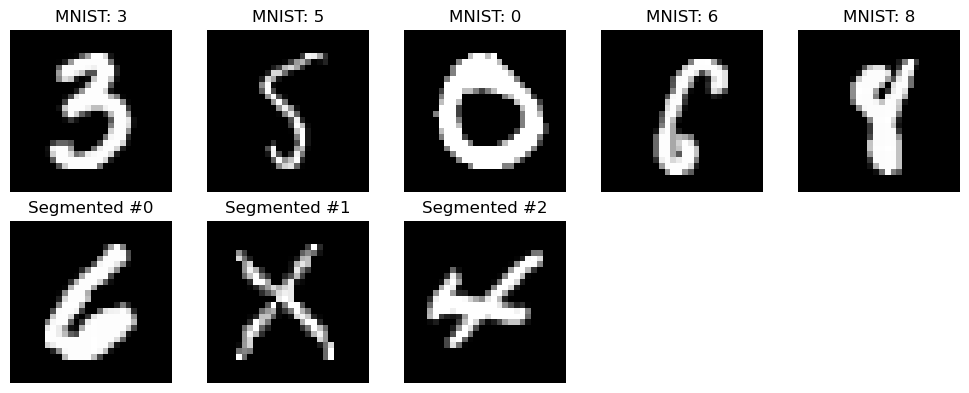

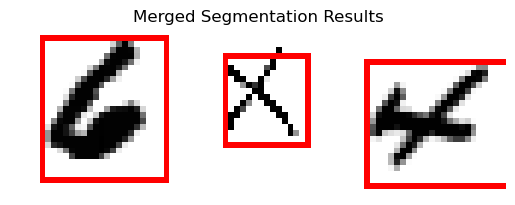

Box (5, 1, 21, 24): Classified as 6 using digit model
Box (36, 4, 14, 15): Classified as * using operator model
Box (60, 5, 24, 21): Classified as 4 using digit model
Reconstructed Expression: 6*4
Evaluation Result: 24

Processing image: expression_dataset/expr_076.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 169, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 95, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 89, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 116, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 18, 3), Preprocessed: (28, 28), Aspect: 0.75, White pixels: 163, Range: [0.00, 1.00]
ROI #1 — Original: (24, 24, 3), Preprocessed: (28, 28), Aspect: 1.00, White pixels: 218, Range: [0.00, 1.00]


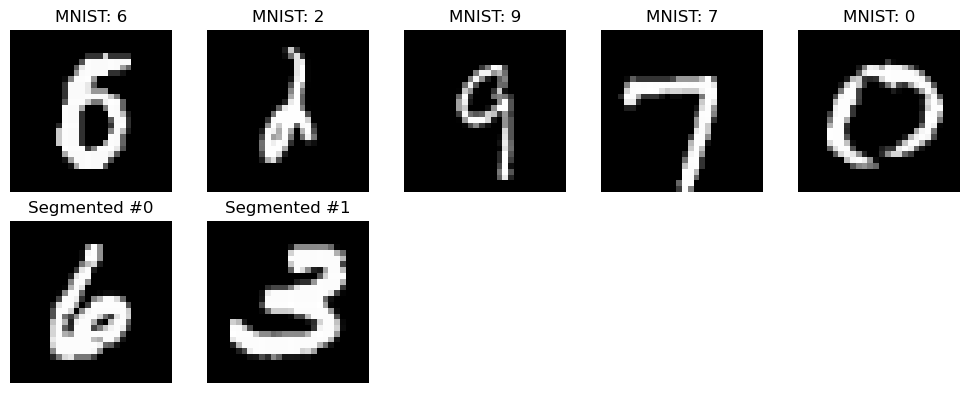

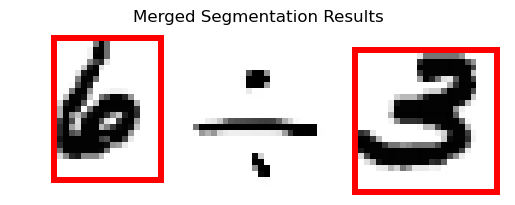

Box (7, 1, 18, 24): Classified as 6 using digit model
Box (58, 3, 24, 24): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_062.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 129, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 129, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
MNIST #4 — Label: 9, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (13, 24, 3), Preprocessed: (28, 28), Aspect: 1.85, White pixels: 54, Range: [0.00, 1.00]
ROI #1 — Original: (17, 23, 3), Preprocessed: (28, 28), Aspect: 1.35, White pixels: 113, Range: [0.00, 1.00]


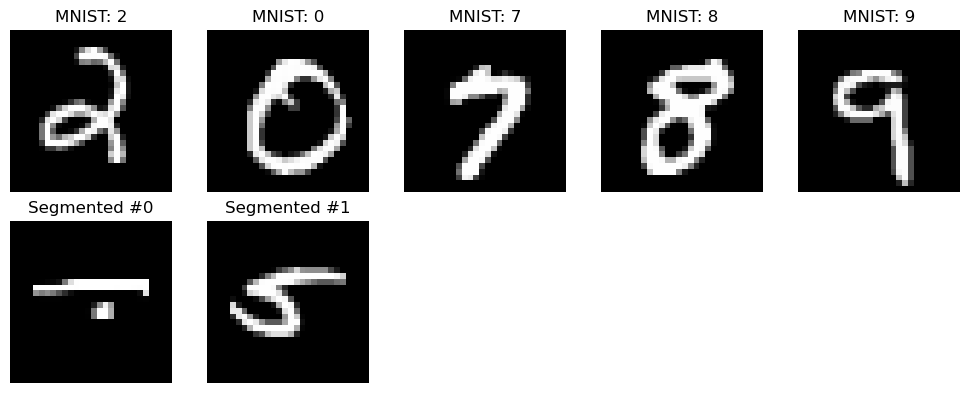

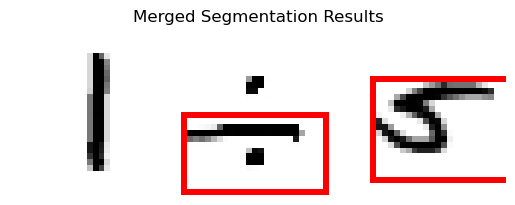

Box (29, 14, 24, 13): Classified as 7 using digit model
Box (61, 8, 23, 17): Classified as * using operator model
Reconstructed Expression: 7*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_063.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 88, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 102, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 153, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 10, 3), Preprocessed: (28, 28), Aspect: 0.42, White pixels: 55, Range: [0.00, 1.00]
ROI #1 — Original: (21, 22, 3), Preprocessed: (28, 28), Aspect: 1.05, White pixels: 138, Range: [0.00, 1.00]
ROI #2 — Original: (26, 20, 3), Preprocessed: (28, 28), Aspect: 0.77, White 

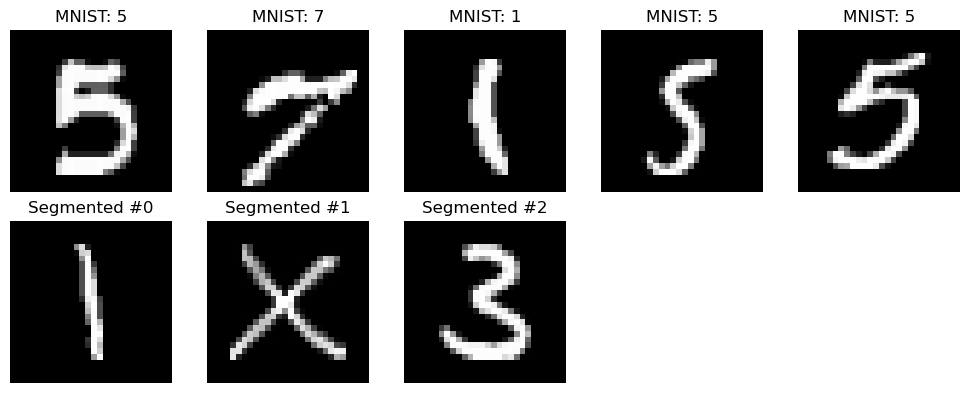

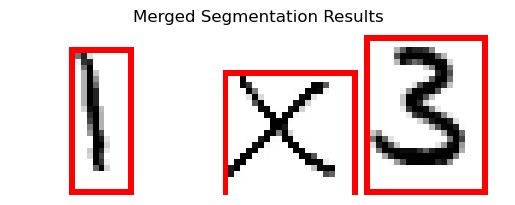

Box (10, 3, 10, 24): Classified as 1 using digit model
Box (36, 7, 22, 21): Classified as * using operator model
Box (60, 1, 20, 26): Classified as 3 using digit model
Reconstructed Expression: 1*3
Evaluation Result: 3

Processing image: expression_dataset/expr_077.png
--- MNIST Samples ---
MNIST #0 — Label: 4, Shape: (28, 28), White pixels: 99, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
MNIST #4 — Label: 5, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 19, 3), Preprocessed: (28, 28), Aspect: 0.76, White pixels: 147, Range: [0.00, 1.00]
ROI #1 — Original: (23, 22, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 88, Range: [0.00, 1.00]
ROI #2 — Original: (24, 15, 3), Preprocessed: (28, 28), Aspect: 0.62, White pixel

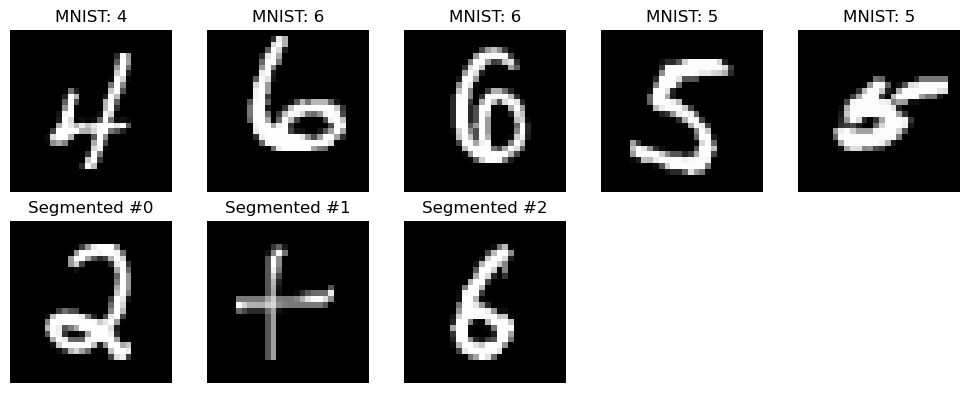

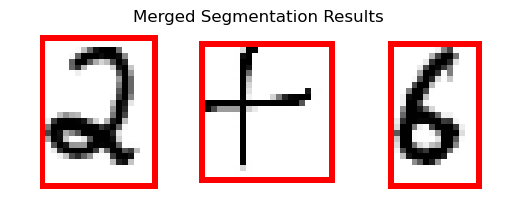

Box (5, 1, 19, 25): Classified as 2 using digit model
Box (32, 2, 22, 23): Classified as + using operator model
Box (64, 2, 15, 24): Classified as 6 using digit model
Reconstructed Expression: 2+6
Evaluation Result: 8

Processing image: expression_dataset/expr_088.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 145, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 238, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 161, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 22, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 174, Range: [0.00, 1.00]
ROI #1 — Original: (25, 21, 3), Preprocessed: (28, 28), Aspect: 0.84, White pixels: 149, Range: [0.00, 1.00]


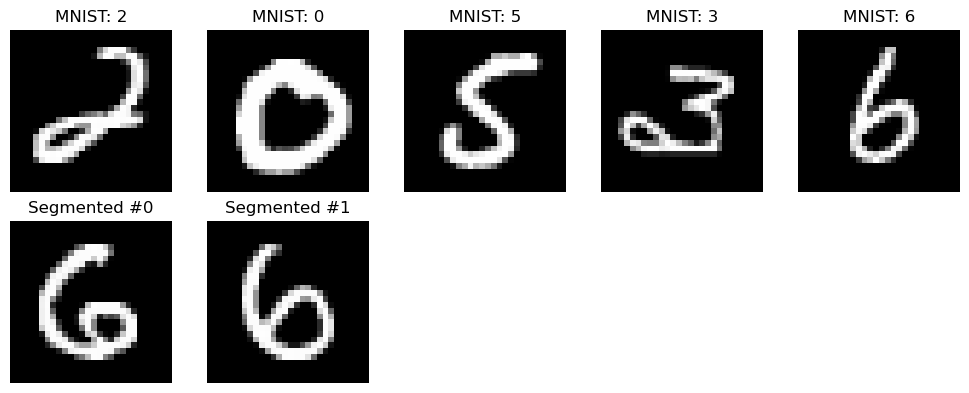

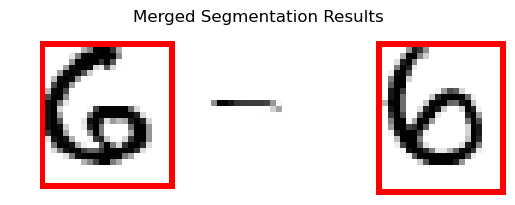

Box (5, 2, 22, 24): Classified as 6 using digit model
Box (62, 2, 21, 25): Classified as / using operator model
Reconstructed Expression: 6/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_098.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #1 — Label: 3, Shape: (28, 28), White pixels: 193, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 121, Range: [0.00, 1.00]
MNIST #3 — Label: 5, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 130, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 19, 3), Preprocessed: (28, 28), Aspect: 0.76, White pixels: 137, Range: [0.00, 1.00]
ROI #1 — Original: (19, 17, 3), Preprocessed: (28, 28), Aspect: 0.89, White pixels: 151, Range: [0.00, 1.00]
ROI #2 — Original: (21, 24, 3), Preprocessed: (28, 28), Aspect: 1.14, White 

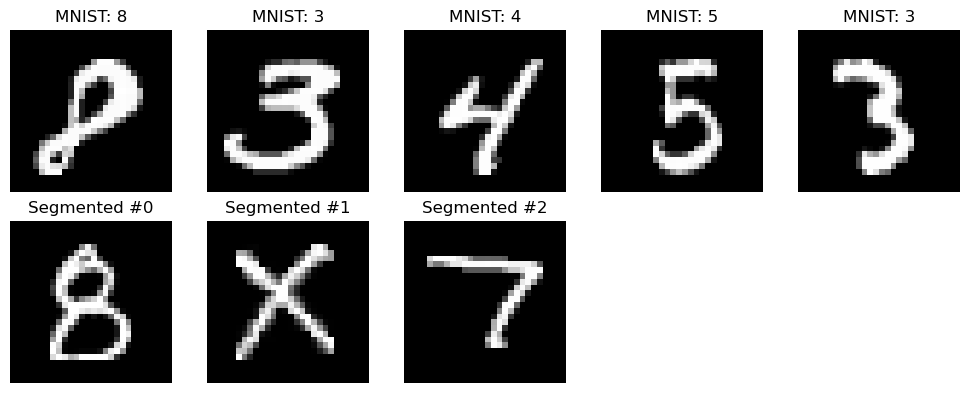

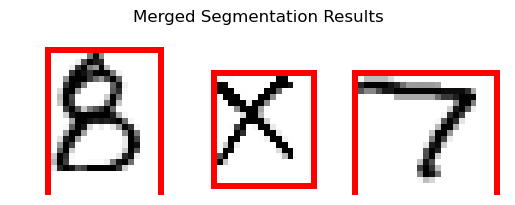

Box (6, 3, 19, 25): Classified as 8 using digit model
Box (34, 7, 17, 19): Classified as * using operator model
Box (58, 7, 24, 21): Classified as 7 using digit model
Reconstructed Expression: 8*7
Evaluation Result: 56

Processing image: expression_dataset/expr_073.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 88, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 147, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 174, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 98, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 12, 3), Preprocessed: (28, 28), Aspect: 0.50, White pixels: 72, Range: [0.00, 1.00]
ROI #1 — Original: (21, 19, 3), Preprocessed: (28, 28), Aspect: 0.90, White pixels: 95, Range: [0.00, 1.00]
ROI #2 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels:

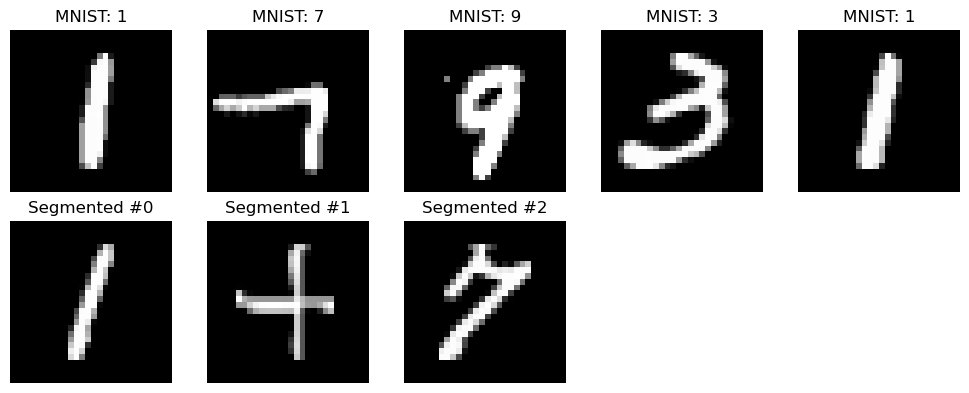

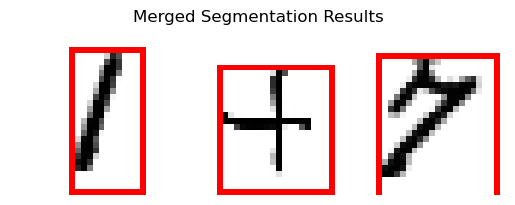

Box (10, 3, 12, 24): Classified as 1 using digit model
Box (35, 6, 19, 21): Classified as + using operator model
Box (62, 4, 20, 24): Classified as 2 using digit model
Reconstructed Expression: 1+2
Evaluation Result: 3

Processing image: expression_dataset/expr_067.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 96, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 172, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 117, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 184, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 11, 3), Preprocessed: (28, 28), Aspect: 0.46, White pixels: 64, Range: [0.00, 1.00]
ROI #1 — Original: (24, 21, 3), Preprocessed: (28, 28), Aspect: 0.88, White pixels: 119, Range: [0.00, 1.00]


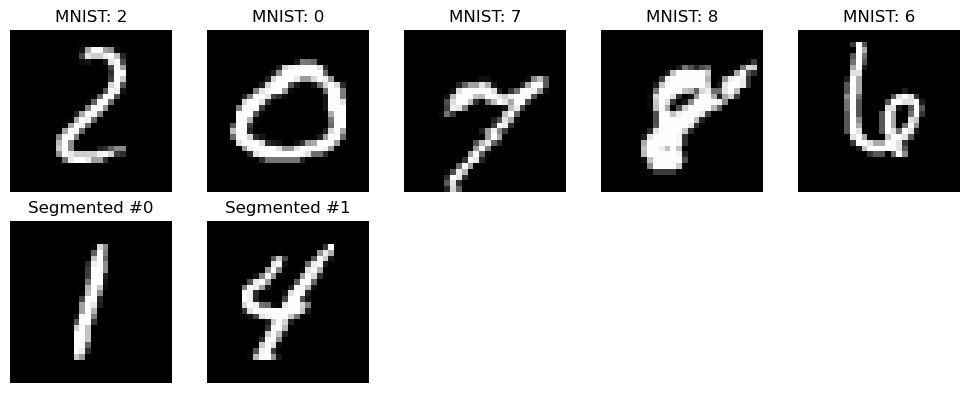

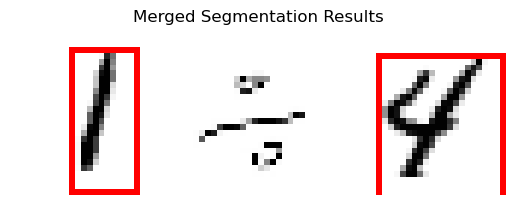

Box (10, 3, 11, 24): Classified as 1 using digit model
Box (62, 4, 21, 24): Classified as * using operator model
Reconstructed Expression: 1*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_066.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 131, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 107, Range: [0.00, 1.00]
MNIST #2 — Label: 6, Shape: (28, 28), White pixels: 142, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 139, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 131, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (26, 14, 3), Preprocessed: (28, 28), Aspect: 0.54, White pixels: 65, Range: [0.00, 1.00]
ROI #1 — Original: (25, 15, 3), Preprocessed: (28, 28), Aspect: 0.60, White pixels: 80, Range: [0.00, 1.00]


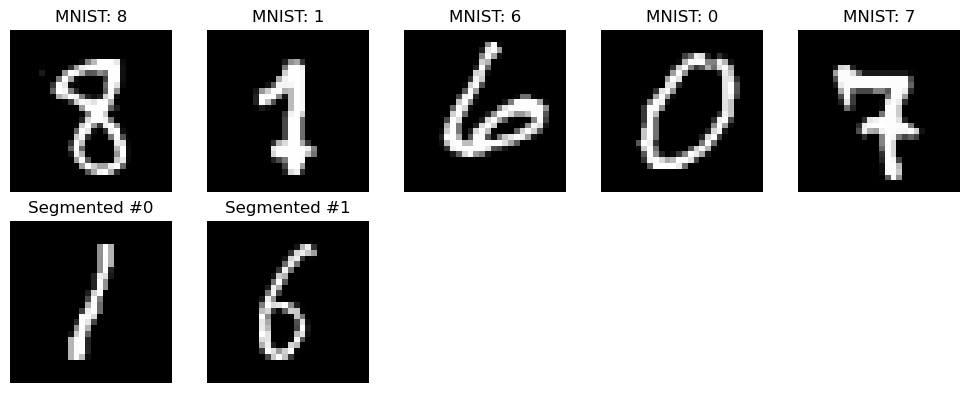

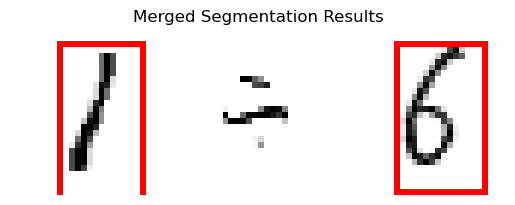

Box (8, 2, 14, 26): Classified as 1 using digit model
Box (65, 2, 15, 25): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_072.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #1 — Label: 6, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 152, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 104, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 68, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 19, 3), Preprocessed: (28, 28), Aspect: 0.76, White pixels: 128, Range: [0.00, 1.00]
ROI #1 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White pixels: 190, Range: [0.00, 1.00]


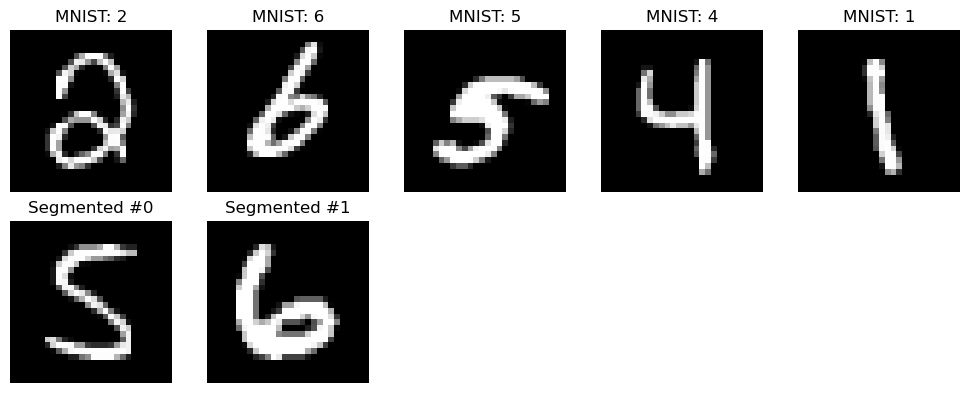

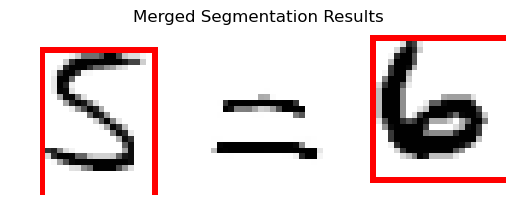

Box (5, 3, 19, 25): Classified as 5 using digit model
Box (61, 1, 23, 24): Classified as / using operator model
Reconstructed Expression: 5/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_099.png
--- MNIST Samples ---
MNIST #0 — Label: 0, Shape: (28, 28), White pixels: 218, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 147, Range: [0.00, 1.00]
MNIST #2 — Label: 0, Shape: (28, 28), White pixels: 198, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 86, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (25, 23, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 168, Range: [0.00, 1.00]
ROI #1 — Original: (11, 24, 3), Preprocessed: (28, 28), Aspect: 2.18, White pixels: 47, Range: [0.00, 1.00]
ROI #2 — Original: (25, 18, 3), Preprocessed: (28, 28), Aspect: 0.72, White pi

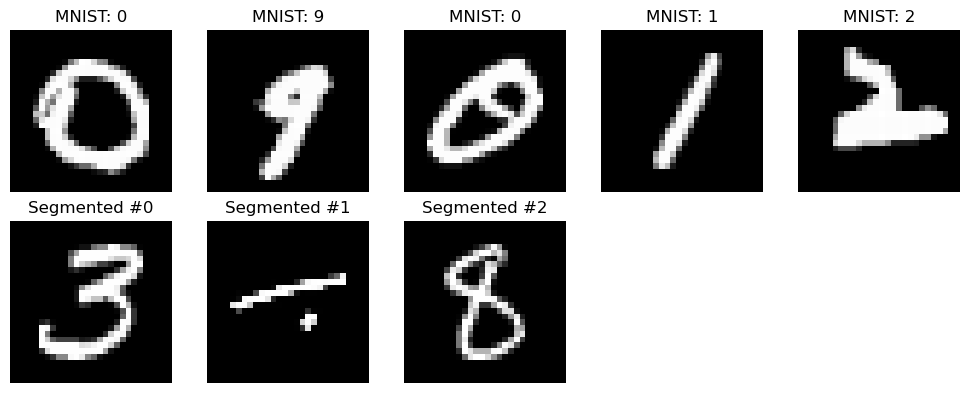

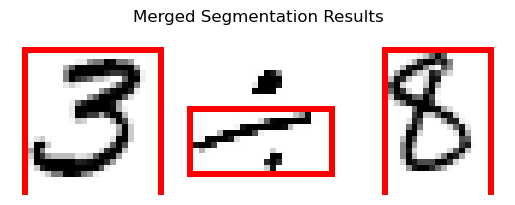

Box (2, 3, 23, 25): Classified as 3 using digit model
Box (30, 13, 24, 11): Classified as / using operator model
Box (63, 3, 18, 25): Classified as 8 using digit model
Reconstructed Expression: 3/8
Evaluation Result: 0.375

Processing image: expression_dataset/expr_064.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 122, Range: [0.00, 1.00]
MNIST #1 — Label: 0, Shape: (28, 28), White pixels: 204, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 157, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 221, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 143, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 20, 3), Preprocessed: (28, 28), Aspect: 0.83, White pixels: 157, Range: [0.00, 1.00]
ROI #1 — Original: (19, 16, 3), Preprocessed: (28, 28), Aspect: 0.84, White pixels: 99, Range: [0.00, 1.00]
ROI #2 — Original: (23, 20, 3), Preprocessed: (28, 28), Aspect: 0.87, White 

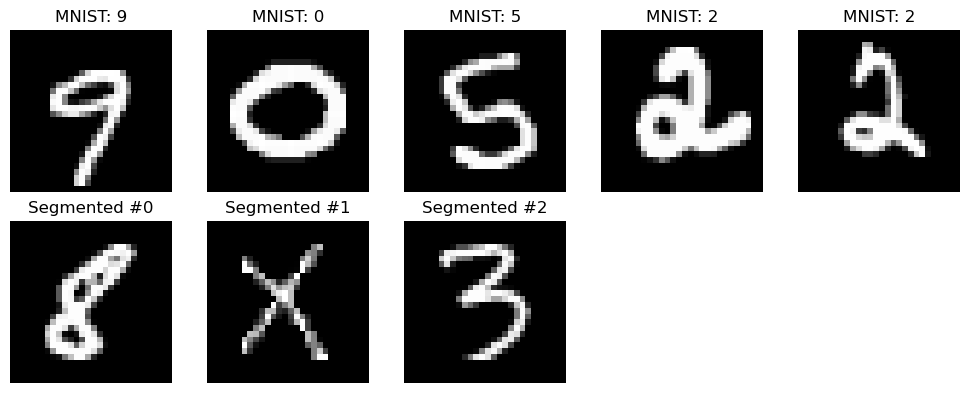

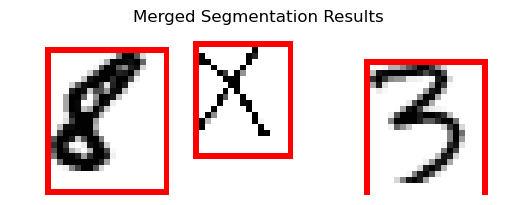

Box (6, 3, 20, 24): Classified as 8 using digit model
Box (31, 2, 16, 19): Classified as * using operator model
Box (60, 5, 20, 23): Classified as 3 using digit model
Reconstructed Expression: 8*3
Evaluation Result: 24

Processing image: expression_dataset/expr_070.png
--- MNIST Samples ---
MNIST #0 — Label: 7, Shape: (28, 28), White pixels: 170, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 191, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 105, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 25, 3), Preprocessed: (28, 28), Aspect: 1.04, White pixels: 170, Range: [0.00, 1.00]
ROI #1 — Original: (17, 25, 3), Preprocessed: (28, 28), Aspect: 1.47, White pixels: 91, Range: [0.00, 1.00]


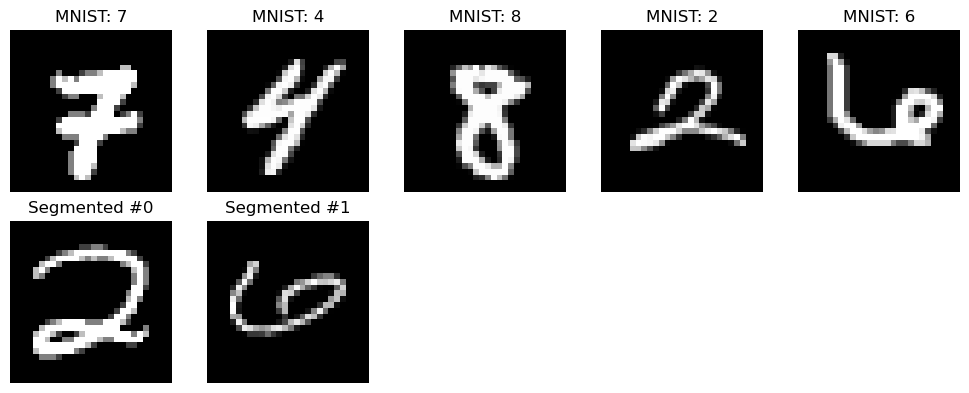

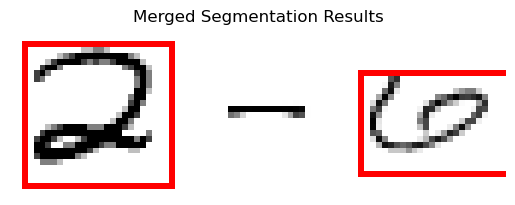

Box (2, 2, 25, 24): Classified as 2 using digit model
Box (59, 7, 25, 17): Classified as * using operator model
Reconstructed Expression: 2*
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_058.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 119, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 149, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 150, Range: [0.00, 1.00]
MNIST #3 — Label: 7, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 119, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (23, 18, 3), Preprocessed: (28, 28), Aspect: 0.78, White pixels: 105, Range: [0.00, 1.00]
ROI #1 — Original: (13, 25, 3), Preprocessed: (28, 28), Aspect: 1.92, White pixels: 69, Range: [0.00, 1.00]
ROI #2 — Original: (24, 23, 3), Preprocessed: (28, 28), Aspect: 0.96, White p

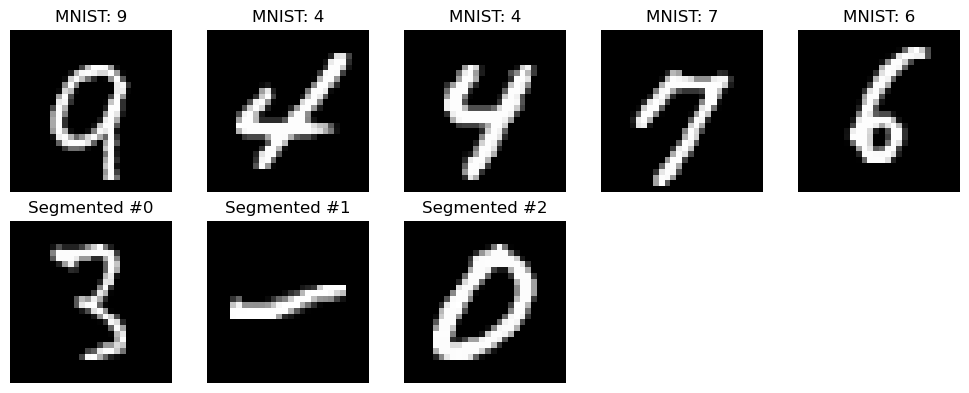

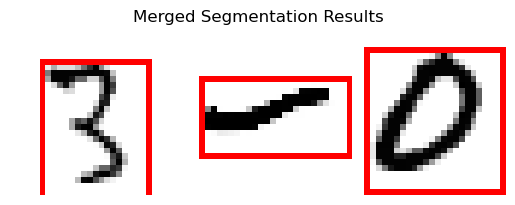

Box (5, 5, 18, 23): Classified as 3 using digit model
Box (32, 8, 25, 13): Classified as / using operator model
Box (60, 3, 23, 24): Classified as 0 using digit model
Reconstructed Expression: 3/0
Evaluation Error: Error evaluating expression: division by zero

Processing image: expression_dataset/expr_059.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 95, Range: [0.00, 1.00]
MNIST #1 — Label: 1, Shape: (28, 28), White pixels: 96, Range: [0.00, 1.00]
MNIST #2 — Label: 9, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 140, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 132, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 10, 3), Preprocessed: (28, 28), Aspect: 0.42, White pixels: 69, Range: [0.00, 1.00]
ROI #1 — Original: (26, 17, 3), Preprocessed: (28, 28), Aspect: 0.65, White pixels: 128, Range: [0.00, 1.00]


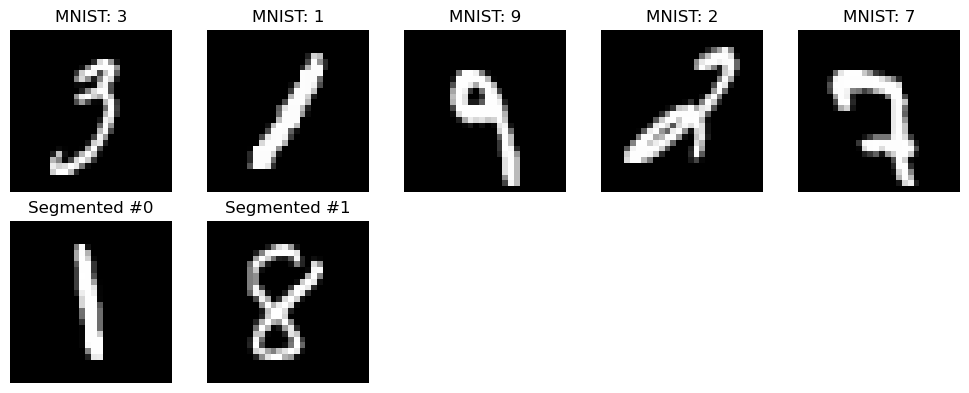

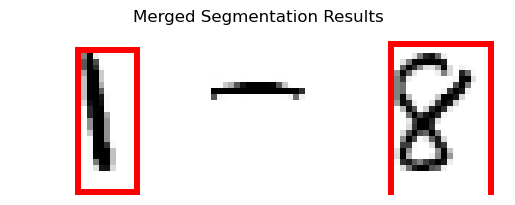

Box (11, 3, 10, 24): Classified as 1 using digit model
Box (64, 2, 17, 26): Classified as / using operator model
Reconstructed Expression: 1/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)

Processing image: expression_dataset/expr_071.png
--- MNIST Samples ---
MNIST #0 — Label: 2, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
MNIST #1 — Label: 4, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #2 — Label: 2, Shape: (28, 28), White pixels: 173, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 74, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (24, 17, 3), Preprocessed: (28, 28), Aspect: 0.71, White pixels: 119, Range: [0.00, 1.00]
ROI #1 — Original: (14, 24, 3), Preprocessed: (28, 28), Aspect: 1.71, White pixels: 53, Range: [0.00, 1.00]
ROI #2 — Original: (23, 18, 3), Preprocessed: (28, 28), Aspect: 0.78, White p

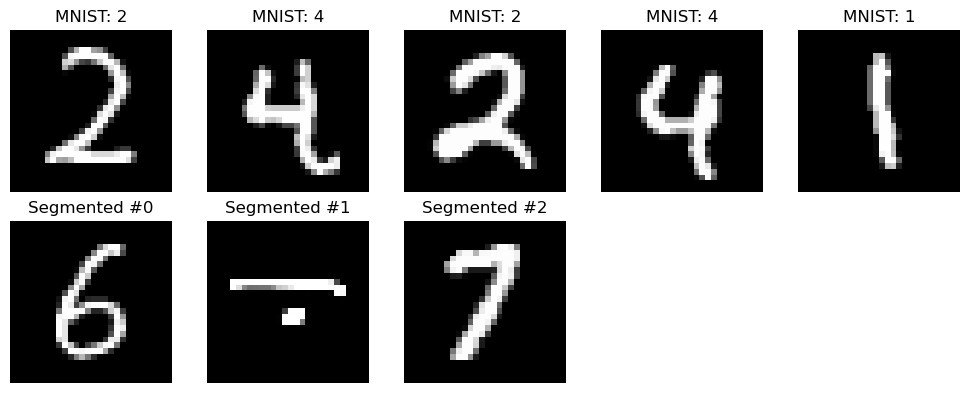

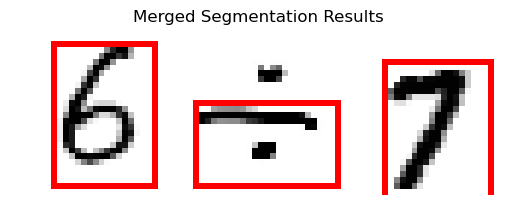

Box (7, 2, 17, 24): Classified as 6 using digit model
Box (31, 12, 24, 14): Classified as / using operator model
Box (63, 5, 18, 23): Classified as 2 using digit model
Reconstructed Expression: 6/2
Evaluation Result: 3.0

Processing image: expression_dataset/expr_065.png
--- MNIST Samples ---
MNIST #0 — Label: 6, Shape: (28, 28), White pixels: 111, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 112, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 90, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 100, Range: [0.00, 1.00]
MNIST #4 — Label: 7, Shape: (28, 28), White pixels: 120, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (22, 21, 3), Preprocessed: (28, 28), Aspect: 0.95, White pixels: 146, Range: [0.00, 1.00]
ROI #1 — Original: (22, 24, 3), Preprocessed: (28, 28), Aspect: 1.09, White pixels: 122, Range: [0.00, 1.00]


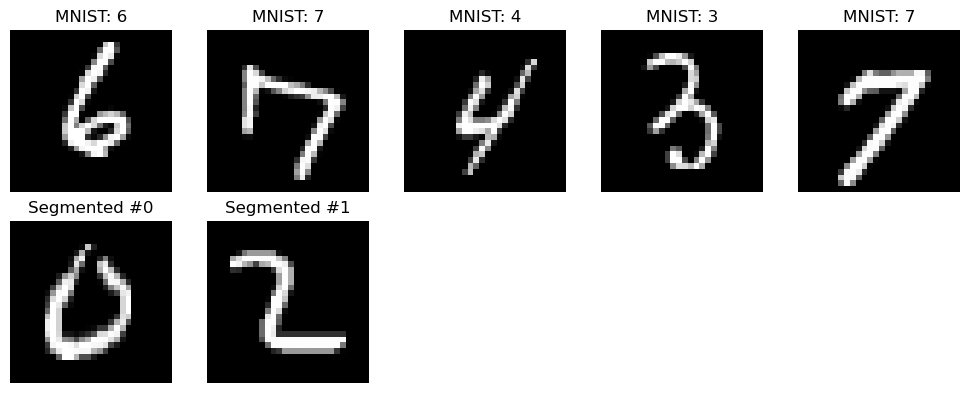

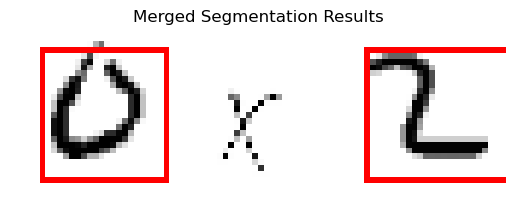

Box (5, 3, 21, 22): Classified as 0 using digit model
Box (60, 3, 24, 22): Classified as / using operator model
Reconstructed Expression: 0/
Evaluation Error: Error evaluating expression: invalid syntax (<string>, line 1)


In [484]:
digit_model = joblib.load('digit_model.joblib')
operator_model = joblib.load('operator_model.joblib')

# load input expression images
expr_files = glob.glob(os.path.join("expression_dataset", "*.png"))
if not expr_files:
    print("No expression images found in the 'expression' folder.")

for expr_file in expr_files:
    print(f"\nProcessing image: {expr_file}")
    expr_str = process_expression(expr_file, digit_model, operator_model, debug=True)
    print("Reconstructed Expression:", expr_str)
    
    try:
        result = safe_eval(expr_str)
        print("Evaluation Result:", result)
    except Exception as e:
        print("Evaluation Error:", e)
